#Import

In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 409 kB 28.0 MB/s 


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn, optim
from torchmetrics import F1Score, Recall, Accuracy
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from tqdm import tqdm
import re
from collections import Counter
from copy import deepcopy
import json
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Prepearing text

In [5]:
with open('/content/drive/MyDrive/Диплом/Code/data/data_5_tokens_1_sentences.json', 'r', encoding='utf-8') as f:
  data = f.read()
  data = json.loads(data)

In [6]:
data_tokenized = []
targets = []
for prev, sent in data:
  prev_tokenized = []
  for s in prev:
    s = re.sub('-B|-I', '', s)
    s = s.lower()
    prev_tokenized.extend(word_tokenize(s))
  sent_tokenized = word_tokenize(sent)
  sent_targets = []
  for word in sent_tokenized:
    if word.endswith('-B'):
      sent_targets.append('B')
    elif word.endswith('-I'):
      sent_targets.append('I')
    else:
      sent_targets.append('O')
  sent_tokenized = re.sub('-B|-I', '', sent)
  sent_tokenized = sent_tokenized.lower()
  sent_tokenized = word_tokenize(sent_tokenized)
  data_tokenized.append((prev_tokenized, sent_tokenized))
  targets.append(sent_targets)

In [7]:
vocab = []
[vocab.extend(text[0]) for text in data_tokenized]
vocab = Counter(vocab)
word2id = {'PAD': 0}
for word in vocab:
    word2id[word] = len(word2id)
word2id['UNK'] = len(word2id)
id2word = {i: word for word, i in word2id.items()}

subject2id = {'O': 0, 'B': 1, 'I': 2}
id2subject = {0: 'O', 1: 'B', 2: 'I'}

#Data

In [8]:
class SubDataset(Dataset):
    def __init__(self, word2id, subject2id, data, targets, DEVICE):
        super().__init__()
        self.y = deepcopy(targets)
        self.device = DEVICE
        self.X = deepcopy(data)
        self.word2id = word2id
        self.vocab_size = len(word2id)
        self.subject2id = subject2id
    
    def __getitem__(self, index):
        x_prev = deepcopy((self.X[index][0]))
        x = deepcopy(self.X[index][1])
        y = deepcopy(self.y[index])
        for num, word in enumerate(x_prev):
            if word in self.word2id.keys():
                word = self.word2id[word]
            else:
                word = self.word2id['UNK']
            x_prev[num] = word
        for num, word in enumerate(x):
            if word in self.word2id.keys():
                word = self.word2id[word]
            else:
                word = self.word2id['UNK']
            x[num] = word
        y = [self.subject2id[tag] for tag in y]
        x_prev = torch.LongTensor(x_prev)
        x = torch.LongTensor(x)
        y = torch.LongTensor(y)
        return x_prev, x, y
    
    def __len__(self):
        return len(self.X)
    
    def collate_fn(self, batch):
        x_prevs = []
        xs = []
        ys = []
        for x_prev, x, y in batch:
          x_prevs.append(x_prev)
          xs.append(x)
          ys.append(y)
        # batch_size x longest_sequence
        x_prevs = pad_sequence(x_prevs, batch_first=True).to(self.device)
        xs = pad_sequence(xs, batch_first=True).to(self.device)
        ys = pad_sequence(ys, batch_first=True).to(self.device)
        return x_prevs, xs, ys

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_tokenized, targets, shuffle=True, random_state=42)
train_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_train, targets=y_train, DEVICE=DEVICE)
test_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_test, targets=y_test, DEVICE=DEVICE)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, batch_size=256, shuffle=True)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size=256, shuffle=True)

# Model

In [ ]:
class GRU(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.gru = nn.GRU(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        _, h_n = self.gru(embedded_prev)
        output, _ = self.gru(embedded_text, h_n)
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Model 2 Cells

In [ ]:
class GRU_2Cells(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.gru_prev = nn.GRU(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.gru = nn.GRU(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        _, h_n = self.gru_prev(embedded_prev)
        output, _ = self.gru(embedded_text, h_n)
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Model Bi-directional

In [ ]:
class BiGRU(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.gru_bi = nn.GRU(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(self.hidden_size * 2, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 2 ∗ hidden_size -> output, 2 ∗ num_layers x hidden_size -> h_n
        _, h_n = self.gru_bi(embedded_prev)
        shape_h_n = int(h_n.shape[0] / 2)
        h_n = h_n[:shape_h_n, :]
        new_dir = torch.zeros_like(h_n)
        # batch_size x seq_len x 2 ∗ hidden_size -> output, 2 ∗ num_layers x hidden_size -> h_n
        h_n = torch.cat([h_n, new_dir], dim=0)
        output, _ = self.gru_bi(embedded_text, h_n)
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Model Bi-directional 2 cells

In [10]:
class BiGRU_2Cells(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.gru = nn.GRU(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.gru_bi = nn.GRU(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(self.hidden_size * 2, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        _, h_n = self.gru(embedded_prev)
        new_dir = torch.zeros_like(h_n)
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        h_n = torch.cat([h_n, new_dir], dim=0)
        output, _ = self.gru_bi(embedded_text, h_n)
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Prepearing embeddings

In [ ]:
vec_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Диплом/Code/vectors/numberbatch_ger.txt.gz', binary=False)

In [ ]:
weights = np.zeros((len(word2id), 300))
count = []
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = vec_model[word]    
    except KeyError:
        count.append(word)
        # oov словам сопоставляем случайный вектор
        weights[i] = np.random.normal(0,0.1,300)
print(f'Доля слов, отсутствующих в вокабуляре {len(count) / len(word2id)}')

Доля слов, отсутствующих в вокабуляре 0.2729710902124695


# Model Bi-directional 2 cells + embeddings

In [ ]:
class BiGRU_2Cells_Embs(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, weights, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.gru = nn.GRU(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.gru_bi = nn.GRU(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(self.hidden_size * 2, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        _, h_n = self.gru(embedded_prev)
        new_dir = torch.zeros_like(h_n)
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        h_n = torch.cat([h_n, new_dir], dim=0)
        output, _ = self.gru_bi(embedded_text, h_n)
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Training and evaluating functions

In [11]:
def train(model, iterator, optimizer, criterion, device=DEVICE):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (prev, text, y) in tqdm(enumerate(iterator)): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        pred = model(prev, text)  #прогоняем данные через модель
        shape = pred.shape
        loss = criterion(pred.reshape(shape[0] * shape[1], 3), y.reshape(-1).long()) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/(i + 1)}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке


def evaluate(model, iterator, criterion, f1, accuracy):
    epoch_loss = 0
    epoch_f1 = 0
    epoch_accuracy = 0
    model.eval() 
    with torch.no_grad():
        for i, (prev, text, y) in tqdm(enumerate(iterator)):   
            pred = model(prev, text)  # делаем предсказания на тесте
            shape = pred.shape
            loss = criterion(pred.reshape(shape[0] * shape[1], 3), y.reshape(-1).long())   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            pred_tag = torch.argmax(pred.reshape(shape[0] * shape[1], 3), dim=1)
            epoch_f1 += f1(preds=pred_tag, target=y.reshape(-1).long()).item()
            epoch_accuracy += accuracy(preds=pred_tag, target=y.reshape(-1).long()).item()

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/(i + 1)}, Val f1: {epoch_f1/(i + 1)}, Val accuracy: {epoch_accuracy/(i + 1)}')
        
    return epoch_accuracy / len(iterator), epoch_f1 / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

# Experiment 1, testing layers
* GRU
* uni
* 1 cell
* 1 layer
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = GRU(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.005, 1, 1])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


49it [00:01, 29.75it/s]

Train loss: 0.7115857217046949


95it [00:03, 31.30it/s]

Train loss: 0.7152790354357825


139it [00:04, 31.45it/s]

Train loss: 0.7109688736774303


186it [00:06, 32.50it/s]

Train loss: 0.7035231941276127


226it [00:07, 29.68it/s]


Train loss: 0.705804443889194

Evaluating on train...


54it [00:01, 46.04it/s]

Val loss: 0.7133673654662238, Val f1: 0.3627930839856466, Val accuracy: 0.36296297245555453


94it [00:02, 42.80it/s]

Val loss: 0.712080572048823, Val f1: 0.38501572046015, Val accuracy: 0.38518519434663984


139it [00:03, 41.18it/s]

Val loss: 0.7074225187301636, Val f1: 0.3726764981393461, Val accuracy: 0.3728395155182591


188it [00:04, 39.70it/s]

Val loss: 0.70401478211085, Val f1: 0.3776181931296984, Val accuracy: 0.3777777870496114


226it [00:05, 41.08it/s]


Val loss: 0.7059842321607802, Val f1: 0.3805790780650245, Val accuracy: 0.3807407499684228

Evaluating on test...


20it [00:00, 37.63it/s]

Val loss: 0.7046600659688314, Val f1: 0.33317042390505475, Val accuracy: 0.3333333432674408


36it [00:00, 37.83it/s]

Val loss: 0.7261017541090647, Val f1: 0.3331457793712616, Val accuracy: 0.3333333432674408


52it [00:01, 38.16it/s]

Val loss: 0.7192011992136638, Val f1: 0.333154433965683, Val accuracy: 0.3333333432674408


65it [00:01, 38.32it/s]

Val loss: 0.7126970758040746, Val f1: 0.35538417398929595, Val accuracy: 0.3555555651585261


76it [00:01, 38.45it/s]


Val loss: 0.7163470808664958, Val f1: 0.35982295910517376, Val accuracy: 0.36000000953674316

starting Epoch 1
Training...


48it [00:01, 22.00it/s]

Train loss: 0.6996293465296427


96it [00:03, 29.75it/s]

Train loss: 0.7023606048689948


140it [00:05, 31.25it/s]

Train loss: 0.7038258230244672


184it [00:06, 32.07it/s]

Train loss: 0.7051641599999534


226it [00:07, 28.36it/s]


Train loss: 0.7062920008765327

Evaluating on train...


50it [00:01, 44.61it/s]

Val loss: 0.6890579594506158, Val f1: 0.3776371909512414, Val accuracy: 0.3777777870496114


95it [00:02, 42.91it/s]

Val loss: 0.7022842142317031, Val f1: 0.35539898210101656, Val accuracy: 0.3555555651585261


140it [00:03, 42.82it/s]

Val loss: 0.703045935984011, Val f1: 0.3628049949804942, Val accuracy: 0.36296297245555453


185it [00:04, 39.51it/s]

Val loss: 0.7043702407015695, Val f1: 0.36650650898615517, Val accuracy: 0.3666666761040688


226it [00:05, 42.49it/s]


Val loss: 0.704563328689999, Val f1: 0.36872767236497667, Val accuracy: 0.3688888982931773

Evaluating on test...


20it [00:00, 41.30it/s]

Val loss: 0.6993017156918844, Val f1: 0.37762378056844076, Val accuracy: 0.3777777870496114


35it [00:00, 41.54it/s]

Val loss: 0.7072993338108062, Val f1: 0.377607465783755, Val accuracy: 0.3777777870496114


50it [00:01, 41.05it/s]

Val loss: 0.7102336433198717, Val f1: 0.3776061475276947, Val accuracy: 0.3777777870496114


65it [00:01, 40.24it/s]

Val loss: 0.7177750021219254, Val f1: 0.3664867435892423, Val accuracy: 0.3666666761040688


76it [00:01, 40.84it/s]


Val loss: 0.7157136567433675, Val f1: 0.3598232690493266, Val accuracy: 0.36000000953674316

starting Epoch 2
Training...


48it [00:01, 30.72it/s]

Train loss: 0.7159601555930244


94it [00:03, 27.18it/s]

Train loss: 0.70231720606486


136it [00:05, 18.45it/s]

Train loss: 0.695531200921094


183it [00:07, 22.08it/s]

Train loss: 0.7077130026287503


226it [00:08, 25.22it/s]


Train loss: 0.7047205766042074

Evaluating on train...


50it [00:01, 45.88it/s]

Val loss: 0.7045844594637553, Val f1: 0.3479915526178148, Val accuracy: 0.34814815786149766


95it [00:02, 44.34it/s]

Val loss: 0.7037456962797377, Val f1: 0.3628047363625632, Val accuracy: 0.36296297245555453


138it [00:03, 25.57it/s]

Val loss: 0.7024947996492739, Val f1: 0.36280533428545353, Val accuracy: 0.36296297245555453


186it [00:05, 36.86it/s]

Val loss: 0.7076495667298635, Val f1: 0.3553927900062667, Val accuracy: 0.3555555651585261


226it [00:06, 35.13it/s]


Val loss: 0.7074766567018297, Val f1: 0.3627996297677358, Val accuracy: 0.36296297245555453

Evaluating on test...


19it [00:00, 28.48it/s]

Val loss: 0.6896422664324443, Val f1: 0.37763732274373374, Val accuracy: 0.3777777870496114


35it [00:01, 36.33it/s]

Val loss: 0.701057889064153, Val f1: 0.37761795620123545, Val accuracy: 0.3777777870496114


52it [00:01, 38.07it/s]

Val loss: 0.7003692004415724, Val f1: 0.3924329737822215, Val accuracy: 0.39259260164366827


65it [00:01, 38.67it/s]

Val loss: 0.7079806705315908, Val f1: 0.37760919431845347, Val accuracy: 0.3777777870496114


76it [00:02, 32.57it/s]


Val loss: 0.7079368154207866, Val f1: 0.3687213687102, Val accuracy: 0.3688888982931773

starting Epoch 3
Training...


50it [00:02, 31.15it/s]

Train loss: 0.6924252973662482


92it [00:03, 31.47it/s]

Train loss: 0.6972734669844309


140it [00:04, 32.50it/s]

Train loss: 0.6985928001227202


184it [00:06, 32.06it/s]

Train loss: 0.703436263402303


226it [00:07, 29.58it/s]


Train loss: 0.7043286432160272

Evaluating on train...


50it [00:01, 45.25it/s]

Val loss: 0.7026918133099874, Val f1: 0.3628067996766832, Val accuracy: 0.36296297245555453


95it [00:02, 44.97it/s]

Val loss: 0.7007563524776035, Val f1: 0.3776229523950153, Val accuracy: 0.3777777870496114


140it [00:03, 42.50it/s]

Val loss: 0.701452147077631, Val f1: 0.372682919104894, Val accuracy: 0.3728395155182591


185it [00:04, 42.43it/s]

Val loss: 0.7048758612738715, Val f1: 0.3628031442562739, Val accuracy: 0.36296297245555453


226it [00:05, 43.24it/s]


Val loss: 0.7032287187046475, Val f1: 0.36280516068140667, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 43.02it/s]

Val loss: 0.7005119125048319, Val f1: 0.3776263177394867, Val accuracy: 0.3777777870496114


35it [00:00, 41.48it/s]

Val loss: 0.7127338846524557, Val f1: 0.3553884893655777, Val accuracy: 0.3555555651585261


49it [00:01, 32.65it/s]

Val loss: 0.705106090174781, Val f1: 0.3628038419617547, Val accuracy: 0.36296297245555453


63it [00:01, 27.60it/s]

Val loss: 0.7137723018725713, Val f1: 0.3664959818124771, Val accuracy: 0.3666666761040688


76it [00:02, 32.70it/s]


Val loss: 0.7153708052635193, Val f1: 0.3687161382039388, Val accuracy: 0.3688888982931773

starting Epoch 4
Training...


50it [00:01, 31.54it/s]

Train loss: 0.7172764976819356


94it [00:03, 28.43it/s]

Train loss: 0.7066098325782352


140it [00:04, 24.32it/s]

Train loss: 0.6988160579292862


184it [00:06, 30.05it/s]

Train loss: 0.6958278480503294


226it [00:07, 28.54it/s]


Train loss: 0.7002402117517259

Evaluating on train...


47it [00:01, 31.82it/s]

Val loss: 0.6963483174641927, Val f1: 0.4003944271140628, Val accuracy: 0.39760366413328385


95it [00:03, 29.10it/s]

Val loss: 0.6997934752040439, Val f1: 0.40201502674155765, Val accuracy: 0.3957241005367703


140it [00:04, 36.89it/s]

Val loss: 0.6930943149107474, Val f1: 0.39208731695457744, Val accuracy: 0.3859996614632783


187it [00:05, 41.07it/s]

Val loss: 0.6929830706781811, Val f1: 0.39523873792754277, Val accuracy: 0.38841556443108455


226it [00:06, 33.38it/s]


Val loss: 0.6954061714808146, Val f1: 0.3942083451482985, Val accuracy: 0.38704403705067103

Evaluating on test...


22it [00:00, 39.42it/s]

Val loss: 0.6946253180503845, Val f1: 0.36832204858462014, Val accuracy: 0.3626193583011627


35it [00:00, 39.44it/s]

Val loss: 0.6880564411481221, Val f1: 0.3738938460747401, Val accuracy: 0.3687119702498118


48it [00:01, 39.04it/s]

Val loss: 0.6961880604426066, Val f1: 0.37528212004237704, Val accuracy: 0.36783503691355385


66it [00:01, 39.27it/s]

Val loss: 0.7004354457060497, Val f1: 0.3832239583134651, Val accuracy: 0.37501047253608705


76it [00:01, 39.55it/s]


Val loss: 0.6971141584714253, Val f1: 0.3836696215470632, Val accuracy: 0.37472262064615885

starting Epoch 5
Training...


47it [00:01, 20.88it/s]

Train loss: 0.693506842189365


94it [00:03, 30.56it/s]

Train loss: 0.6741387002997928


141it [00:05, 30.93it/s]

Train loss: 0.6600069867240058


185it [00:06, 29.20it/s]

Train loss: 0.6528093271785312


226it [00:08, 27.79it/s]


Train loss: 0.6454221969180637

Evaluating on train...


50it [00:01, 45.46it/s]

Val loss: 0.6041868938340081, Val f1: 0.40494053032663135, Val accuracy: 0.7783067954911126


95it [00:02, 42.94it/s]

Val loss: 0.6021515243583255, Val f1: 0.4060693197780185, Val accuracy: 0.7883400817712148


140it [00:03, 42.09it/s]

Val loss: 0.6023807168006897, Val f1: 0.4060293402936723, Val accuracy: 0.7884179958590755


185it [00:04, 42.12it/s]

Val loss: 0.6031876077254613, Val f1: 0.4070800609058804, Val accuracy: 0.7894844025373459


226it [00:05, 43.14it/s]


Val loss: 0.6036085708936055, Val f1: 0.4071542216671838, Val accuracy: 0.7908490165074666

Evaluating on test...


20it [00:00, 39.80it/s]

Val loss: 0.6145101904869079, Val f1: 0.3967123806476593, Val accuracy: 0.7327325026194255


36it [00:00, 39.06it/s]

Val loss: 0.6143527110417684, Val f1: 0.39816625813643136, Val accuracy: 0.7391487320264181


49it [00:01, 39.13it/s]

Val loss: 0.6136403560638428, Val f1: 0.40039146939913434, Val accuracy: 0.7584645880593194


64it [00:01, 41.26it/s]

Val loss: 0.6150852531194687, Val f1: 0.40399876683950425, Val accuracy: 0.7639014760653178


76it [00:01, 40.25it/s]


Val loss: 0.6140617060661316, Val f1: 0.40068793495496113, Val accuracy: 0.7629190723101298

starting Epoch 6
Training...


49it [00:01, 29.30it/s]

Train loss: 0.6063075582186381


93it [00:03, 31.75it/s]

Train loss: 0.6022686805990007


141it [00:04, 32.77it/s]

Train loss: 0.6010083278020223


185it [00:06, 30.97it/s]

Train loss: 0.6002306825584836


226it [00:07, 30.70it/s]


Train loss: 0.5984692676862081

Evaluating on train...


54it [00:01, 46.24it/s]

Val loss: 0.5808845082918803, Val f1: 0.405388085047404, Val accuracy: 0.8669658667511411


94it [00:02, 40.66it/s]

Val loss: 0.582406708267, Val f1: 0.40505533549520706, Val accuracy: 0.8853723251157337


144it [00:03, 43.33it/s]

Val loss: 0.583245332594271, Val f1: 0.40527885180932505, Val accuracy: 0.8808246917194791


184it [00:04, 40.34it/s]

Val loss: 0.5828546941280365, Val f1: 0.4073288760251469, Val accuracy: 0.8894581662284003


226it [00:05, 42.41it/s]


Val loss: 0.5820552847120497, Val f1: 0.4061681548754374, Val accuracy: 0.8855803978443145

Evaluating on test...


21it [00:00, 38.71it/s]

Val loss: 0.6015201767285665, Val f1: 0.4165640334288279, Val accuracy: 0.8762364824612935


35it [00:00, 39.98it/s]

Val loss: 0.5917069892088572, Val f1: 0.41001189649105074, Val accuracy: 0.8672326395908991


52it [00:01, 39.87it/s]

Val loss: 0.5921622567706638, Val f1: 0.40141286253929137, Val accuracy: 0.8338492234547933


66it [00:01, 40.47it/s]

Val loss: 0.5934638679027557, Val f1: 0.39728813568751015, Val accuracy: 0.835725779334704


76it [00:01, 39.74it/s]


Val loss: 0.5968876520792643, Val f1: 0.39579331477483115, Val accuracy: 0.8330648962656657

starting Epoch 7
Training...


50it [00:01, 30.54it/s]

Train loss: 0.5838655908902486


94it [00:03, 30.39it/s]

Train loss: 0.584406707684199


138it [00:04, 30.69it/s]

Train loss: 0.58439893634231


182it [00:06, 30.97it/s]

Train loss: 0.5838643888632457


226it [00:07, 30.16it/s]


Train loss: 0.583648817009396

Evaluating on train...


50it [00:01, 47.10it/s]

Val loss: 0.5762680053710938, Val f1: 0.44914042287402683, Val accuracy: 0.8956997315088908


95it [00:02, 44.31it/s]

Val loss: 0.575690135690901, Val f1: 0.44076198240121206, Val accuracy: 0.8932610730330149


140it [00:03, 41.45it/s]

Val loss: 0.5750784891623038, Val f1: 0.4401056009310263, Val accuracy: 0.8908304708975333


185it [00:04, 41.96it/s]

Val loss: 0.5756493323379093, Val f1: 0.44044908069901995, Val accuracy: 0.888049766421318


226it [00:05, 43.62it/s]


Val loss: 0.5766987930403815, Val f1: 0.4425086330042945, Val accuracy: 0.8945384502410889

Evaluating on test...


22it [00:00, 39.55it/s]

Val loss: 0.6031032562255859, Val f1: 0.4134466052055359, Val accuracy: 0.824386727809906


37it [00:00, 40.39it/s]

Val loss: 0.5962665577729543, Val f1: 0.4079756965239843, Val accuracy: 0.8121921002864838


51it [00:01, 39.81it/s]

Val loss: 0.5973317795329623, Val f1: 0.41107678082254195, Val accuracy: 0.8200238717926873


65it [00:01, 39.78it/s]

Val loss: 0.6003336638212204, Val f1: 0.42007176429033277, Val accuracy: 0.8181175827980042


76it [00:01, 39.89it/s]


Val loss: 0.6001881090799968, Val f1: 0.4201998988787333, Val accuracy: 0.8124774134159088

starting Epoch 8
Training...


50it [00:01, 30.36it/s]

Train loss: 0.5732481373680962


96it [00:03, 30.67it/s]

Train loss: 0.5737398829725053


140it [00:04, 31.30it/s]

Train loss: 0.5758140546304208


183it [00:06, 29.76it/s]

Train loss: 0.5763000600867801


226it [00:07, 30.22it/s]


Train loss: 0.5760698045624627

Evaluating on train...


50it [00:01, 45.80it/s]

Val loss: 0.5698631909158495, Val f1: 0.4407212800449795, Val accuracy: 0.9371435271369086


95it [00:02, 43.74it/s]

Val loss: 0.5701393160555098, Val f1: 0.43568931917349496, Val accuracy: 0.9088902797963884


140it [00:03, 41.51it/s]

Val loss: 0.5698839002185397, Val f1: 0.43574013224354496, Val accuracy: 0.9303898277106109


184it [00:04, 40.33it/s]

Val loss: 0.5703011446528965, Val f1: 0.43303607122765647, Val accuracy: 0.9239563145571285


226it [00:05, 42.69it/s]


Val loss: 0.5715128056208293, Val f1: 0.43535210026635063, Val accuracy: 0.9216544327470991

Evaluating on test...


22it [00:00, 40.70it/s]

Val loss: 0.5830527623494466, Val f1: 0.4171910583972931, Val accuracy: 0.8832992533842723


37it [00:00, 40.74it/s]

Val loss: 0.5924620767434438, Val f1: 0.4165668537219365, Val accuracy: 0.8454266458749771


52it [00:01, 40.84it/s]

Val loss: 0.59431914223565, Val f1: 0.4155990991327498, Val accuracy: 0.839806838830312


67it [00:01, 40.48it/s]

Val loss: 0.5924872408310572, Val f1: 0.4150469645857811, Val accuracy: 0.8469525098800659


76it [00:01, 40.25it/s]


Val loss: 0.595417226155599, Val f1: 0.41263486226399737, Val accuracy: 0.8350297371546428

starting Epoch 9
Training...


48it [00:01, 30.49it/s]

Train loss: 0.5745052006509569


96it [00:03, 31.24it/s]

Train loss: 0.5733331395520105


140it [00:04, 29.93it/s]

Train loss: 0.5732435169043364


185it [00:06, 30.94it/s]

Train loss: 0.5734953261084027


226it [00:07, 30.15it/s]


Train loss: 0.5728642601437038

Evaluating on train...


50it [00:01, 47.58it/s]

Val loss: 0.5697492096159193, Val f1: 0.5048057721720801, Val accuracy: 0.9404342479175991


95it [00:02, 44.20it/s]

Val loss: 0.5706529087490506, Val f1: 0.49899250434504616, Val accuracy: 0.9287861814101537


140it [00:03, 41.82it/s]

Val loss: 0.5680008044949284, Val f1: 0.4936073011822171, Val accuracy: 0.932009032037523


185it [00:04, 43.44it/s]

Val loss: 0.5668120125929514, Val f1: 0.49926559925079345, Val accuracy: 0.9379960477352143


226it [00:05, 43.61it/s]


Val loss: 0.5679352966944377, Val f1: 0.49676805429988435, Val accuracy: 0.9314569066630469

Evaluating on test...


21it [00:00, 39.74it/s]

Val loss: 0.5938180406888326, Val f1: 0.4528114259243011, Val accuracy: 0.8019421199957529


30it [00:00, 40.31it/s]

Val loss: 0.5970683395862579, Val f1: 0.44840688904126486, Val accuracy: 0.7958556205034256


53it [00:01, 33.97it/s]

Val loss: 0.5984968331125048, Val f1: 0.45366733140415616, Val accuracy: 0.7928006774849362


65it [00:01, 35.45it/s]

Val loss: 0.60179583132267, Val f1: 0.45576849977175393, Val accuracy: 0.802153450747331


76it [00:02, 34.14it/s]


Val loss: 0.6037898238499959, Val f1: 0.4505493418375651, Val accuracy: 0.7883570758501689

starting Epoch 10
Training...


49it [00:01, 30.62it/s]

Train loss: 0.5651395943429735


94it [00:03, 29.49it/s]

Train loss: 0.5683175378375583


138it [00:04, 31.00it/s]

Train loss: 0.5700201917577673


186it [00:06, 30.48it/s]

Train loss: 0.571542556087176


226it [00:07, 29.99it/s]


Train loss: 0.5709338479571873

Evaluating on train...


50it [00:01, 45.27it/s]

Val loss: 0.5659488876660664, Val f1: 0.45241465237405565, Val accuracy: 0.9209466636180877


95it [00:02, 44.08it/s]

Val loss: 0.5653460284074148, Val f1: 0.45965890884399413, Val accuracy: 0.9410714801814821


140it [00:03, 42.64it/s]

Val loss: 0.5673082590103149, Val f1: 0.46026373086152256, Val accuracy: 0.9352448529667324


185it [00:04, 40.69it/s]

Val loss: 0.5668414172199038, Val f1: 0.4601829951008161, Val accuracy: 0.9248127084639337


226it [00:05, 43.41it/s]


Val loss: 0.5666515281465319, Val f1: 0.4632565756638845, Val accuracy: 0.933314415746265

Evaluating on test...


19it [00:00, 39.70it/s]

Val loss: 0.6017928163210551, Val f1: 0.42988413373629253, Val accuracy: 0.8527443567911784


37it [00:00, 40.65it/s]

Val loss: 0.5906804462273916, Val f1: 0.4177693645159403, Val accuracy: 0.8691949248313904


52it [00:01, 41.45it/s]

Val loss: 0.5934014532301161, Val f1: 0.42828458812501696, Val accuracy: 0.845906607972251


67it [00:01, 40.92it/s]

Val loss: 0.5968049913644791, Val f1: 0.43082727094491324, Val accuracy: 0.8453970457116763


76it [00:01, 40.19it/s]


Val loss: 0.5972320826848349, Val f1: 0.42554096500078836, Val accuracy: 0.841682277917862

starting Epoch 11
Training...


49it [00:01, 30.15it/s]

Train loss: 0.567904535929362


93it [00:03, 30.13it/s]

Train loss: 0.5675262073675792


141it [00:04, 31.46it/s]

Train loss: 0.5666278057628208


184it [00:06, 29.58it/s]

Train loss: 0.5673363437255223


226it [00:07, 29.95it/s]


Train loss: 0.5678837140401204

Evaluating on train...


50it [00:01, 46.88it/s]

Val loss: 0.5648508124881321, Val f1: 0.45174599885940553, Val accuracy: 0.9633120020230611


95it [00:02, 46.43it/s]

Val loss: 0.5642760687404209, Val f1: 0.4506032791402605, Val accuracy: 0.9659790953000387


140it [00:03, 42.85it/s]

Val loss: 0.5648835636951305, Val f1: 0.4532792490941507, Val accuracy: 0.965988137986925


185it [00:04, 40.67it/s]

Val loss: 0.5651422484053505, Val f1: 0.4502651805679003, Val accuracy: 0.958166915178299


226it [00:05, 43.49it/s]


Val loss: 0.5648616120550367, Val f1: 0.45119614243507383, Val accuracy: 0.9549092049068875

Evaluating on test...


19it [00:00, 37.84it/s]

Val loss: 0.5816895564397176, Val f1: 0.3898986260096232, Val accuracy: 0.9055319388707479


34it [00:01, 27.63it/s]

Val loss: 0.5856880287329356, Val f1: 0.39637231032053627, Val accuracy: 0.8961802820364634


50it [00:01, 34.70it/s]

Val loss: 0.588755640718672, Val f1: 0.4102844092581007, Val accuracy: 0.8918213446935018


67it [00:02, 37.92it/s]

Val loss: 0.5920647899309794, Val f1: 0.4095413009325663, Val accuracy: 0.8823712011178334


76it [00:02, 33.04it/s]


Val loss: 0.5939656718571981, Val f1: 0.41244452198346454, Val accuracy: 0.8596035162607829

starting Epoch 12
Training...


50it [00:01, 27.74it/s]

Train loss: 0.5621979435284933


93it [00:03, 29.83it/s]

Train loss: 0.5635366433196598


140it [00:04, 31.57it/s]

Train loss: 0.5659599900245667


184it [00:06, 31.28it/s]

Train loss: 0.5672141727474


226it [00:07, 29.03it/s]


Train loss: 0.5671632597181532

Evaluating on train...


50it [00:01, 46.45it/s]

Val loss: 0.5631649692853292, Val f1: 0.4936652077568902, Val accuracy: 0.9444485366344452


95it [00:02, 43.62it/s]

Val loss: 0.5625192238224878, Val f1: 0.49276200069321524, Val accuracy: 0.9652330799235238


140it [00:03, 42.59it/s]

Val loss: 0.5625742338321827, Val f1: 0.49268268589620234, Val accuracy: 0.9593663524698328


185it [00:04, 41.59it/s]

Val loss: 0.5627574119302962, Val f1: 0.4900248600376977, Val accuracy: 0.9559291996889644


226it [00:05, 42.84it/s]


Val loss: 0.5630428536732992, Val f1: 0.4831462535593245, Val accuracy: 0.9467531447940403

Evaluating on test...


18it [00:00, 41.02it/s]

Val loss: 0.6063140710194905, Val f1: 0.4233045558134715, Val accuracy: 0.8288567304611206


38it [00:00, 41.43it/s]

Val loss: 0.6006803015867869, Val f1: 0.40827595194180805, Val accuracy: 0.7704506138960521


53it [00:01, 40.74it/s]

Val loss: 0.6008543213208516, Val f1: 0.41530266602834065, Val accuracy: 0.7859111302428775


68it [00:01, 40.07it/s]

Val loss: 0.6034580091635386, Val f1: 0.4224284589290619, Val accuracy: 0.7949445143342018


76it [00:01, 40.55it/s]


Val loss: 0.6016479293505351, Val f1: 0.4233684273560842, Val accuracy: 0.8036834037303925

starting Epoch 13
Training...


48it [00:01, 29.94it/s]

Train loss: 0.5642651544676887


93it [00:03, 30.98it/s]

Train loss: 0.5632945352130466


137it [00:04, 28.93it/s]

Train loss: 0.5647699497364186


185it [00:06, 30.11it/s]

Train loss: 0.5644828475183911


226it [00:07, 29.80it/s]


Train loss: 0.5652377888891432

Evaluating on train...


54it [00:01, 43.53it/s]

Val loss: 0.5605360560946995, Val f1: 0.45284264087677, Val accuracy: 0.9706784923871358


94it [00:02, 41.48it/s]

Val loss: 0.5632604910267724, Val f1: 0.4498709499835968, Val accuracy: 0.94415948357847


139it [00:03, 41.42it/s]

Val loss: 0.5633426123195224, Val f1: 0.4515747438978266, Val accuracy: 0.9427112482212208


184it [00:04, 39.30it/s]

Val loss: 0.5632609943548839, Val f1: 0.4533543826805221, Val accuracy: 0.9401617775360743


226it [00:05, 41.51it/s]


Val loss: 0.5631639448801676, Val f1: 0.4516131197081672, Val accuracy: 0.9403743909464942

Evaluating on test...


23it [00:00, 41.17it/s]

Val loss: 0.5984377026557922, Val f1: 0.4062698741753896, Val accuracy: 0.8395615696907044


38it [00:00, 41.67it/s]

Val loss: 0.5925695538520813, Val f1: 0.40203333695729576, Val accuracy: 0.8628109673659007


53it [00:01, 41.67it/s]

Val loss: 0.5960740751690334, Val f1: 0.41037808259328207, Val accuracy: 0.857624175813463


63it [00:01, 40.87it/s]

Val loss: 0.5964504698912303, Val f1: 0.41202864001194633, Val accuracy: 0.8548556675513586


76it [00:01, 40.75it/s]


Val loss: 0.5981512228647868, Val f1: 0.41102522214253745, Val accuracy: 0.8459622073173523

starting Epoch 14
Training...


48it [00:01, 29.08it/s]

Train loss: 0.565055583582984


92it [00:03, 29.19it/s]

Train loss: 0.5644500229093764


139it [00:04, 30.46it/s]

Train loss: 0.5643658253881666


183it [00:06, 30.01it/s]

Train loss: 0.5645918531550301


226it [00:07, 29.84it/s]


Train loss: 0.5648449987835354

Evaluating on train...


50it [00:01, 46.65it/s]

Val loss: 0.5639728095796374, Val f1: 0.459632980161243, Val accuracy: 0.9797137419382731


95it [00:02, 44.16it/s]

Val loss: 0.5648959457874299, Val f1: 0.4636154211229748, Val accuracy: 0.9555967400471369


140it [00:03, 40.40it/s]

Val loss: 0.5627409846694381, Val f1: 0.4632007620952748, Val accuracy: 0.9497467564211951


185it [00:04, 41.69it/s]

Val loss: 0.5631109476089478, Val f1: 0.46340698848168055, Val accuracy: 0.9461301474107636


226it [00:05, 42.55it/s]


Val loss: 0.5626857076750861, Val f1: 0.4638552979628245, Val accuracy: 0.9537524423334334

Evaluating on test...


20it [00:00, 36.47it/s]

Val loss: 0.5988321979840596, Val f1: 0.4028957943121592, Val accuracy: 0.7567056337992351


37it [00:00, 38.01it/s]

Val loss: 0.5989681800206502, Val f1: 0.4082892696062724, Val accuracy: 0.7879018386205038


50it [00:01, 38.22it/s]

Val loss: 0.6045840501785278, Val f1: 0.4134879966576894, Val accuracy: 0.8046290914217631


68it [00:01, 39.63it/s]

Val loss: 0.6005794485410054, Val f1: 0.4179910952846209, Val accuracy: 0.829468114177386


76it [00:01, 38.73it/s]


Val loss: 0.5981461350123087, Val f1: 0.4132733444372813, Val accuracy: 0.8242925910154978

starting Epoch 15
Training...


49it [00:01, 28.49it/s]

Train loss: 0.5581733332739935


95it [00:03, 29.40it/s]

Train loss: 0.5604707188076443


141it [00:04, 30.83it/s]

Train loss: 0.5620804905891419


186it [00:06, 30.32it/s]

Train loss: 0.5631925556394789


226it [00:07, 29.65it/s]


Train loss: 0.5641302082273695

Evaluating on train...


50it [00:01, 45.93it/s]

Val loss: 0.5639277577400208, Val f1: 0.49896527263853285, Val accuracy: 0.9433353808191087


95it [00:02, 32.12it/s]

Val loss: 0.5619586057133145, Val f1: 0.49809603293736776, Val accuracy: 0.9652243793010712


140it [00:03, 40.31it/s]

Val loss: 0.5620773699548509, Val f1: 0.4946144415272607, Val accuracy: 0.94880035188463


185it [00:04, 42.03it/s]

Val loss: 0.562161742316352, Val f1: 0.4900315741697947, Val accuracy: 0.9484034750196669


226it [00:05, 40.43it/s]


Val loss: 0.5623053778542413, Val f1: 0.4910760785473718, Val accuracy: 0.9461449729071723

Evaluating on test...


22it [00:00, 39.98it/s]

Val loss: 0.6023392637570699, Val f1: 0.4404715438683828, Val accuracy: 0.831257704893748


35it [00:00, 39.55it/s]

Val loss: 0.5961654007434845, Val f1: 0.44093147218227385, Val accuracy: 0.8558992107709249


53it [00:01, 39.47it/s]

Val loss: 0.6010151147842407, Val f1: 0.43299804793463814, Val accuracy: 0.8244987070560456


66it [00:01, 39.41it/s]

Val loss: 0.6017448683579762, Val f1: 0.4329447184999784, Val accuracy: 0.8275123114387194


76it [00:01, 39.19it/s]


Val loss: 0.6069260104497274, Val f1: 0.42726911981900534, Val accuracy: 0.8078685394922892

starting Epoch 16
Training...


50it [00:01, 30.08it/s]

Train loss: 0.5644561754332649


93it [00:03, 30.43it/s]

Train loss: 0.5624490016036563


139it [00:04, 31.00it/s]

Train loss: 0.5628343078825209


186it [00:06, 30.22it/s]

Train loss: 0.5628958125909169


226it [00:07, 29.75it/s]


Train loss: 0.5630768280559116

Evaluating on train...


51it [00:01, 46.71it/s]

Val loss: 0.5609012511041429, Val f1: 0.48187862038612367, Val accuracy: 0.9415638029575348


96it [00:02, 44.18it/s]

Val loss: 0.5605910340944926, Val f1: 0.4919051872359382, Val accuracy: 0.958147856924269


141it [00:03, 41.50it/s]

Val loss: 0.560738902621799, Val f1: 0.486726388224849, Val accuracy: 0.9515894825811739


186it [00:04, 40.79it/s]

Val loss: 0.5617111159695519, Val f1: 0.4890904840495851, Val accuracy: 0.9568169529239337


226it [00:05, 42.79it/s]


Val loss: 0.5625400347179836, Val f1: 0.4882206126054128, Val accuracy: 0.956843989027871

Evaluating on test...


19it [00:00, 40.16it/s]

Val loss: 0.5869326670964559, Val f1: 0.41131536960601806, Val accuracy: 0.8091781695683797


37it [00:00, 39.22it/s]

Val loss: 0.5953170339266459, Val f1: 0.41211881041526793, Val accuracy: 0.7651784549156825


49it [00:01, 37.54it/s]

Val loss: 0.6001183748245239, Val f1: 0.4090724481476678, Val accuracy: 0.7690996938281589


65it [00:01, 38.03it/s]

Val loss: 0.6006256878376007, Val f1: 0.4158116474747658, Val accuracy: 0.7947756946086884


76it [00:01, 38.71it/s]


Val loss: 0.6020308407147725, Val f1: 0.416439258257548, Val accuracy: 0.7857628683249156

starting Epoch 17
Training...


50it [00:01, 30.45it/s]

Train loss: 0.565076678329044


93it [00:03, 29.80it/s]

Train loss: 0.562958687543869


140it [00:04, 29.89it/s]

Train loss: 0.5623844822247823


182it [00:06, 28.70it/s]

Train loss: 0.5624665978882047


226it [00:07, 29.90it/s]


Train loss: 0.5621262868245442

Evaluating on train...


50it [00:01, 46.48it/s]

Val loss: 0.5560649103588529, Val f1: 0.5300466438134511, Val accuracy: 0.9679583509763082


95it [00:02, 45.03it/s]

Val loss: 0.5577975882424249, Val f1: 0.5372319546010759, Val accuracy: 0.9606016923983892


140it [00:03, 43.46it/s]

Val loss: 0.558353735782482, Val f1: 0.5326903144518534, Val accuracy: 0.9590410380451767


185it [00:04, 43.10it/s]

Val loss: 0.5591670625739628, Val f1: 0.5332449247439702, Val accuracy: 0.952907661928071


226it [00:05, 43.60it/s]


Val loss: 0.559679601987203, Val f1: 0.5377094781398774, Val accuracy: 0.95532066543897

Evaluating on test...


23it [00:00, 40.31it/s]

Val loss: 0.6274081707000733, Val f1: 0.4412405292193095, Val accuracy: 0.7693674723307292


37it [00:00, 40.11it/s]

Val loss: 0.6106356382369995, Val f1: 0.43422773480415344, Val accuracy: 0.7942293345928192


52it [00:01, 39.97it/s]

Val loss: 0.6059707707828945, Val f1: 0.43996419111887614, Val accuracy: 0.8008240434858535


67it [00:01, 40.54it/s]

Val loss: 0.6052670280138651, Val f1: 0.4391674945751826, Val accuracy: 0.7970141400893529


76it [00:01, 40.12it/s]


Val loss: 0.6067803955078125, Val f1: 0.44439613898595176, Val accuracy: 0.7927153797944387

starting Epoch 18
Training...


50it [00:01, 30.59it/s]

Train loss: 0.5594921708106995


94it [00:03, 29.20it/s]

Train loss: 0.5587932851579455


139it [00:04, 31.01it/s]

Train loss: 0.5615107081554555


183it [00:06, 31.08it/s]

Train loss: 0.5620843585994508


226it [00:07, 29.95it/s]


Train loss: 0.5620566993289524

Evaluating on train...


50it [00:01, 44.20it/s]

Val loss: 0.5606887764400906, Val f1: 0.5164562046527863, Val accuracy: 0.9342579881350199


95it [00:02, 44.56it/s]

Val loss: 0.5595866309271919, Val f1: 0.5293325328164631, Val accuracy: 0.954270906580819


140it [00:03, 43.06it/s]

Val loss: 0.5606455913296452, Val f1: 0.531118611715458, Val accuracy: 0.9525511869677791


185it [00:04, 40.96it/s]

Val loss: 0.5599887039926317, Val f1: 0.529043434229162, Val accuracy: 0.9478040508098072


226it [00:05, 42.98it/s]


Val loss: 0.5599555121527777, Val f1: 0.5274308893415663, Val accuracy: 0.9471532641516791

Evaluating on test...


22it [00:00, 39.80it/s]

Val loss: 0.6075586954752604, Val f1: 0.43750832478205365, Val accuracy: 0.7982304771741231


36it [00:00, 40.74it/s]

Val loss: 0.6173991203308106, Val f1: 0.4358229676882426, Val accuracy: 0.7730224241813024


51it [00:01, 40.93it/s]

Val loss: 0.6132728113068475, Val f1: 0.4309980882538689, Val accuracy: 0.7637868901093801


64it [00:01, 38.95it/s]

Val loss: 0.6076333433389663, Val f1: 0.43976259529590606, Val accuracy: 0.7865891511241595


76it [00:01, 39.42it/s]


Val loss: 0.6080153584480286, Val f1: 0.43751867214838663, Val accuracy: 0.7777814877033233

starting Epoch 19
Training...


51it [00:01, 29.38it/s]

Train loss: 0.5634255713886684


94it [00:03, 30.31it/s]

Train loss: 0.5624963839848837


140it [00:04, 28.60it/s]

Train loss: 0.5624557336171468


183it [00:06, 30.73it/s]

Train loss: 0.5615824772251977


226it [00:07, 29.64it/s]


Train loss: 0.5618672119246588

Evaluating on train...


50it [00:01, 44.68it/s]

Val loss: 0.5606814583142599, Val f1: 0.5230240907933977, Val accuracy: 0.9304235173596276


95it [00:02, 44.99it/s]

Val loss: 0.5598861469162835, Val f1: 0.5213335676325692, Val accuracy: 0.9443571945031484


140it [00:03, 42.16it/s]

Val loss: 0.5596141325102912, Val f1: 0.5278022033196909, Val accuracy: 0.9474578281243642


185it [00:04, 41.91it/s]

Val loss: 0.5601984077029758, Val f1: 0.5257551903525989, Val accuracy: 0.9518392337693109


226it [00:05, 42.99it/s]


Val loss: 0.5598191899723477, Val f1: 0.5260870549413893, Val accuracy: 0.9538469024499258

Evaluating on test...


22it [00:00, 39.28it/s]

Val loss: 0.5985971848169963, Val f1: 0.4509939511617025, Val accuracy: 0.8590983708699544


36it [00:00, 40.52it/s]

Val loss: 0.5992974420388539, Val f1: 0.447785155971845, Val accuracy: 0.8264020293951034


50it [00:01, 38.92it/s]

Val loss: 0.6003777795367771, Val f1: 0.4483605411317613, Val accuracy: 0.8172469569577111


67it [00:01, 38.71it/s]

Val loss: 0.6006221254666646, Val f1: 0.44555351237456003, Val accuracy: 0.7996201917529107


76it [00:01, 39.46it/s]

Val loss: 0.6007224305470784, Val f1: 0.4442894756793976, Val accuracy: 0.7984078351656596


## Graphics

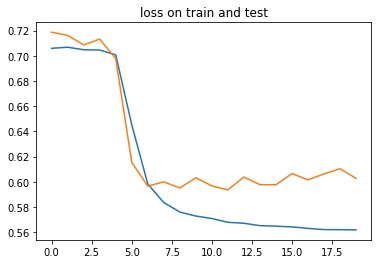

Last loss on train: 0.5618464994219552
Last loss on test: 0.6027367420886692


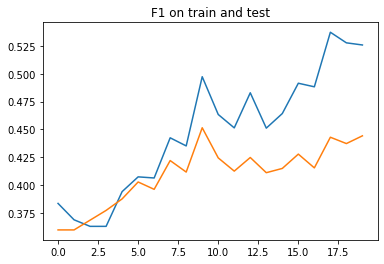

Last F1 on train: 0.5259387613134047
Last F1 on test: 0.4441632855879633


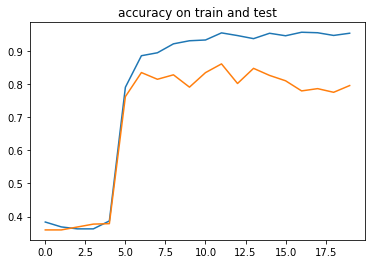

Last accuracy on train: 0.9540444038874281
Last accuracy on test: 0.7959024553236208


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.8240606186423085


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

also-B gut-I .-O
--O scheiß-B drauf-I .-O
nein-O ,-O schon-B gut-I .-O
--O ich-B auf-I jeden-I fall-I .-O
--O schon-B gut-I .-O
machst-B du-I witze-I ?-O
--O ist-B schon-I gut-I .-O
nicht-B wahr-I ,-O trey-O ?-O
--O mit-B vergnügen-I .-O
na-B und-I ?-O
keine-B ahnung-I .-O
--O hör-B auf-I .-O
--O das-B stimmt-I nicht-I .-O
na-B und-I ?-O
--O das-B passt-I .-O
--O ist-B ja-I schon-I gut-I .-O
ja-O ,-O ich-B glaube-I schon-I .-O
madame-O kali-O ,-O nicht-B wahr-I ?-O
was-B du-I nicht-I sagst-I .-O
na-B schön-I ,-O aber-O als-O jemand-O ,-O dem-O etwas-O an-O dir-O liegt-O ,-O sag-O ich-O dir-O :-O --O du-O hast-O ernste-O probleme-O mit-O männern-O .-O
keine-B ahnung-I .-O
ich-B glaub-I nicht-I .-O
du-O weißt-O doch-O ,-O dass-O ich-O das-O nicht-O mit-O absicht-O gema-O ...-O ja-O ,-O schon-B klar-I .-O
wir-O kommen-O alle-O ,-O stimmt-B 's-I ?-O
--O keine-B ahnung-I .-O
ja-O ,-O gute-B idee-I .-O
lhr-O kennt-O doch-O meinen-O vater-O ,-O stimmt-B 's-I ?-O
--O ich-B weiß-I .-O
ja-O ,-O 

# Experiment 1, testing layers
* GRU
* uni
* 1 cell
* 2 layer
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = GRU(vocab_size=len(word2id), num_layers=2, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.005, 1, 1])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


48it [00:02, 19.89it/s]

Train loss: 0.7095243745379978


92it [00:04, 15.46it/s]

Train loss: 0.6953414049413469


137it [00:07, 20.65it/s]

Train loss: 0.7008364253573948


182it [00:09, 20.82it/s]

Train loss: 0.7050287028153738


226it [00:11, 19.63it/s]


Train loss: 0.7062625731362236

Evaluating on train...


49it [00:01, 40.91it/s]

Val loss: 0.7061603479915195, Val f1: 0.33317197627491424, Val accuracy: 0.3333333432674408


94it [00:02, 41.17it/s]

Val loss: 0.7094831327597301, Val f1: 0.34798100656933256, Val accuracy: 0.34814815786149766


139it [00:03, 40.89it/s]

Val loss: 0.7030794960481149, Val f1: 0.3628041260772281, Val accuracy: 0.36296297245555453


187it [00:04, 37.82it/s]

Val loss: 0.7073473748233583, Val f1: 0.35539255258109836, Val accuracy: 0.3555555651585261


226it [00:05, 39.63it/s]


Val loss: 0.7068195107248094, Val f1: 0.35391177905930415, Val accuracy: 0.3540740836991204

Evaluating on test...


20it [00:00, 36.98it/s]

Val loss: 0.6899466355641682, Val f1: 0.42207977374394734, Val accuracy: 0.422222230831782


36it [00:00, 36.88it/s]

Val loss: 0.7189554989337921, Val f1: 0.37759657899538673, Val accuracy: 0.3777777870496114


53it [00:01, 38.53it/s]

Val loss: 0.7170037123892042, Val f1: 0.37759821944766575, Val accuracy: 0.3777777870496114


66it [00:01, 38.87it/s]

Val loss: 0.7148589511712392, Val f1: 0.3664912283420563, Val accuracy: 0.3666666761040688


76it [00:02, 37.78it/s]


Val loss: 0.7106395649909973, Val f1: 0.3776079861323039, Val accuracy: 0.3777777870496114

starting Epoch 1
Training...


48it [00:02, 20.48it/s]

Train loss: 0.6973469283845689


93it [00:04, 22.27it/s]

Train loss: 0.696627363231447


138it [00:06, 21.70it/s]

Train loss: 0.7020372748374939


182it [00:08, 20.39it/s]

Train loss: 0.7005714644988378


226it [00:10, 20.93it/s]


Train loss: 0.7046861714786954

Evaluating on train...


53it [00:01, 40.73it/s]

Val loss: 0.7072770184940762, Val f1: 0.36279696557256913, Val accuracy: 0.36296297245555453


93it [00:02, 41.74it/s]

Val loss: 0.7169989082548354, Val f1: 0.35537719627221426, Val accuracy: 0.3555555651585261


142it [00:03, 37.63it/s]

Val loss: 0.7104595599351106, Val f1: 0.36773053540123835, Val accuracy: 0.3679012439869068


185it [00:04, 39.64it/s]

Val loss: 0.7048866440852483, Val f1: 0.3702071683274375, Val accuracy: 0.37037037975258297


226it [00:05, 39.82it/s]


Val loss: 0.7047207061449686, Val f1: 0.37761523789829676, Val accuracy: 0.3777777870496114

Evaluating on test...


19it [00:00, 41.60it/s]

Val loss: 0.7463999549547832, Val f1: 0.33312209844589236, Val accuracy: 0.3333333432674408


34it [00:00, 39.87it/s]

Val loss: 0.7175885955492656, Val f1: 0.35538008908430735, Val accuracy: 0.3555555651585261


51it [00:01, 38.87it/s]

Val loss: 0.7152391129069858, Val f1: 0.34797495736016165, Val accuracy: 0.34814815786149766


64it [00:01, 39.06it/s]

Val loss: 0.710906770825386, Val f1: 0.3664972851673762, Val accuracy: 0.3666666761040688


76it [00:01, 38.32it/s]


Val loss: 0.7122524309158326, Val f1: 0.3687189515431722, Val accuracy: 0.3688888982931773

starting Epoch 2
Training...


47it [00:02, 21.64it/s]

Train loss: 0.7054307275348239


92it [00:04, 21.48it/s]

Train loss: 0.6919072674380409


137it [00:06, 21.92it/s]

Train loss: 0.7038525002974051


183it [00:09, 19.73it/s]

Train loss: 0.7045147740178638


226it [00:11, 20.49it/s]


Train loss: 0.7029424773322211

Evaluating on train...


50it [00:01, 41.00it/s]

Val loss: 0.7113208346896701, Val f1: 0.3924253377649519, Val accuracy: 0.39259260164366827


95it [00:02, 34.59it/s]

Val loss: 0.7024965756469302, Val f1: 0.3702136715253194, Val accuracy: 0.37037037975258297


137it [00:04, 16.41it/s]

Val loss: 0.7082063727908664, Val f1: 0.3627978457344903, Val accuracy: 0.36296297245555453


187it [00:05, 38.07it/s]

Val loss: 0.7048745373884837, Val f1: 0.36650510181983315, Val accuracy: 0.3666666761040688


226it [00:06, 33.25it/s]


Val loss: 0.7062242616547478, Val f1: 0.36872512009408737, Val accuracy: 0.3688888982931773

Evaluating on test...


20it [00:00, 37.22it/s]

Val loss: 0.7318251649538676, Val f1: 0.3331413129965464, Val accuracy: 0.3333333432674408


36it [00:00, 38.07it/s]

Val loss: 0.7256038248538971, Val f1: 0.3553717344999313, Val accuracy: 0.3555555651585261


47it [00:01, 25.10it/s]

Val loss: 0.7283138049973382, Val f1: 0.34796040654182436, Val accuracy: 0.34814815786149766


61it [00:02, 13.52it/s]

Val loss: 0.714227893948555, Val f1: 0.35538532336552936, Val accuracy: 0.3555555651585261


76it [00:03, 20.22it/s]


Val loss: 0.7148436347643534, Val f1: 0.35094037135442097, Val accuracy: 0.35111112078030904

starting Epoch 3
Training...


48it [00:03, 16.75it/s]

Train loss: 0.6917147278785706


93it [00:05, 21.11it/s]

Train loss: 0.7030580626593695


138it [00:07, 22.35it/s]

Train loss: 0.7037879321310255


183it [00:09, 21.73it/s]

Train loss: 0.6987128204769558


226it [00:11, 19.06it/s]


Train loss: 0.6954370292027792

Evaluating on train...


50it [00:01, 41.11it/s]

Val loss: 0.6693708512518141, Val f1: 0.3516497181521522, Val accuracy: 0.5485187702708774


95it [00:02, 40.53it/s]

Val loss: 0.663855720228619, Val f1: 0.3577034271425671, Val accuracy: 0.5493767357534832


140it [00:03, 40.57it/s]

Val loss: 0.6723148606441639, Val f1: 0.3532167183028327, Val accuracy: 0.5323556906647152


186it [00:04, 40.20it/s]

Val loss: 0.67345905204614, Val f1: 0.35211434463659924, Val accuracy: 0.5372421561015976


226it [00:05, 40.38it/s]


Val loss: 0.6765486118528578, Val f1: 0.35148305482334563, Val accuracy: 0.5392633500364091

Evaluating on test...


21it [00:00, 38.92it/s]

Val loss: 0.6718180457750956, Val f1: 0.3490976651509603, Val accuracy: 0.519708142677943


37it [00:00, 38.86it/s]

Val loss: 0.671604323387146, Val f1: 0.35803426504135133, Val accuracy: 0.5443226506312688


51it [00:01, 39.73it/s]

Val loss: 0.6798550844192505, Val f1: 0.3523847593201531, Val accuracy: 0.537600666946835


64it [00:01, 39.03it/s]

Val loss: 0.6788139601548513, Val f1: 0.352070759733518, Val accuracy: 0.5293581187725067


76it [00:01, 39.30it/s]


Val loss: 0.6837744275728862, Val f1: 0.34971911629041036, Val accuracy: 0.5314355079332987

starting Epoch 4
Training...


48it [00:02, 22.02it/s]

Train loss: 0.6981509420606825


93it [00:04, 21.27it/s]

Train loss: 0.6884499026669396


138it [00:06, 21.59it/s]

Train loss: 0.6792198737462362


183it [00:08, 22.33it/s]

Train loss: 0.6775815119345983


226it [00:10, 21.36it/s]


Train loss: 0.6730340268876818

Evaluating on train...


49it [00:01, 41.70it/s]

Val loss: 0.7242567976315816, Val f1: 0.36090653472476536, Val accuracy: 0.58690328862932


94it [00:02, 40.86it/s]

Val loss: 0.7189399427837796, Val f1: 0.3606452484925588, Val accuracy: 0.5918562057945463


140it [00:03, 38.40it/s]

Val loss: 0.715733054832176, Val f1: 0.3615285429689619, Val accuracy: 0.5808438382766865


185it [00:04, 38.34it/s]

Val loss: 0.7164273798465729, Val f1: 0.36247834497027925, Val accuracy: 0.5825747842590014


226it [00:06, 37.57it/s]


Val loss: 0.7169150344530741, Val f1: 0.3617849091688792, Val accuracy: 0.5791280278894636

Evaluating on test...


21it [00:00, 38.94it/s]

Val loss: 0.7127233465512594, Val f1: 0.3539588749408722, Val accuracy: 0.6093540608882904


38it [00:00, 39.18it/s]

Val loss: 0.718051544825236, Val f1: 0.36047374407450355, Val accuracy: 0.5778065900007884


51it [00:01, 38.89it/s]

Val loss: 0.721728363302019, Val f1: 0.3579669780201382, Val accuracy: 0.5684889958964454


64it [00:01, 39.01it/s]

Val loss: 0.7240795731544495, Val f1: 0.35813579658667244, Val accuracy: 0.5718540539344151


76it [00:01, 38.92it/s]


Val loss: 0.7229221169153849, Val f1: 0.3550008662541707, Val accuracy: 0.5630529642105102

starting Epoch 5
Training...


48it [00:02, 20.95it/s]

Train loss: 0.6813444839583502


92it [00:04, 20.35it/s]

Train loss: 0.672611399491628


137it [00:06, 22.70it/s]

Train loss: 0.6629323447192157


182it [00:08, 20.79it/s]

Train loss: 0.6464965946144527


226it [00:10, 21.44it/s]


Train loss: 0.6365199126137627

Evaluating on train...


50it [00:01, 38.72it/s]

Val loss: 0.5976707922087775, Val f1: 0.41014784773190816, Val accuracy: 0.8223800003528595


97it [00:02, 39.91it/s]

Val loss: 0.5936793598863813, Val f1: 0.39973495768176187, Val accuracy: 0.8226000626881917


141it [00:03, 39.59it/s]

Val loss: 0.5943512620749297, Val f1: 0.4034368919001685, Val accuracy: 0.8458257842946936


186it [00:04, 38.10it/s]

Val loss: 0.5958790183067322, Val f1: 0.4044265993767314, Val accuracy: 0.8418516862723563


226it [00:05, 38.62it/s]


Val loss: 0.5944170151816474, Val f1: 0.40456957472695243, Val accuracy: 0.8488121106889512

Evaluating on test...


20it [00:00, 37.39it/s]

Val loss: 0.633067770799001, Val f1: 0.3985712190469106, Val accuracy: 0.7917014122009277


36it [00:00, 36.99it/s]

Val loss: 0.6290596564610799, Val f1: 0.3943498214085897, Val accuracy: 0.7929833571116129


52it [00:01, 37.48it/s]

Val loss: 0.6184795498847961, Val f1: 0.3924011992083655, Val accuracy: 0.8217937482727898


64it [00:01, 36.63it/s]

Val loss: 0.6183729698260625, Val f1: 0.39472963015238444, Val accuracy: 0.8201817899942399


76it [00:02, 36.81it/s]


Val loss: 0.6153790386517842, Val f1: 0.39313620487848916, Val accuracy: 0.8159618564446767

starting Epoch 6
Training...


49it [00:02, 22.34it/s]

Train loss: 0.5937084873517354


94it [00:04, 22.14it/s]

Train loss: 0.5945853405528598


139it [00:06, 20.88it/s]

Train loss: 0.5962007460770784


182it [00:08, 21.53it/s]

Train loss: 0.594942577679952


226it [00:10, 20.74it/s]


Train loss: 0.5929027321603563

Evaluating on train...


46it [00:01, 17.82it/s]

Val loss: 0.5867579221725464, Val f1: 0.42118861675262453, Val accuracy: 0.8134669992658827


95it [00:04, 27.54it/s]

Val loss: 0.5855621271663242, Val f1: 0.4238806598716312, Val accuracy: 0.8489089727401733


140it [00:06, 37.21it/s]

Val loss: 0.5856204686341462, Val f1: 0.42864451783674734, Val accuracy: 0.8557122197416094


184it [00:07, 37.24it/s]

Val loss: 0.5848861985736423, Val f1: 0.4286606159475115, Val accuracy: 0.8596408037675751


226it [00:08, 26.99it/s]


Val loss: 0.5834444332122802, Val f1: 0.42969746735360886, Val accuracy: 0.8633153390884399

Evaluating on test...


21it [00:00, 38.69it/s]

Val loss: 0.5915457129478454, Val f1: 0.42339784105618794, Val accuracy: 0.8856440901756286


38it [00:00, 39.40it/s]

Val loss: 0.5948931713898976, Val f1: 0.4168671508630117, Val accuracy: 0.8557979434728622


51it [00:01, 38.96it/s]

Val loss: 0.5973849866125319, Val f1: 0.4178949144151476, Val accuracy: 0.8377563410335117


67it [00:01, 37.39it/s]

Val loss: 0.6053995380798975, Val f1: 0.42005407214164736, Val accuracy: 0.8212123503287633


76it [00:01, 38.52it/s]


Val loss: 0.6070031881332397, Val f1: 0.41272087971369426, Val accuracy: 0.7982546122868855

starting Epoch 7
Training...


47it [00:02, 20.12it/s]

Train loss: 0.5804319183031718


92it [00:04, 22.08it/s]

Train loss: 0.5864675574832492


138it [00:06, 17.93it/s]

Train loss: 0.5858529907685739


182it [00:09, 16.55it/s]

Train loss: 0.584281411435869


226it [00:11, 19.61it/s]


Train loss: 0.584620369275411

Evaluating on train...


50it [00:01, 39.35it/s]

Val loss: 0.5747871544626024, Val f1: 0.41282502743932936, Val accuracy: 0.9423444595601823


92it [00:02, 32.45it/s]

Val loss: 0.575449585252338, Val f1: 0.4187943395641115, Val accuracy: 0.9189124829239316


141it [00:04, 28.91it/s]

Val loss: 0.5749220896650243, Val f1: 0.4193814498406869, Val accuracy: 0.9105136339311246


185it [00:05, 36.24it/s]

Val loss: 0.5754529982805252, Val f1: 0.41652582652039, Val accuracy: 0.903385846151246


226it [00:06, 33.27it/s]


Val loss: 0.5768853245841132, Val f1: 0.4169236167271932, Val accuracy: 0.9067648657162984

Evaluating on test...


20it [00:00, 37.02it/s]

Val loss: 0.5978118022282918, Val f1: 0.3904797991116842, Val accuracy: 0.8225574413935344


36it [00:00, 36.90it/s]

Val loss: 0.6001314461231232, Val f1: 0.4069058895111084, Val accuracy: 0.8546732385953267


52it [00:01, 37.17it/s]

Val loss: 0.5990212771627638, Val f1: 0.4001633961995443, Val accuracy: 0.8368833992216322


64it [00:01, 37.39it/s]

Val loss: 0.5934158275524776, Val f1: 0.3990807463725408, Val accuracy: 0.8501958017547925


76it [00:02, 37.15it/s]


Val loss: 0.5951724179585774, Val f1: 0.40233364661534626, Val accuracy: 0.8543921339511872

starting Epoch 8
Training...


48it [00:02, 22.79it/s]

Train loss: 0.5783078061209784


93it [00:04, 20.29it/s]

Train loss: 0.5808248009946612


139it [00:06, 22.29it/s]

Train loss: 0.5824354648590088


184it [00:08, 19.90it/s]

Train loss: 0.5810807542668448


226it [00:10, 21.10it/s]


Train loss: 0.5797139037979974

Evaluating on train...


51it [00:01, 38.68it/s]

Val loss: 0.577246081829071, Val f1: 0.4589214437537723, Val accuracy: 0.8968258327907986


96it [00:02, 40.01it/s]

Val loss: 0.5751600596639845, Val f1: 0.4556757026248508, Val accuracy: 0.9051031549771626


140it [00:03, 38.53it/s]

Val loss: 0.5745439909122608, Val f1: 0.45479204875451545, Val accuracy: 0.9045468191305797


184it [00:04, 37.67it/s]

Val loss: 0.5745197570986218, Val f1: 0.45324008233017393, Val accuracy: 0.9083597443170017


226it [00:05, 38.16it/s]


Val loss: 0.5749323929680719, Val f1: 0.4529249021742079, Val accuracy: 0.9101799992720286

Evaluating on test...


22it [00:00, 38.85it/s]

Val loss: 0.6126055081685384, Val f1: 0.4225990871588389, Val accuracy: 0.7593035439650218


34it [00:00, 38.14it/s]

Val loss: 0.6051955858866374, Val f1: 0.42013013958930967, Val accuracy: 0.8111586918433508


50it [00:01, 38.60it/s]

Val loss: 0.5984131442175971, Val f1: 0.42884389294518366, Val accuracy: 0.8291049579779307


66it [00:01, 37.10it/s]

Val loss: 0.5986214776833853, Val f1: 0.4267658511797587, Val accuracy: 0.8164083068569501


76it [00:02, 37.91it/s]


Val loss: 0.5978224500020345, Val f1: 0.4258872417608897, Val accuracy: 0.8041577474276225

starting Epoch 9
Training...


48it [00:02, 21.23it/s]

Train loss: 0.5748038119739957


92it [00:04, 19.81it/s]

Train loss: 0.5742805593543583


137it [00:06, 20.66it/s]

Train loss: 0.577534681779367


182it [00:08, 21.11it/s]

Train loss: 0.5792149911324184


226it [00:10, 20.87it/s]


Train loss: 0.5786140788926019

Evaluating on train...


50it [00:01, 37.03it/s]

Val loss: 0.5790495223469204, Val f1: 0.476242509815428, Val accuracy: 0.8973315192593468


96it [00:02, 37.60it/s]

Val loss: 0.5762998766369289, Val f1: 0.46926046113173164, Val accuracy: 0.9064581794871225


140it [00:03, 35.65it/s]

Val loss: 0.5755241208606297, Val f1: 0.4701024572054545, Val accuracy: 0.9122342116302914


184it [00:04, 37.90it/s]

Val loss: 0.5757615208625794, Val f1: 0.46858654071887335, Val accuracy: 0.9040999190674888


226it [00:06, 37.27it/s]


Val loss: 0.5746523920694987, Val f1: 0.4676737071408166, Val accuracy: 0.9004605069425371

Evaluating on test...


20it [00:00, 36.11it/s]

Val loss: 0.5942244450251262, Val f1: 0.4335050682226817, Val accuracy: 0.8389029582341512


36it [00:01, 35.46it/s]

Val loss: 0.5988789816697438, Val f1: 0.44479709963003794, Val accuracy: 0.8331189701954523


52it [00:01, 36.50it/s]

Val loss: 0.6019268459743924, Val f1: 0.4379184001021915, Val accuracy: 0.8071103983455234


64it [00:01, 36.06it/s]

Val loss: 0.5997327049573262, Val f1: 0.43714372515678407, Val accuracy: 0.8183226456244787


76it [00:02, 36.26it/s]


Val loss: 0.6048698433240255, Val f1: 0.43514788428942364, Val accuracy: 0.8121970057487488

starting Epoch 10
Training...


49it [00:02, 21.59it/s]

Train loss: 0.5754909859763251


94it [00:04, 21.66it/s]

Train loss: 0.576928006278144


139it [00:06, 20.81it/s]

Train loss: 0.5772798794287223


182it [00:08, 22.54it/s]

Train loss: 0.5770773980352614


226it [00:10, 21.23it/s]


Train loss: 0.5774348611301846

Evaluating on train...


49it [00:01, 38.98it/s]

Val loss: 0.5690438005659315, Val f1: 0.46406477755970427, Val accuracy: 0.9192727453178829


94it [00:02, 37.77it/s]

Val loss: 0.570488965511322, Val f1: 0.4631374359130859, Val accuracy: 0.9173004769616657


142it [00:03, 38.46it/s]

Val loss: 0.5708273949446502, Val f1: 0.45929933455255295, Val accuracy: 0.9141105205924422


184it [00:04, 38.86it/s]

Val loss: 0.5714307596286138, Val f1: 0.45611935870514975, Val accuracy: 0.9138491266303592


226it [00:05, 38.54it/s]


Val loss: 0.5720262903637356, Val f1: 0.4578793594572279, Val accuracy: 0.9185307304064433

Evaluating on test...


20it [00:00, 37.67it/s]

Val loss: 0.6130595962206523, Val f1: 0.41831776897112527, Val accuracy: 0.7543444593747457


37it [00:00, 39.39it/s]

Val loss: 0.6089826663335164, Val f1: 0.42623501320679985, Val accuracy: 0.8024904787540436


45it [00:01, 38.01it/s]

Val loss: 0.6050053755442302, Val f1: 0.4283606794145372, Val accuracy: 0.8212370541360643


65it [00:02, 29.10it/s]

Val loss: 0.6068282395601272, Val f1: 0.4241025676329931, Val accuracy: 0.8005956674615542


76it [00:02, 32.07it/s]


Val loss: 0.6074629712104798, Val f1: 0.42582887649536133, Val accuracy: 0.8045277941226959

starting Epoch 11
Training...


47it [00:02, 21.62it/s]

Train loss: 0.5724738717079163


92it [00:04, 20.85it/s]

Train loss: 0.5711720870600806


137it [00:06, 20.92it/s]

Train loss: 0.5705772788436324


182it [00:08, 20.54it/s]

Train loss: 0.5725339611371358


226it [00:10, 21.12it/s]


Train loss: 0.5739805669254727

Evaluating on train...


52it [00:01, 39.33it/s]

Val loss: 0.5788069950209723, Val f1: 0.39794444905387033, Val accuracy: 0.945596104198032


94it [00:02, 39.59it/s]

Val loss: 0.5740009526411692, Val f1: 0.3993053747547997, Val accuracy: 0.9521426455842124


139it [00:03, 40.56it/s]

Val loss: 0.5719664299929583, Val f1: 0.4014894993216903, Val accuracy: 0.9606352940753654


187it [00:04, 38.38it/s]

Val loss: 0.5718428237570656, Val f1: 0.4016930553648207, Val accuracy: 0.95960041516357


226it [00:05, 39.14it/s]


Val loss: 0.5725729107856751, Val f1: 0.4006575564543406, Val accuracy: 0.9515247780746884

Evaluating on test...


20it [00:00, 36.85it/s]

Val loss: 0.5924294869105021, Val f1: 0.38032580812772115, Val accuracy: 0.8726537068684895


36it [00:00, 38.23it/s]

Val loss: 0.5946716984113057, Val f1: 0.38159848550955455, Val accuracy: 0.866829001903534


52it [00:01, 36.96it/s]

Val loss: 0.5912170714802212, Val f1: 0.38294229639901056, Val accuracy: 0.8691103855768839


64it [00:01, 37.21it/s]

Val loss: 0.5928595890601476, Val f1: 0.38441142241160076, Val accuracy: 0.8621080612142881


76it [00:02, 37.79it/s]


Val loss: 0.5924180857340495, Val f1: 0.3849880798657735, Val accuracy: 0.8731901363531749

starting Epoch 12
Training...


49it [00:02, 20.40it/s]

Train loss: 0.5700928436385261


94it [00:04, 22.53it/s]

Train loss: 0.5702379054493374


139it [00:06, 22.90it/s]

Train loss: 0.5725408253846345


184it [00:08, 22.38it/s]

Train loss: 0.572898484269778


226it [00:10, 20.79it/s]


Train loss: 0.5733140762646993

Evaluating on train...


53it [00:01, 39.17it/s]

Val loss: 0.5771996378898621, Val f1: 0.3797371983528137, Val accuracy: 0.9180641174316406


94it [00:02, 40.88it/s]

Val loss: 0.576461562845442, Val f1: 0.3837623980310228, Val accuracy: 0.9384249094459746


142it [00:03, 37.39it/s]

Val loss: 0.5761780937512716, Val f1: 0.38511370199697986, Val accuracy: 0.9357987701892853


183it [00:04, 37.91it/s]

Val loss: 0.5758469661076864, Val f1: 0.3849250425895055, Val accuracy: 0.9303483625253042


226it [00:05, 38.69it/s]


Val loss: 0.575179033809238, Val f1: 0.38527498192257353, Val accuracy: 0.9332798670397865

Evaluating on test...


21it [00:00, 38.42it/s]

Val loss: 0.5979018568992615, Val f1: 0.3699758330980937, Val accuracy: 0.8711260259151459


37it [00:00, 37.48it/s]

Val loss: 0.5959883709748586, Val f1: 0.3706770002841949, Val accuracy: 0.8633801092704138


49it [00:01, 36.72it/s]

Val loss: 0.5933167272143893, Val f1: 0.3723493026362525, Val accuracy: 0.8648916622002919


65it [00:01, 36.95it/s]

Val loss: 0.589438350001971, Val f1: 0.37370717177788415, Val accuracy: 0.8736350908875465


76it [00:02, 37.32it/s]


Val loss: 0.5910697746276855, Val f1: 0.373457951148351, Val accuracy: 0.8709417871634165

starting Epoch 13
Training...


48it [00:02, 21.91it/s]

Train loss: 0.5667829910914103


93it [00:04, 21.79it/s]

Train loss: 0.5695111612478893


138it [00:06, 20.87it/s]

Train loss: 0.5697280548236988


183it [00:08, 21.44it/s]

Train loss: 0.5708983139859305


226it [00:10, 21.27it/s]


Train loss: 0.5708756664064195

Evaluating on train...


52it [00:01, 39.18it/s]

Val loss: 0.5641466551356845, Val f1: 0.4651044375366635, Val accuracy: 0.9155816780196295


97it [00:02, 38.97it/s]

Val loss: 0.5644065366850959, Val f1: 0.46679904990726045, Val accuracy: 0.9332954075601366


140it [00:03, 39.78it/s]

Val loss: 0.564715121852027, Val f1: 0.4699410769674513, Val accuracy: 0.9281789282957713


187it [00:04, 37.68it/s]

Val loss: 0.5664249632093642, Val f1: 0.47320547368791366, Val accuracy: 0.9288350414898661


226it [00:05, 38.89it/s]


Val loss: 0.5663607080777486, Val f1: 0.47208814289834766, Val accuracy: 0.9325628148184882

Evaluating on test...


21it [00:00, 36.57it/s]

Val loss: 0.6097466468811035, Val f1: 0.4233305295308431, Val accuracy: 0.7783971150716146


37it [00:01, 35.27it/s]

Val loss: 0.608468872308731, Val f1: 0.4337738742431005, Val accuracy: 0.7881576279799144


49it [00:01, 35.51it/s]

Val loss: 0.6040446188714769, Val f1: 0.42520871493551465, Val accuracy: 0.7624514453940922


65it [00:01, 37.12it/s]

Val loss: 0.6026278118292491, Val f1: 0.4211438874403636, Val accuracy: 0.7651064162453015


76it [00:02, 36.47it/s]


Val loss: 0.6019721134503683, Val f1: 0.42589622100194297, Val accuracy: 0.784908777475357

starting Epoch 14
Training...


47it [00:02, 22.03it/s]

Train loss: 0.5673253112369113


92it [00:04, 22.60it/s]

Train loss: 0.567722761631012


137it [00:06, 20.59it/s]

Train loss: 0.5682385298940871


181it [00:08, 20.48it/s]

Train loss: 0.5688009351491928


226it [00:10, 21.12it/s]


Train loss: 0.5695330437024434

Evaluating on train...


49it [00:01, 40.15it/s]

Val loss: 0.5660972581969367, Val f1: 0.4252619180414412, Val accuracy: 0.9540860500600603


97it [00:02, 39.91it/s]

Val loss: 0.5678258836269379, Val f1: 0.42419682178232404, Val accuracy: 0.9430585169129901


141it [00:03, 39.21it/s]

Val loss: 0.5674611877512049, Val f1: 0.420965752336714, Val accuracy: 0.9416584460823624


186it [00:04, 36.32it/s]

Val loss: 0.5679092397292455, Val f1: 0.42351947277784346, Val accuracy: 0.9487852262126075


226it [00:05, 38.75it/s]


Val loss: 0.5691980873213874, Val f1: 0.4223633541001214, Val accuracy: 0.9426436575253805

Evaluating on test...


20it [00:00, 37.79it/s]

Val loss: 0.6064813653628032, Val f1: 0.38570788701375325, Val accuracy: 0.7412207325299581


36it [00:00, 37.66it/s]

Val loss: 0.6024505436420441, Val f1: 0.381166136264801, Val accuracy: 0.7502605398495992


49it [00:01, 38.33it/s]

Val loss: 0.5979093445671929, Val f1: 0.38898872203297086, Val accuracy: 0.7923597282833523


65it [00:01, 37.61it/s]

Val loss: 0.5987183451652527, Val f1: 0.3900239780545235, Val accuracy: 0.8024216731389363


76it [00:01, 38.18it/s]


Val loss: 0.5985988163948059, Val f1: 0.3913529578844706, Val accuracy: 0.8165931049982706

starting Epoch 15
Training...


48it [00:02, 21.53it/s]

Train loss: 0.5705583506160312


93it [00:04, 21.66it/s]

Train loss: 0.5709900180498759


138it [00:06, 21.38it/s]

Train loss: 0.5717797389736882


182it [00:08, 21.15it/s]

Train loss: 0.5727948632505205


226it [00:10, 21.17it/s]


Train loss: 0.5727664947509765

Evaluating on train...


50it [00:01, 41.13it/s]

Val loss: 0.5659708499908447, Val f1: 0.42335055801603527, Val accuracy: 0.9502510209878285


94it [00:02, 38.21it/s]

Val loss: 0.5665930132071177, Val f1: 0.42425166732735103, Val accuracy: 0.9516281363036897


143it [00:03, 40.61it/s]

Val loss: 0.5671741600389834, Val f1: 0.42307457085008976, Val accuracy: 0.9478648424148559


187it [00:04, 39.13it/s]

Val loss: 0.5687717729144626, Val f1: 0.4214884120557043, Val accuracy: 0.9426113433308072


226it [00:05, 40.05it/s]


Val loss: 0.5683217154608833, Val f1: 0.4200571404563056, Val accuracy: 0.937963355647193

Evaluating on test...


21it [00:00, 40.26it/s]

Val loss: 0.5975094000498454, Val f1: 0.39817861715952557, Val accuracy: 0.8922103047370911


34it [00:00, 39.04it/s]

Val loss: 0.6001971562703451, Val f1: 0.3958489457766215, Val accuracy: 0.8514426330725352


52it [00:01, 39.42it/s]

Val loss: 0.5962324791484409, Val f1: 0.395654508140352, Val accuracy: 0.868482870525784


66it [00:01, 39.16it/s]

Val loss: 0.595603021979332, Val f1: 0.39693601032098136, Val accuracy: 0.8654353241125743


76it [00:01, 39.31it/s]


Val loss: 0.5953438218434651, Val f1: 0.3918035121758779, Val accuracy: 0.8593373076121013

starting Epoch 16
Training...


47it [00:02, 22.35it/s]

Train loss: 0.5665155450503031


92it [00:04, 21.79it/s]

Train loss: 0.5686212956905365


137it [00:06, 21.37it/s]

Train loss: 0.5692310518688626


182it [00:08, 22.50it/s]

Train loss: 0.5697345929013358


226it [00:10, 21.24it/s]


Train loss: 0.5694180509779189

Evaluating on train...


50it [00:01, 41.39it/s]

Val loss: 0.5623799429999458, Val f1: 0.4748522771729363, Val accuracy: 0.9609270870685578


95it [00:02, 39.72it/s]

Val loss: 0.5634927246305678, Val f1: 0.46692127784093224, Val accuracy: 0.9414394170045852


143it [00:03, 40.83it/s]

Val loss: 0.5647118400644373, Val f1: 0.46410568842181454, Val accuracy: 0.9403711948129866


186it [00:04, 40.22it/s]

Val loss: 0.5658409923315049, Val f1: 0.45980885492430795, Val accuracy: 0.9389448944065306


226it [00:05, 39.96it/s]


Val loss: 0.5659174015786913, Val f1: 0.4638043271170722, Val accuracy: 0.9437948571311103

Evaluating on test...


21it [00:00, 38.08it/s]

Val loss: 0.5919902920722961, Val f1: 0.4302549481391907, Val accuracy: 0.860799769560496


37it [00:00, 38.08it/s]

Val loss: 0.5984677195549011, Val f1: 0.4181230902671814, Val accuracy: 0.8313895086447398


51it [00:01, 39.05it/s]

Val loss: 0.5999836842219035, Val f1: 0.4151768982410431, Val accuracy: 0.814570982588662


67it [00:01, 37.99it/s]

Val loss: 0.6008583913246791, Val f1: 0.4164918099840482, Val accuracy: 0.8155613824725151


76it [00:01, 38.03it/s]


Val loss: 0.6015157008171081, Val f1: 0.4142500392595927, Val accuracy: 0.8095009247461955

starting Epoch 17
Training...


47it [00:02, 16.91it/s]

Train loss: 0.568972815407647


94it [00:04, 21.30it/s]

Train loss: 0.5680225643846724


139it [00:06, 22.01it/s]

Train loss: 0.5676684975624084


183it [00:08, 21.55it/s]

Train loss: 0.5695181674427456


226it [00:10, 20.67it/s]


Train loss: 0.5694264263576931

Evaluating on train...


49it [00:01, 38.45it/s]

Val loss: 0.5671977016660902, Val f1: 0.4514742546611362, Val accuracy: 0.9723703132735358


96it [00:02, 40.50it/s]

Val loss: 0.5671041614479488, Val f1: 0.4322037524647183, Val accuracy: 0.9356946008072959


140it [00:03, 40.55it/s]

Val loss: 0.566035743995949, Val f1: 0.43184162599069104, Val accuracy: 0.9352379410355179


181it [00:04, 23.49it/s]

Val loss: 0.5655908809767829, Val f1: 0.4300947671135267, Val accuracy: 0.9375865292217996


226it [00:06, 36.88it/s]


Val loss: 0.5662438013818529, Val f1: 0.43182354980044896, Val accuracy: 0.9389081105921003

Evaluating on test...


20it [00:00, 38.48it/s]

Val loss: 0.5927031993865967, Val f1: 0.39304753541946413, Val accuracy: 0.8681521852811177


36it [00:00, 37.94it/s]

Val loss: 0.5936522324879964, Val f1: 0.3924414336681366, Val accuracy: 0.8567354500293731


52it [00:01, 37.65it/s]

Val loss: 0.596855444378323, Val f1: 0.392923276954227, Val accuracy: 0.8423697266313764


65it [00:01, 39.02it/s]

Val loss: 0.5990222295125326, Val f1: 0.3947548766930898, Val accuracy: 0.8331876819332441


76it [00:01, 38.44it/s]


Val loss: 0.596417997678121, Val f1: 0.39545283993085223, Val accuracy: 0.8343884539604187

starting Epoch 18
Training...


48it [00:02, 22.11it/s]

Train loss: 0.5672548863622877


93it [00:04, 20.90it/s]

Train loss: 0.5683743377526601


137it [00:06, 22.23it/s]

Train loss: 0.5695876986892136


182it [00:08, 22.69it/s]

Train loss: 0.5678179562091827


226it [00:10, 21.34it/s]


Train loss: 0.5680023815896776

Evaluating on train...


50it [00:01, 41.11it/s]

Val loss: 0.563033660252889, Val f1: 0.5092740337053935, Val accuracy: 0.9415747986899482


95it [00:02, 40.48it/s]

Val loss: 0.5664600948492686, Val f1: 0.5153173016177284, Val accuracy: 0.9274571173720889


142it [00:03, 38.83it/s]

Val loss: 0.566638813636921, Val f1: 0.5177451102821915, Val accuracy: 0.9304164151350657


187it [00:04, 38.17it/s]

Val loss: 0.5662808570596907, Val f1: 0.5154067307710648, Val accuracy: 0.9304663838611709


226it [00:05, 39.05it/s]


Val loss: 0.5656464131673177, Val f1: 0.5171045339107514, Val accuracy: 0.93731140560574

Evaluating on test...


22it [00:00, 40.65it/s]

Val loss: 0.5960524876912435, Val f1: 0.4264565110206604, Val accuracy: 0.7934555192788442


36it [00:00, 40.51it/s]

Val loss: 0.6087404270966847, Val f1: 0.43057722548643745, Val accuracy: 0.7556293110052744


50it [00:01, 39.84it/s]

Val loss: 0.6149852487776014, Val f1: 0.43737406465742323, Val accuracy: 0.7503591544098325


66it [00:01, 38.40it/s]

Val loss: 0.6091973255077998, Val f1: 0.4346876626213392, Val accuracy: 0.7618273615837097


76it [00:01, 39.29it/s]


Val loss: 0.607927926381429, Val f1: 0.4336484670639038, Val accuracy: 0.775606742699941

starting Epoch 19
Training...


48it [00:02, 21.49it/s]

Train loss: 0.5655209316147698


94it [00:04, 17.80it/s]

Train loss: 0.5658448941177792


136it [00:06, 19.08it/s]

Train loss: 0.5670346913514314


183it [00:10, 18.12it/s]

Train loss: 0.5667783131202062


226it [00:12, 18.83it/s]


Train loss: 0.5673517298698425

Evaluating on train...


49it [00:01, 38.93it/s]

Val loss: 0.5670625554190741, Val f1: 0.42996016409662036, Val accuracy: 0.959830277495914


97it [00:02, 40.56it/s]

Val loss: 0.5662195761998494, Val f1: 0.42672187785307564, Val accuracy: 0.9724859707885318


140it [00:03, 36.95it/s]

Val loss: 0.5659526418756555, Val f1: 0.42352980706426835, Val accuracy: 0.9654449791819961


186it [00:04, 37.58it/s]

Val loss: 0.5675193256802029, Val f1: 0.4213624470763736, Val accuracy: 0.950287356807126


226it [00:05, 39.03it/s]


Val loss: 0.567038197517395, Val f1: 0.4224512215455373, Val accuracy: 0.9517512190341949

Evaluating on test...


20it [00:00, 37.45it/s]

Val loss: 0.604807460308075, Val f1: 0.38836467266082764, Val accuracy: 0.8507121880849202


37it [00:00, 38.21it/s]

Val loss: 0.5999926547209422, Val f1: 0.39397584497928617, Val accuracy: 0.8492551803588867


49it [00:01, 37.83it/s]

Val loss: 0.6002803458107843, Val f1: 0.39127044677734374, Val accuracy: 0.8331529630555047


65it [00:01, 37.73it/s]

Val loss: 0.6000137438376745, Val f1: 0.3898154303431511, Val accuracy: 0.8100847125053405


76it [00:02, 37.84it/s]

Val loss: 0.5986717931429545, Val f1: 0.3922135229905446, Val accuracy: 0.8203502762317657


## Graphics

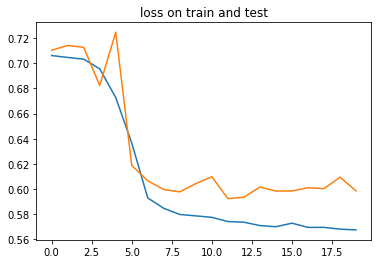

Last loss on train: 0.5673508034870688
Last loss on test: 0.5983978878510626


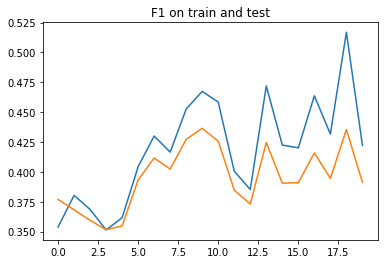

Last F1 on train: 0.4223251035519406
Last F1 on test: 0.39138085865660716


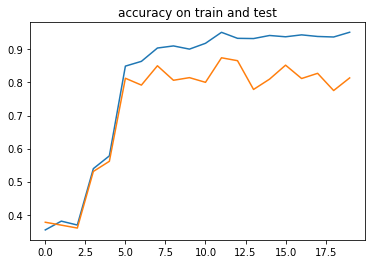

Last accuracy on train: 0.9519528051656959
Last accuracy on test: 0.8138278185536987


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.670593730537679


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

--O das-B stimmt-I nicht-I .-O
--O ganz-B genau-I .-O
na-B gut-I .-O
--O ist-B schon-I gut-I .-O
keine-B ahnung-I ,-O schätzungsweise-O nirgendwohin-O .-O
das-B stimmt-I .-O
hör-B auf-I !-O
ach-B so-I ,-O ja-O ...-O nein-O .-O
aber-B natürlich-I .-O
schon-B gut-I .-O
--O es-O geht-O gut-O voran-O ,-O stimmt-B 's-I ?-O
ich-B glaube-I schon-I .-O
--O ach-B ja-I ?-O
--O ist-B ja-I schon-I gut-I .-O
oh-O nein-O ,-O ist-B schon-I gut-I .-O
was-B geht-I dich-I das-I an-I ?-O
ach-B ja-I ?-O
na-B und-I ?-O
nicht-B wahr-I ,-O carrie-O ?-O
im-B ernst-I !-O
--O also-B gut-I .-O
--O das-B passt-I .-O
ist-B schon-I ok-I .-O
--O scheiß-B drauf-I .-O
--O es-O ist-O der-O pickel-O ,-O nicht-B wahr-I ?-O
keine-B ahnung-I .-O
wir-O kommen-O alle-O ,-O stimmt-B 's-I ?-O
--O keine-B ahnung-I .-O
sehr-B gern-I .-O
sie-B haben-I recht-I ,-O es-O ist-O nichts-O besonderes-O .-O
--O na-B klar-I .-O
--O ach-B was-I .-O
keine-B ahnung-I .-O
gar-B nicht-I .-O
--O ich-B weiß-I .-O
--O das-B stimmt-I .-O
also-B gu

# Experiment 2, testing cells

* GRU
* uni
* 2 cells
* 1 layer
* 1 sentence limitation
* 5 tokens limitation



## Training

In [ ]:
model = GRU_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.005, 1, 1])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


50it [00:01, 29.43it/s]

Train loss: 0.6853996647728814


94it [00:03, 30.68it/s]

Train loss: 0.6569658140341441


141it [00:04, 29.83it/s]

Train loss: 0.6447858227623834


185it [00:06, 30.86it/s]

Train loss: 0.632727614707417


226it [00:07, 30.02it/s]


Train loss: 0.6272221967909071

Evaluating on train...


50it [00:01, 46.02it/s]

Val loss: 0.5868784149487813, Val f1: 0.38651752538151213, Val accuracy: 0.8826814505789015


96it [00:02, 44.27it/s]

Val loss: 0.5885964850584666, Val f1: 0.38886274331145815, Val accuracy: 0.8690623140997357


141it [00:03, 41.73it/s]

Val loss: 0.5903715129251833, Val f1: 0.39201516023388616, Val accuracy: 0.8705146418677436


186it [00:04, 39.90it/s]

Val loss: 0.5899201254049937, Val f1: 0.39336843142906824, Val accuracy: 0.8703549439708392


226it [00:05, 43.39it/s]


Val loss: 0.5903730095757378, Val f1: 0.392744394408332, Val accuracy: 0.8678921205467648

Evaluating on test...


23it [00:00, 41.31it/s]

Val loss: 0.5993228872617086, Val f1: 0.381121426820755, Val accuracy: 0.8125348548094432


38it [00:00, 42.02it/s]

Val loss: 0.6034452021121979, Val f1: 0.38505722880363463, Val accuracy: 0.8252234607934952


53it [00:01, 41.02it/s]

Val loss: 0.6032051655981275, Val f1: 0.38748103115293714, Val accuracy: 0.8201199697123633


68it [00:01, 40.59it/s]

Val loss: 0.6045456071694691, Val f1: 0.3859476308027903, Val accuracy: 0.8094009146094322


76it [00:01, 40.94it/s]


Val loss: 0.6024894499778748, Val f1: 0.38732143680254616, Val accuracy: 0.8205795188744863

starting Epoch 1
Training...


48it [00:01, 31.70it/s]

Train loss: 0.5856564429071215


94it [00:03, 29.04it/s]

Train loss: 0.5897233102056715


140it [00:04, 29.81it/s]

Train loss: 0.5878476588814346


184it [00:06, 30.63it/s]

Train loss: 0.5872244579924477


226it [00:07, 29.93it/s]


Train loss: 0.5875354054239061

Evaluating on train...


50it [00:01, 46.92it/s]

Val loss: 0.5845330291324191, Val f1: 0.41460093259811404, Val accuracy: 0.8751922229925791


95it [00:02, 45.11it/s]

Val loss: 0.5798439873589409, Val f1: 0.41365105476644304, Val accuracy: 0.8720445116360982


140it [00:03, 43.42it/s]

Val loss: 0.5799402356147766, Val f1: 0.41609869179902254, Val accuracy: 0.8790888651653572


185it [00:04, 41.97it/s]

Val loss: 0.5798225800196329, Val f1: 0.4136693881617652, Val accuracy: 0.8799876951509051


226it [00:05, 44.02it/s]


Val loss: 0.5807399725914002, Val f1: 0.41169081489245096, Val accuracy: 0.8742297501034206

Evaluating on test...


20it [00:00, 41.80it/s]

Val loss: 0.5796601414680481, Val f1: 0.41093085209528607, Val accuracy: 0.9159599304199219


35it [00:00, 41.14it/s]

Val loss: 0.5894018630186717, Val f1: 0.40388574500878655, Val accuracy: 0.8671531707048417


50it [00:01, 40.20it/s]

Val loss: 0.5923018097877503, Val f1: 0.40691796673668756, Val accuracy: 0.8630333178573184


65it [00:01, 40.63it/s]

Val loss: 0.5956475178400675, Val f1: 0.404958601295948, Val accuracy: 0.8398083741466205


76it [00:01, 40.82it/s]


Val loss: 0.594118127822876, Val f1: 0.4039705689748128, Val accuracy: 0.8448597586154938

starting Epoch 2
Training...


49it [00:01, 27.88it/s]

Train loss: 0.5814557035764059


96it [00:03, 29.94it/s]

Train loss: 0.5823821511533526


139it [00:04, 27.99it/s]

Train loss: 0.5801692812531083


185it [00:06, 31.88it/s]

Train loss: 0.5792012277576658


226it [00:07, 30.03it/s]


Train loss: 0.5801866380373637

Evaluating on train...


50it [00:01, 46.61it/s]

Val loss: 0.5762460827827454, Val f1: 0.4290072335137261, Val accuracy: 0.869103655550215


95it [00:02, 44.66it/s]

Val loss: 0.5773118356863658, Val f1: 0.42486775285667844, Val accuracy: 0.8902871635225084


140it [00:03, 43.26it/s]

Val loss: 0.5757810522008825, Val f1: 0.4224395555478555, Val accuracy: 0.8977551703099851


185it [00:04, 43.29it/s]

Val loss: 0.5749305960204866, Val f1: 0.42118657131989795, Val accuracy: 0.8995540521211094


226it [00:05, 43.74it/s]


Val loss: 0.574391369289822, Val f1: 0.42256286250220404, Val accuracy: 0.9054750219980876

Evaluating on test...


19it [00:00, 39.90it/s]

Val loss: 0.6005227565765381, Val f1: 0.42021010716756185, Val accuracy: 0.8669312437375386


34it [00:00, 40.54it/s]

Val loss: 0.590476514895757, Val f1: 0.4147696783145269, Val accuracy: 0.8935046315193176


49it [00:01, 41.05it/s]

Val loss: 0.5916675077544318, Val f1: 0.4113079766432444, Val accuracy: 0.8790972762637668


59it [00:01, 40.06it/s]

Val loss: 0.591533758242925, Val f1: 0.4107855349779129, Val accuracy: 0.8832893858353297


76it [00:02, 34.32it/s]


Val loss: 0.5906520040829977, Val f1: 0.40893372178077697, Val accuracy: 0.8662047751744588

starting Epoch 3
Training...


48it [00:01, 30.72it/s]

Train loss: 0.5782521075672573


95it [00:03, 27.80it/s]

Train loss: 0.5783218681812287


138it [00:04, 30.83it/s]

Train loss: 0.5770182384385003


186it [00:06, 31.17it/s]

Train loss: 0.5754200286335416


226it [00:07, 30.23it/s]


Train loss: 0.5767427746454875

Evaluating on train...


52it [00:01, 45.56it/s]

Val loss: 0.5774745464324951, Val f1: 0.42043180598153007, Val accuracy: 0.9088358773125542


97it [00:02, 44.49it/s]

Val loss: 0.5758922821945615, Val f1: 0.42157558037175075, Val accuracy: 0.9167884336577521


142it [00:03, 43.18it/s]

Val loss: 0.5746193475193447, Val f1: 0.4198987093236711, Val accuracy: 0.9209274404578739


187it [00:04, 42.64it/s]

Val loss: 0.5740388747718599, Val f1: 0.4205365848210123, Val accuracy: 0.9168909394078785


226it [00:05, 43.90it/s]


Val loss: 0.5742290788226657, Val f1: 0.4195362435446845, Val accuracy: 0.9087412925561269

Evaluating on test...


20it [00:00, 41.02it/s]

Val loss: 0.5898063540458679, Val f1: 0.4206453045209249, Val accuracy: 0.8763473947842916


35it [00:00, 40.06it/s]

Val loss: 0.5967536429564159, Val f1: 0.40976144472757975, Val accuracy: 0.871255773305893


50it [00:01, 40.98it/s]

Val loss: 0.593337439166175, Val f1: 0.40985875990655685, Val accuracy: 0.8667151596811082


65it [00:01, 40.04it/s]

Val loss: 0.5938813110192617, Val f1: 0.40746108293533323, Val accuracy: 0.8629106670618057


76it [00:01, 40.61it/s]


Val loss: 0.5927578337987264, Val f1: 0.4058378744125366, Val accuracy: 0.8727766219774882

starting Epoch 4
Training...


48it [00:01, 30.32it/s]

Train loss: 0.5731833073827955


95it [00:03, 29.74it/s]

Train loss: 0.5729637258582645


141it [00:04, 31.05it/s]

Train loss: 0.5729641146130032


185it [00:06, 29.11it/s]

Train loss: 0.5752257135179307


226it [00:07, 30.03it/s]


Train loss: 0.5751813872655233

Evaluating on train...


50it [00:01, 48.80it/s]

Val loss: 0.5702670216560364, Val f1: 0.40908779237005444, Val accuracy: 0.9815693868531121


95it [00:02, 43.14it/s]

Val loss: 0.5715987530019548, Val f1: 0.41287621259689333, Val accuracy: 0.9634839965237512


140it [00:03, 43.38it/s]

Val loss: 0.5731691515004194, Val f1: 0.41161684040670043, Val accuracy: 0.9489715889648155


185it [00:04, 41.66it/s]

Val loss: 0.5739390588468976, Val f1: 0.41321407473749583, Val accuracy: 0.9465146644247903


226it [00:05, 43.97it/s]


Val loss: 0.5733513087696499, Val f1: 0.41094773570696513, Val accuracy: 0.946031951242023

Evaluating on test...


20it [00:00, 40.23it/s]

Val loss: 0.5944340705871582, Val f1: 0.4043693204720815, Val accuracy: 0.8963512818018595


35it [00:00, 40.92it/s]

Val loss: 0.5917842090129852, Val f1: 0.3962663531303406, Val accuracy: 0.8954182167847952


50it [00:01, 40.29it/s]

Val loss: 0.5900872627894084, Val f1: 0.39763253728548686, Val accuracy: 0.9027555810080634


65it [00:01, 39.91it/s]

Val loss: 0.5884391993284226, Val f1: 0.3996194784839948, Val accuracy: 0.9120618810256322


76it [00:01, 40.07it/s]


Val loss: 0.5895831147829692, Val f1: 0.3969689726829529, Val accuracy: 0.8919340217113495

starting Epoch 5
Training...


50it [00:01, 30.95it/s]

Train loss: 0.5730323341157701


94it [00:03, 30.52it/s]

Train loss: 0.5754194637139638


138it [00:04, 30.36it/s]

Train loss: 0.5743883698074906


184it [00:06, 29.57it/s]

Train loss: 0.5741288479831483


226it [00:07, 29.83it/s]


Train loss: 0.574363632996877

Evaluating on train...


50it [00:01, 46.67it/s]

Val loss: 0.5774374882380168, Val f1: 0.4123004443115658, Val accuracy: 0.934715191523234


95it [00:02, 44.21it/s]

Val loss: 0.575799521472719, Val f1: 0.41195388005839456, Val accuracy: 0.9359087559911939


140it [00:03, 40.76it/s]

Val loss: 0.5751305818557739, Val f1: 0.4138316894019092, Val accuracy: 0.9419590113339601


185it [00:04, 40.96it/s]

Val loss: 0.5741706805096732, Val f1: 0.4127811464998457, Val accuracy: 0.944124865366353


226it [00:05, 43.11it/s]


Val loss: 0.5729135900073581, Val f1: 0.4132178544998169, Val accuracy: 0.9356578469276429

Evaluating on test...


20it [00:00, 41.51it/s]

Val loss: 0.5943259437878926, Val f1: 0.4195468842983246, Val accuracy: 0.9011620442072551


35it [00:00, 41.01it/s]

Val loss: 0.5901207586129507, Val f1: 0.4037705481052399, Val accuracy: 0.8906976461410523


50it [00:01, 39.25it/s]

Val loss: 0.5911084612210592, Val f1: 0.4022298594315847, Val accuracy: 0.8829954134093391


64it [00:01, 40.10it/s]

Val loss: 0.5894422829151154, Val f1: 0.3989806150396665, Val accuracy: 0.8816596463322639


76it [00:01, 40.51it/s]


Val loss: 0.5883593861262003, Val f1: 0.39666359702746073, Val accuracy: 0.8749764140446981

starting Epoch 6
Training...


49it [00:01, 30.77it/s]

Train loss: 0.5735985543992784


92it [00:03, 30.34it/s]

Train loss: 0.5716387662622664


140it [00:04, 30.19it/s]

Train loss: 0.5745902048216925


184it [00:06, 29.27it/s]

Train loss: 0.5746582375632392


226it [00:07, 29.91it/s]


Train loss: 0.5734463312890794

Evaluating on train...


50it [00:01, 45.32it/s]

Val loss: 0.5722637428177728, Val f1: 0.4399945106771257, Val accuracy: 0.9297994719611273


95it [00:02, 45.46it/s]

Val loss: 0.5701784537898169, Val f1: 0.4436594165033764, Val accuracy: 0.943682755695449


140it [00:03, 42.64it/s]

Val loss: 0.569734459011643, Val f1: 0.4413492174060256, Val accuracy: 0.939336774525819


185it [00:04, 43.00it/s]

Val loss: 0.5707047558493085, Val f1: 0.4386376741859648, Val accuracy: 0.9368245235747761


226it [00:05, 43.21it/s]


Val loss: 0.5713288969463772, Val f1: 0.43603033701578775, Val accuracy: 0.9343466477923923

Evaluating on test...


19it [00:00, 41.37it/s]

Val loss: 0.5906073967615764, Val f1: 0.4069667418797811, Val accuracy: 0.8789124687512716


34it [00:00, 40.61it/s]

Val loss: 0.5935458997885387, Val f1: 0.40812143782774607, Val accuracy: 0.8656052311261495


49it [00:01, 40.86it/s]

Val loss: 0.5946270492341783, Val f1: 0.41132549974653454, Val accuracy: 0.8479896426200867


67it [00:01, 39.56it/s]

Val loss: 0.5927323927481969, Val f1: 0.4138313040137291, Val accuracy: 0.8568374877174695


76it [00:01, 40.34it/s]


Val loss: 0.5899193485577902, Val f1: 0.4135306636492411, Val accuracy: 0.8768977725505829

starting Epoch 7
Training...


49it [00:01, 29.53it/s]

Train loss: 0.5728780044449701


93it [00:03, 30.52it/s]

Train loss: 0.5723464084996117


139it [00:04, 29.25it/s]

Train loss: 0.5725826188370033


182it [00:06, 29.85it/s]

Train loss: 0.5731952445374595


226it [00:07, 29.98it/s]


Train loss: 0.5722896552085877

Evaluating on train...


51it [00:01, 47.69it/s]

Val loss: 0.5737916005982293, Val f1: 0.4253982901573181, Val accuracy: 0.925491002533171


96it [00:02, 45.53it/s]

Val loss: 0.5716195424397786, Val f1: 0.435118744108412, Val accuracy: 0.942971897787518


141it [00:03, 43.86it/s]

Val loss: 0.5724215997589959, Val f1: 0.43656614312419184, Val accuracy: 0.9232099446985457


186it [00:04, 41.81it/s]

Val loss: 0.5723520672983593, Val f1: 0.43461215794086455, Val accuracy: 0.9278221093946033


226it [00:05, 43.77it/s]


Val loss: 0.5710306615299648, Val f1: 0.43983129805988735, Val accuracy: 0.9359201346503364

Evaluating on test...


20it [00:00, 29.28it/s]

Val loss: 0.6020571271578471, Val f1: 0.40250385999679567, Val accuracy: 0.7994955877463022


33it [00:01, 26.71it/s]

Val loss: 0.5936946292718251, Val f1: 0.4048972020546595, Val accuracy: 0.8264811515808106


51it [00:01, 32.75it/s]

Val loss: 0.594879749086168, Val f1: 0.41266939573817785, Val accuracy: 0.8484553496042887


63it [00:02, 32.27it/s]

Val loss: 0.5930642674366633, Val f1: 0.41350576976935066, Val accuracy: 0.8600983172655106


76it [00:02, 29.06it/s]


Val loss: 0.5912960402170817, Val f1: 0.4151832640171051, Val accuracy: 0.877566393216451

starting Epoch 8
Training...


49it [00:02, 23.33it/s]

Train loss: 0.5758482350243462


95it [00:04, 22.45it/s]

Train loss: 0.5727542459964752


137it [00:06, 20.05it/s]

Train loss: 0.5728849547880667


186it [00:08, 30.53it/s]

Train loss: 0.5725195974111557


226it [00:10, 22.01it/s]


Train loss: 0.5724363652865092

Evaluating on train...


50it [00:01, 45.55it/s]

Val loss: 0.5677628835042318, Val f1: 0.45263873736063637, Val accuracy: 0.9593660076459248


95it [00:02, 44.70it/s]

Val loss: 0.5683927721447415, Val f1: 0.46254815691047246, Val accuracy: 0.9622377389007144


140it [00:03, 43.11it/s]

Val loss: 0.5686656837110167, Val f1: 0.46550667197616014, Val accuracy: 0.9604106302614566


185it [00:04, 41.93it/s]

Val loss: 0.5676097134749095, Val f1: 0.4592353544301457, Val accuracy: 0.9510317911704381


226it [00:05, 43.33it/s]


Val loss: 0.5688374630610148, Val f1: 0.45805885473887126, Val accuracy: 0.9445398901568519

Evaluating on test...


19it [00:00, 39.39it/s]

Val loss: 0.606414528687795, Val f1: 0.42787068088849384, Val accuracy: 0.8767044981320699


34it [00:00, 39.47it/s]

Val loss: 0.5965147276719411, Val f1: 0.426780370871226, Val accuracy: 0.8954436560471852


51it [00:01, 38.56it/s]

Val loss: 0.592503821849823, Val f1: 0.42529024150636463, Val accuracy: 0.8927023781670465


63it [00:01, 36.93it/s]

Val loss: 0.5930809239546458, Val f1: 0.4246857812007268, Val accuracy: 0.8842570424079895


76it [00:01, 38.98it/s]


Val loss: 0.5918504524230958, Val f1: 0.4254217032591502, Val accuracy: 0.893578379948934

starting Epoch 9
Training...


49it [00:01, 24.44it/s]

Train loss: 0.5712313532829285


94it [00:03, 26.83it/s]

Train loss: 0.5707630885971917


138it [00:06, 16.37it/s]

Train loss: 0.5711574991544087


183it [00:08, 24.48it/s]

Train loss: 0.5706054614649878


226it [00:10, 21.78it/s]


Train loss: 0.5704080682330661

Evaluating on train...


46it [00:01, 18.77it/s]

Val loss: 0.5687327040566339, Val f1: 0.3973037189907498, Val accuracy: 0.9189274463388655


94it [00:04, 23.29it/s]

Val loss: 0.5683596683873071, Val f1: 0.40014258755577936, Val accuracy: 0.9221576220459409


140it [00:05, 27.58it/s]

Val loss: 0.5681104403954965, Val f1: 0.40211745743398314, Val accuracy: 0.9347840627034505


183it [00:07, 23.13it/s]

Val loss: 0.5696729802423053, Val f1: 0.4054041239950392, Val accuracy: 0.9396080470747418


226it [00:09, 24.28it/s]


Val loss: 0.569240349928538, Val f1: 0.4065355947282579, Val accuracy: 0.942347635295656

Evaluating on test...


21it [00:00, 37.47it/s]

Val loss: 0.5874502658843994, Val f1: 0.39354718128840127, Val accuracy: 0.9011866768201192


34it [00:00, 38.19it/s]

Val loss: 0.5873933215936025, Val f1: 0.39458524783452353, Val accuracy: 0.9062841176986695


50it [00:01, 37.49it/s]

Val loss: 0.5881897727648417, Val f1: 0.38851589692963495, Val accuracy: 0.8766071730189853


67it [00:01, 37.83it/s]

Val loss: 0.5880325078964234, Val f1: 0.38765882750352226, Val accuracy: 0.8798519512017567


76it [00:01, 38.12it/s]


Val loss: 0.5866555245717366, Val f1: 0.3885186171531677, Val accuracy: 0.8892136470476786

starting Epoch 10
Training...


48it [00:01, 30.70it/s]

Train loss: 0.5664705978499518


95it [00:03, 30.13it/s]

Train loss: 0.5682860824796888


140it [00:04, 30.15it/s]

Train loss: 0.568997476277528


184it [00:06, 31.15it/s]

Train loss: 0.5697151783439848


226it [00:07, 29.89it/s]


Train loss: 0.5699656542142232

Evaluating on train...


50it [00:01, 46.29it/s]

Val loss: 0.5643094460169474, Val f1: 0.4334307293097178, Val accuracy: 0.9560595565372043


95it [00:02, 44.55it/s]

Val loss: 0.5668701555993821, Val f1: 0.434087441696061, Val accuracy: 0.9502883500523037


140it [00:03, 41.30it/s]

Val loss: 0.5672078477011786, Val f1: 0.4340882839979949, Val accuracy: 0.9437314620724431


185it [00:04, 41.35it/s]

Val loss: 0.5678931789265739, Val f1: 0.43642813944154313, Val accuracy: 0.943489177359475


226it [00:05, 43.26it/s]


Val loss: 0.5669570925500658, Val f1: 0.43473617275555926, Val accuracy: 0.9436775377061632

Evaluating on test...


19it [00:00, 40.87it/s]

Val loss: 0.600605305035909, Val f1: 0.3971986949443817, Val accuracy: 0.8266696731249491


38it [00:00, 39.96it/s]

Val loss: 0.5966018835703532, Val f1: 0.40153838098049166, Val accuracy: 0.8122343073288599


52it [00:01, 40.28it/s]

Val loss: 0.5946208291583591, Val f1: 0.39927979906400046, Val accuracy: 0.8322719037532806


67it [00:01, 40.76it/s]

Val loss: 0.5925493617852529, Val f1: 0.40170541356007256, Val accuracy: 0.8532054290175438


76it [00:01, 40.32it/s]


Val loss: 0.5919430716832479, Val f1: 0.40289163748423257, Val accuracy: 0.855487368106842

starting Epoch 11
Training...


48it [00:02, 22.25it/s]

Train loss: 0.5678306976954143


93it [00:03, 29.87it/s]

Train loss: 0.5666017459498511


139it [00:05, 30.69it/s]

Train loss: 0.5672942483866656


183it [00:06, 32.22it/s]

Train loss: 0.5672224008374744


226it [00:08, 27.08it/s]


Train loss: 0.5687483334541321

Evaluating on train...


50it [00:01, 46.62it/s]

Val loss: 0.5645960953500536, Val f1: 0.4591457525889079, Val accuracy: 0.961688326464759


95it [00:02, 44.62it/s]

Val loss: 0.5644330660502116, Val f1: 0.4590248465538025, Val accuracy: 0.954491365287039


140it [00:03, 41.93it/s]

Val loss: 0.5643788333292361, Val f1: 0.4506924721929762, Val accuracy: 0.9557394259505801


185it [00:04, 41.11it/s]

Val loss: 0.5638807088136673, Val f1: 0.45375518931282893, Val accuracy: 0.960902697344621


226it [00:05, 43.20it/s]


Val loss: 0.5651917221811082, Val f1: 0.4511085237397088, Val accuracy: 0.9501769655280643

Evaluating on test...


19it [00:00, 41.40it/s]

Val loss: 0.596047866344452, Val f1: 0.39529891808827716, Val accuracy: 0.8101905902226766


34it [00:00, 40.31it/s]

Val loss: 0.5953639606634776, Val f1: 0.40584912995497385, Val accuracy: 0.8217043260733287


49it [00:01, 40.79it/s]

Val loss: 0.5958655688497755, Val f1: 0.41150801645384893, Val accuracy: 0.8290154510074191


68it [00:01, 39.97it/s]

Val loss: 0.5951245903968811, Val f1: 0.4135893478989601, Val accuracy: 0.8354564994573593


76it [00:01, 40.20it/s]


Val loss: 0.5954417252540588, Val f1: 0.4100214453538259, Val accuracy: 0.8261832976341248

starting Epoch 12
Training...


48it [00:01, 30.64it/s]

Train loss: 0.5664540794160631


92it [00:03, 30.36it/s]

Train loss: 0.5657679968410068


136it [00:04, 31.59it/s]

Train loss: 0.5673088864043907


183it [00:06, 21.83it/s]

Train loss: 0.5678947564628389


226it [00:08, 27.59it/s]


Train loss: 0.568293584452735

Evaluating on train...


51it [00:01, 45.88it/s]

Val loss: 0.5635228037834168, Val f1: 0.45650793181525334, Val accuracy: 0.9635623508029514


96it [00:02, 45.49it/s]

Val loss: 0.5643478850523631, Val f1: 0.45448904501067267, Val accuracy: 0.9643682758013408


141it [00:03, 42.71it/s]

Val loss: 0.5650697558014481, Val f1: 0.4554313728102931, Val accuracy: 0.9618098139762878


186it [00:04, 43.63it/s]

Val loss: 0.5656750854518678, Val f1: 0.4528605264094141, Val accuracy: 0.9595499712559912


226it [00:05, 44.12it/s]


Val loss: 0.5654427806536356, Val f1: 0.4517571667830149, Val accuracy: 0.9614373352792528

Evaluating on test...


21it [00:00, 38.09it/s]

Val loss: 0.6034524838129679, Val f1: 0.4261242250601451, Val accuracy: 0.8667365948359171


37it [00:00, 36.91it/s]

Val loss: 0.6044501463572184, Val f1: 0.4120759298404058, Val accuracy: 0.8092874894539516


49it [00:01, 36.06it/s]

Val loss: 0.5965153906080458, Val f1: 0.41391751832432216, Val accuracy: 0.8497254126601749


65it [00:01, 36.42it/s]

Val loss: 0.5953413585821787, Val f1: 0.4136731187502543, Val accuracy: 0.8358367696404457


76it [00:02, 37.27it/s]


Val loss: 0.5955996187527974, Val f1: 0.414479474623998, Val accuracy: 0.826723309357961

starting Epoch 13
Training...


50it [00:01, 28.66it/s]

Train loss: 0.5640946626663208


93it [00:03, 30.61it/s]

Train loss: 0.56647170914544


140it [00:04, 28.79it/s]

Train loss: 0.565892329480913


185it [00:06, 30.35it/s]

Train loss: 0.5655938340557947


226it [00:07, 29.65it/s]


Train loss: 0.5666315984725953

Evaluating on train...


50it [00:01, 47.11it/s]

Val loss: 0.5625555117925009, Val f1: 0.44688300026787653, Val accuracy: 0.9404146651426951


95it [00:02, 44.49it/s]

Val loss: 0.5642665379577213, Val f1: 0.44425512055555977, Val accuracy: 0.9548943145407571


139it [00:03, 30.50it/s]

Val loss: 0.5639954743561921, Val f1: 0.4482934174714265, Val accuracy: 0.9565754144280045


183it [00:05, 26.00it/s]

Val loss: 0.5639152295059628, Val f1: 0.44624277104934057, Val accuracy: 0.956352624628279


226it [00:06, 34.38it/s]


Val loss: 0.5638001063134935, Val f1: 0.44712718142403496, Val accuracy: 0.9579834489027659

Evaluating on test...


20it [00:00, 38.34it/s]

Val loss: 0.5889302730560303, Val f1: 0.4087273915608724, Val accuracy: 0.8750036001205445


36it [00:00, 37.73it/s]

Val loss: 0.5842640082041423, Val f1: 0.41139300564924874, Val accuracy: 0.8958914120992024


52it [00:01, 35.41it/s]

Val loss: 0.5833305517832438, Val f1: 0.4100036793284946, Val accuracy: 0.8634050475226508


64it [00:01, 35.00it/s]

Val loss: 0.5839478105306626, Val f1: 0.4092823714017868, Val accuracy: 0.8568452621499697


76it [00:02, 37.06it/s]


Val loss: 0.5874516812960306, Val f1: 0.4130112691720327, Val accuracy: 0.8566506803035736

starting Epoch 14
Training...


47it [00:01, 30.95it/s]

Train loss: 0.562676813867357


95it [00:03, 30.30it/s]

Train loss: 0.5642249365647634


139it [00:04, 30.76it/s]

Train loss: 0.5655353272402728


183it [00:06, 30.31it/s]

Train loss: 0.5655913803312513


226it [00:07, 29.73it/s]


Train loss: 0.5656624666849772

Evaluating on train...


45it [00:01, 44.36it/s]

Val loss: 0.5664759000142415, Val f1: 0.49324474334716795, Val accuracy: 0.9405134677886963


98it [00:02, 41.77it/s]

Val loss: 0.564628787835439, Val f1: 0.4939176662100686, Val accuracy: 0.9387024170822568


143it [00:03, 41.76it/s]

Val loss: 0.5642723697203177, Val f1: 0.4990025204640848, Val accuracy: 0.9428873051095892


182it [00:04, 34.91it/s]

Val loss: 0.5642678542269601, Val f1: 0.500909595688184, Val accuracy: 0.9426806994610363


226it [00:06, 34.48it/s]


Val loss: 0.5645494071642557, Val f1: 0.4954822728368971, Val accuracy: 0.9322451249758402

Evaluating on test...


19it [00:00, 28.40it/s]

Val loss: 0.5960371573766072, Val f1: 0.4492092271645864, Val accuracy: 0.8115622639656067


35it [00:01, 34.45it/s]

Val loss: 0.5954288562138875, Val f1: 0.43630907237529754, Val accuracy: 0.8148172487815221


52it [00:01, 37.89it/s]

Val loss: 0.5984361330668132, Val f1: 0.44046182566218905, Val accuracy: 0.8044157226880392


65it [00:01, 38.24it/s]

Val loss: 0.6005875746409098, Val f1: 0.4390656630198161, Val accuracy: 0.7990505049626032


76it [00:02, 34.41it/s]


Val loss: 0.5997386693954467, Val f1: 0.43940717458724976, Val accuracy: 0.8015745004018148

starting Epoch 15
Training...


50it [00:01, 30.94it/s]

Train loss: 0.5604820105764601


93it [00:03, 30.83it/s]

Train loss: 0.5631647136476304


136it [00:05, 18.57it/s]

Train loss: 0.5626400682661269


182it [00:07, 22.08it/s]

Train loss: 0.5636752602126863


226it [00:09, 24.77it/s]


Train loss: 0.5644275670581393

Evaluating on train...


44it [00:01, 34.58it/s]

Val loss: 0.5609609100553724, Val f1: 0.45367544492085776, Val accuracy: 0.9412300725777943


93it [00:03, 24.67it/s]

Val loss: 0.5609555972947015, Val f1: 0.462015438079834, Val accuracy: 0.9589037673340903


138it [00:05, 26.24it/s]

Val loss: 0.5621062799736306, Val f1: 0.46295155110182584, Val accuracy: 0.955362883982835


187it [00:06, 37.15it/s]

Val loss: 0.5629520283805, Val f1: 0.4618151848514875, Val accuracy: 0.9565020384060012


226it [00:07, 30.41it/s]


Val loss: 0.5630100475417243, Val f1: 0.46405487285719976, Val accuracy: 0.9555628665288289

Evaluating on test...


20it [00:00, 37.74it/s]

Val loss: 0.5929199814796448, Val f1: 0.3945905844370524, Val accuracy: 0.7285414497057597


36it [00:00, 37.66it/s]

Val loss: 0.5917840580145518, Val f1: 0.41384526491165163, Val accuracy: 0.8193359136581421


53it [00:01, 38.62it/s]

Val loss: 0.591480651166704, Val f1: 0.41196833385361564, Val accuracy: 0.8311195943090651


65it [00:01, 38.27it/s]

Val loss: 0.591226902604103, Val f1: 0.4208717743555705, Val accuracy: 0.8439180831114451


76it [00:01, 38.41it/s]


Val loss: 0.5912108993530274, Val f1: 0.417158309618632, Val accuracy: 0.8399691593647003

starting Epoch 16
Training...


50it [00:01, 26.99it/s]

Train loss: 0.5648424903551738


94it [00:03, 30.85it/s]

Train loss: 0.5635869907008277


140it [00:04, 31.51it/s]

Train loss: 0.5639345111670317


183it [00:06, 30.66it/s]

Train loss: 0.5645327260096867


226it [00:07, 29.55it/s]


Train loss: 0.5645010982619392

Evaluating on train...


50it [00:01, 45.71it/s]

Val loss: 0.5618614607387119, Val f1: 0.451928934123781, Val accuracy: 0.955235958761639


95it [00:02, 42.66it/s]

Val loss: 0.5620524750815498, Val f1: 0.4498563763168123, Val accuracy: 0.9472932812240389


140it [00:03, 41.45it/s]

Val loss: 0.5633097851717913, Val f1: 0.45210790634155273, Val accuracy: 0.9479917000841211


185it [00:04, 40.46it/s]

Val loss: 0.5631913257969751, Val f1: 0.4549429130223062, Val accuracy: 0.9416730095942815


226it [00:05, 42.33it/s]


Val loss: 0.562785927189721, Val f1: 0.45740892224841645, Val accuracy: 0.9355452511045668

Evaluating on test...


22it [00:00, 39.70it/s]

Val loss: 0.5961036443710327, Val f1: 0.39170682032903037, Val accuracy: 0.82103204925855


34it [00:00, 37.69it/s]

Val loss: 0.5896105508009593, Val f1: 0.4131202777226766, Val accuracy: 0.858559196194013


52it [00:01, 39.02it/s]

Val loss: 0.5923713856273227, Val f1: 0.4140942295392354, Val accuracy: 0.8625388311015235


64it [00:01, 38.38it/s]

Val loss: 0.5960811277230581, Val f1: 0.41511475543181103, Val accuracy: 0.8583378449082375


76it [00:01, 38.59it/s]


Val loss: 0.5950454457600911, Val f1: 0.4128421386082967, Val accuracy: 0.8505456387996674

starting Epoch 17
Training...


50it [00:01, 28.21it/s]

Train loss: 0.5679628332455953


93it [00:03, 30.91it/s]

Train loss: 0.5652854349878099


140it [00:04, 28.88it/s]

Train loss: 0.5655461461455734


184it [00:06, 30.32it/s]

Train loss: 0.5652584950129191


226it [00:07, 29.46it/s]


Train loss: 0.5650663063261244

Evaluating on train...


49it [00:01, 45.72it/s]

Val loss: 0.5619208349121941, Val f1: 0.47711308466063607, Val accuracy: 0.9744470496972402


94it [00:02, 44.74it/s]

Val loss: 0.5617175108856625, Val f1: 0.47688591678937275, Val accuracy: 0.9611056023173862


139it [00:03, 42.42it/s]

Val loss: 0.5615036628864429, Val f1: 0.4768981176394003, Val accuracy: 0.9630875980412519


184it [00:04, 41.54it/s]

Val loss: 0.5624298380480872, Val f1: 0.4770942090286149, Val accuracy: 0.9587647552291553


226it [00:05, 43.04it/s]


Val loss: 0.5623572696579827, Val f1: 0.48298746930228337, Val accuracy: 0.957777595784929

Evaluating on test...


23it [00:00, 40.60it/s]

Val loss: 0.6142170468966166, Val f1: 0.42383579214413963, Val accuracy: 0.8043307602405548


37it [00:00, 40.61it/s]

Val loss: 0.6018164833386739, Val f1: 0.42401676376660663, Val accuracy: 0.8039511770009995


52it [00:01, 39.35it/s]

Val loss: 0.5968229982588026, Val f1: 0.4251516706413693, Val accuracy: 0.7854686498641967


66it [00:01, 40.02it/s]

Val loss: 0.5964964250723521, Val f1: 0.43004827449719113, Val accuracy: 0.7934574569265048


76it [00:01, 39.89it/s]


Val loss: 0.5991869084040324, Val f1: 0.4307211029529572, Val accuracy: 0.7960483586788177

starting Epoch 18
Training...


48it [00:01, 28.81it/s]

Train loss: 0.5633476535479228


95it [00:03, 28.75it/s]

Train loss: 0.5639584779739379


141it [00:04, 30.35it/s]

Train loss: 0.5634548827453896


185it [00:06, 31.54it/s]

Train loss: 0.5642517619662815


226it [00:07, 29.72it/s]


Train loss: 0.5640687706735399

Evaluating on train...


50it [00:01, 46.06it/s]

Val loss: 0.5646935515933567, Val f1: 0.5008478025595348, Val accuracy: 0.9427098923259312


95it [00:02, 44.10it/s]

Val loss: 0.5622152626514435, Val f1: 0.49638119108147094, Val accuracy: 0.9436921209096909


140it [00:03, 42.94it/s]

Val loss: 0.5617677383952671, Val f1: 0.49931496227229083, Val accuracy: 0.9451779848999448


185it [00:04, 41.16it/s]

Val loss: 0.5613728774918451, Val f1: 0.4943184064494239, Val accuracy: 0.9527753113044632


226it [00:05, 42.73it/s]


Val loss: 0.5613345816400316, Val f1: 0.49461718599001564, Val accuracy: 0.9526394273175134

Evaluating on test...


22it [00:00, 39.26it/s]

Val loss: 0.6069809635480244, Val f1: 0.44431648453076683, Val accuracy: 0.8468966007232666


35it [00:00, 39.27it/s]

Val loss: 0.5958790898323059, Val f1: 0.4327430287996928, Val accuracy: 0.8297091543674469


51it [00:01, 38.86it/s]

Val loss: 0.5988508476151361, Val f1: 0.4375688281324175, Val accuracy: 0.8292495773898231


68it [00:01, 38.70it/s]

Val loss: 0.5976197679837545, Val f1: 0.43494897335767746, Val accuracy: 0.8324208319187164


76it [00:01, 38.76it/s]


Val loss: 0.5997475306193034, Val f1: 0.4363415058453878, Val accuracy: 0.8253300420443217

starting Epoch 19
Training...


50it [00:01, 30.74it/s]

Train loss: 0.5641457690132989


94it [00:03, 30.93it/s]

Train loss: 0.5621919863753848


138it [00:04, 29.91it/s]

Train loss: 0.5620880753905685


186it [00:06, 30.42it/s]

Train loss: 0.5618630819850498


226it [00:07, 29.56it/s]


Train loss: 0.5617342143588596

Evaluating on train...


54it [00:01, 44.01it/s]

Val loss: 0.5635545121298896, Val f1: 0.48619816700617474, Val accuracy: 0.9128918468952179


94it [00:02, 43.54it/s]

Val loss: 0.5605532103114658, Val f1: 0.48662124507957033, Val accuracy: 0.9463360965251922


139it [00:03, 41.41it/s]

Val loss: 0.5602338963084751, Val f1: 0.4930264863702986, Val accuracy: 0.95265833735466


184it [00:04, 41.52it/s]

Val loss: 0.5609411064121458, Val f1: 0.49302152345577877, Val accuracy: 0.9440209451648924


226it [00:05, 42.27it/s]


Val loss: 0.5606874126858181, Val f1: 0.4936228417025672, Val accuracy: 0.9498451407750448

Evaluating on test...


23it [00:00, 41.16it/s]

Val loss: 0.5825048009554545, Val f1: 0.418512350320816, Val accuracy: 0.8468338191509247


33it [00:00, 40.33it/s]

Val loss: 0.5847243348757426, Val f1: 0.4227499226729075, Val accuracy: 0.8562763879696528


51it [00:01, 39.23it/s]

Val loss: 0.5898387326134575, Val f1: 0.4275526702404022, Val accuracy: 0.8414857202106052


67it [00:01, 38.70it/s]

Val loss: 0.5920986622571945, Val f1: 0.4294883673389753, Val accuracy: 0.8438839654127757


76it [00:01, 39.06it/s]

Val loss: 0.5938784432411194, Val f1: 0.42928858002026876, Val accuracy: 0.8310001850128174


## Graphics

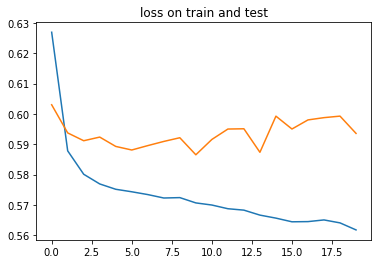

Last loss on train: 0.5617344529755348
Last loss on test: 0.5935827964230588


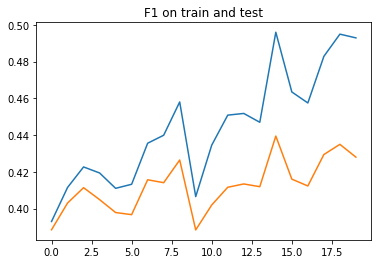

Last F1 on train: 0.49290703223869864
Last F1 on test: 0.42798194093139547


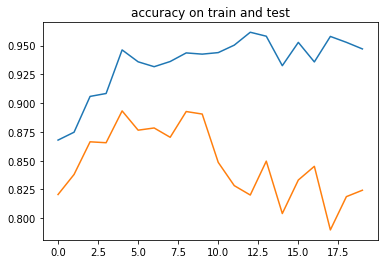

Last accuracy on train: 0.9471041428304352
Last accuracy on test: 0.8243646731502131


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.7886651442806726


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

--O nicht-B wirklich-I .-O
--O im-B ernst-I .-O
--O in-B ordnung-I .-O
aber-B natürlich-I .-O
--O das-B geht-I nicht-I .-O
hör-B auf-I !-O
auf-B keinen-I fall-I .-O
--O in-B der-I tat-I !-O
--O machen-B sie-I witze-I ?-O
in-B ordnung-I ,-O gnädige-O frau-O .-O
ist-B schon-I gut-I .-O
ist-B schon-I gut-I .-O
--O ganz-B genau-I .-O
--O keine-B ahnung-I .-O
--O also-B gut-I .-O
--O na-B klar-I .-O
--O ich-B bin-I dabei-I .-O
--O aber-B natürlich-I .-O
schon-B gut-I .-O
das-B stimmt-I ,-O ja-O .-O
--O kein-B problem-I .-O
ich-B glaube-I schon-I .-O
--O dann-O ist-O sie-O eben-O 'ne-O frau-O ,-O na-B und-I ?-O
im-B ernst-I !-O
--O ist-B ja-I schon-I gut-I .-O
ganz-B und-I gar-I nicht-I .-O
--O machst-B du-I witze-I ?-O
na-B gut-I ,-O äh-O ,-O wir-O sehen-O uns-O dann-O nachher-O .-O
keine-B ahnung-I .-O
--O ich-B bin-I dabei-I .-O
--O ich-B bin-I dabei-I .-O
hör-B auf-I ,-O valiente-O !-O
ja-O ,-O na-B und-I ?-O
na-B gut-I ,-O mein-O schatz-O .-O
also-B gut-I .-O
nicht-B wahr-I ,-O trey-O ?

# Experiment 3, testing bi-directional

* GRU
* bi
* 1 cell
* 1 layer
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = BiGRU(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.005, 1, 1])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


47it [00:02, 19.15it/s]

Train loss: 0.715479126241472


92it [00:04, 21.18it/s]

Train loss: 0.704952147271898


138it [00:06, 21.32it/s]

Train loss: 0.6892535478980453


182it [00:09, 18.20it/s]

Train loss: 0.6832628462049696


226it [00:11, 20.52it/s]


Train loss: 0.6754456196890937

Evaluating on train...


51it [00:01, 39.25it/s]

Val loss: 0.5913100918134053, Val f1: 0.3944511353969574, Val accuracy: 0.8457713385423025


94it [00:02, 38.63it/s]

Val loss: 0.5981321142779457, Val f1: 0.39446601271629333, Val accuracy: 0.8173257648944855


139it [00:03, 41.45it/s]

Val loss: 0.6019453914077194, Val f1: 0.3941546219366568, Val accuracy: 0.8082768031844386


186it [00:04, 38.62it/s]

Val loss: 0.6040698673990038, Val f1: 0.3947932284739282, Val accuracy: 0.8036093975106875


226it [00:05, 38.84it/s]


Val loss: 0.6047968594233195, Val f1: 0.39662230571111046, Val accuracy: 0.8029458623462253

Evaluating on test...


20it [00:00, 36.40it/s]

Val loss: 0.6059668938318888, Val f1: 0.40571396946907046, Val accuracy: 0.8701115528742472


36it [00:00, 37.85it/s]

Val loss: 0.6218843777974447, Val f1: 0.4019335925579071, Val accuracy: 0.8046413362026215


53it [00:01, 38.96it/s]

Val loss: 0.6150196936395433, Val f1: 0.40104199912812977, Val accuracy: 0.8121527042653826


66it [00:01, 39.52it/s]

Val loss: 0.6112635592619579, Val f1: 0.397488659620285, Val accuracy: 0.813892828921477


76it [00:01, 38.40it/s]


Val loss: 0.6116939218839009, Val f1: 0.3943265990416209, Val accuracy: 0.8002963014443716

starting Epoch 1
Training...


48it [00:02, 21.08it/s]

Train loss: 0.5986471401320563


93it [00:04, 20.69it/s]

Train loss: 0.5916198445691003


139it [00:06, 20.29it/s]

Train loss: 0.5865426244559111


180it [00:08, 21.05it/s]

Train loss: 0.5842798587348726


226it [00:10, 20.56it/s]


Train loss: 0.5839945385191175

Evaluating on train...


52it [00:01, 38.19it/s]

Val loss: 0.5666825771331787, Val f1: 0.46190121902359854, Val accuracy: 0.9773204167683919


94it [00:02, 38.36it/s]

Val loss: 0.5667374591032664, Val f1: 0.45425237682130604, Val accuracy: 0.9517112546496921


140it [00:03, 38.78it/s]

Val loss: 0.5675024385805483, Val f1: 0.4485416739075272, Val accuracy: 0.9436362330560331


184it [00:04, 37.77it/s]

Val loss: 0.5674751788377762, Val f1: 0.44851989812321136, Val accuracy: 0.9427257067627377


226it [00:05, 38.24it/s]


Val loss: 0.567903822792901, Val f1: 0.4482489976618025, Val accuracy: 0.9438738613658482

Evaluating on test...


20it [00:00, 36.33it/s]

Val loss: 0.5841838041941325, Val f1: 0.4412859519322713, Val accuracy: 0.9244451562563578


36it [00:01, 36.10it/s]

Val loss: 0.5776948034763336, Val f1: 0.4214881499608358, Val accuracy: 0.8725098093350728


52it [00:01, 37.52it/s]

Val loss: 0.5792641573482089, Val f1: 0.4228336036205292, Val accuracy: 0.8746785289711423


64it [00:01, 38.31it/s]

Val loss: 0.5765411347150803, Val f1: 0.4254352435469627, Val accuracy: 0.8940284177660942


76it [00:02, 36.88it/s]


Val loss: 0.5779225126902262, Val f1: 0.43182776172955833, Val accuracy: 0.900134996175766

starting Epoch 2
Training...


48it [00:02, 21.23it/s]

Train loss: 0.5655169248580932


93it [00:04, 21.13it/s]

Train loss: 0.5689802534050412


137it [00:06, 20.98it/s]

Train loss: 0.5689550567556311


184it [00:08, 19.80it/s]

Train loss: 0.5683285580741034


226it [00:10, 20.70it/s]


Train loss: 0.5672216304143269

Evaluating on train...


52it [00:01, 40.41it/s]

Val loss: 0.5611906515227424, Val f1: 0.5165917072031233, Val accuracy: 0.9211135884126027


94it [00:02, 38.96it/s]

Val loss: 0.56126818590694, Val f1: 0.5082994517352846, Val accuracy: 0.926737849911054


141it [00:03, 38.76it/s]

Val loss: 0.5611657619476318, Val f1: 0.5148717171616024, Val accuracy: 0.9350943655879409


184it [00:04, 39.34it/s]

Val loss: 0.560816866159439, Val f1: 0.5237114732464154, Val accuracy: 0.9388164972265561


226it [00:05, 39.01it/s]


Val loss: 0.5618653583526612, Val f1: 0.5254806040392982, Val accuracy: 0.9300625966654883

Evaluating on test...


20it [00:00, 23.46it/s]

Val loss: 0.5697808821996053, Val f1: 0.4872977097829183, Val accuracy: 0.8905241231123606


36it [00:01, 34.16it/s]

Val loss: 0.5649256885051728, Val f1: 0.4946618348360062, Val accuracy: 0.8917417734861374


48it [00:01, 36.50it/s]

Val loss: 0.5665691216786702, Val f1: 0.5009943962097168, Val accuracy: 0.9084225806925031


65it [00:02, 37.75it/s]

Val loss: 0.5710387508074443, Val f1: 0.4935870935519536, Val accuracy: 0.8957190319895745


76it [00:02, 33.05it/s]


Val loss: 0.5721617539723715, Val f1: 0.4920216155052185, Val accuracy: 0.8955764655272166

starting Epoch 3
Training...


48it [00:02, 21.89it/s]

Train loss: 0.5652128219604492


93it [00:04, 20.50it/s]

Train loss: 0.5641497307353549


138it [00:06, 20.16it/s]

Train loss: 0.5637977538285432


182it [00:08, 22.40it/s]

Train loss: 0.5646382659673691


226it [00:10, 21.00it/s]


Train loss: 0.5637458345625136

Evaluating on train...


49it [00:01, 37.99it/s]

Val loss: 0.5643767608536614, Val f1: 0.4449706269635095, Val accuracy: 0.9325396332475874


97it [00:02, 39.01it/s]

Val loss: 0.5641895261075761, Val f1: 0.43224491278330485, Val accuracy: 0.9522070152892007


141it [00:03, 37.75it/s]

Val loss: 0.5660800761646695, Val f1: 0.4312604895344487, Val accuracy: 0.9447583229453476


185it [00:04, 37.83it/s]

Val loss: 0.5653423696756363, Val f1: 0.4315576962298817, Val accuracy: 0.9544702208704419


226it [00:06, 37.50it/s]


Val loss: 0.5657119509908888, Val f1: 0.4319437135590447, Val accuracy: 0.9506916701793671

Evaluating on test...


21it [00:00, 40.28it/s]

Val loss: 0.5768378376960754, Val f1: 0.410091499487559, Val accuracy: 0.8616748789946238


34it [00:00, 39.10it/s]

Val loss: 0.5768260955810547, Val f1: 0.4195420761903127, Val accuracy: 0.9045586754878362


50it [00:01, 37.22it/s]

Val loss: 0.5760942101478577, Val f1: 0.42175519201490613, Val accuracy: 0.9083384897973802


66it [00:01, 36.67it/s]

Val loss: 0.5742705365022024, Val f1: 0.4190097759167353, Val accuracy: 0.9244958539803823


76it [00:01, 38.47it/s]


Val loss: 0.5732987984021505, Val f1: 0.41574143727620444, Val accuracy: 0.9303927024205526

starting Epoch 4
Training...


49it [00:02, 19.31it/s]

Train loss: 0.5629352357652452


93it [00:04, 21.27it/s]

Train loss: 0.5641803893778059


138it [00:06, 20.97it/s]

Train loss: 0.5635141302038122


183it [00:08, 21.34it/s]

Train loss: 0.5637297597196367


226it [00:10, 20.81it/s]


Train loss: 0.5630642898877461

Evaluating on train...


51it [00:01, 38.16it/s]

Val loss: 0.5573459492789374, Val f1: 0.672227598561181, Val accuracy: 0.990323437584771


95it [00:02, 39.05it/s]

Val loss: 0.5582066178321838, Val f1: 0.6486873116758135, Val accuracy: 0.9757576452361213


139it [00:03, 37.85it/s]

Val loss: 0.5601669390996297, Val f1: 0.6378452828636876, Val accuracy: 0.968595689535141


184it [00:04, 37.98it/s]

Val loss: 0.5609140313333936, Val f1: 0.6373873540096813, Val accuracy: 0.9668929651379585


226it [00:05, 38.16it/s]


Val loss: 0.5612841950522529, Val f1: 0.6333994494544135, Val accuracy: 0.9596145844459534

Evaluating on test...


21it [00:00, 39.21it/s]

Val loss: 0.5898772557576497, Val f1: 0.5793449620405833, Val accuracy: 0.8737518151601156


37it [00:00, 38.15it/s]

Val loss: 0.5886466920375824, Val f1: 0.5602987279494603, Val accuracy: 0.8680229683717092


49it [00:01, 38.32it/s]

Val loss: 0.581666084130605, Val f1: 0.5684528397189246, Val accuracy: 0.8887152565850152


66it [00:01, 38.09it/s]

Val loss: 0.5810139546791713, Val f1: 0.5734132990241051, Val accuracy: 0.8811485504110654


76it [00:01, 38.31it/s]


Val loss: 0.5794553669293722, Val f1: 0.5687779792149862, Val accuracy: 0.8900574378172557

starting Epoch 5
Training...


47it [00:02, 21.92it/s]

Train loss: 0.5626036749945746


92it [00:04, 21.89it/s]

Train loss: 0.5613601459397211


138it [00:06, 19.43it/s]

Train loss: 0.5595647723586471


183it [00:08, 20.80it/s]

Train loss: 0.559480501876937


226it [00:10, 20.59it/s]


Train loss: 0.5610201348198784

Evaluating on train...


51it [00:01, 36.52it/s]

Val loss: 0.55893890592787, Val f1: 0.5859825544887118, Val accuracy: 0.9494906485080719


95it [00:02, 38.51it/s]

Val loss: 0.5603218581941393, Val f1: 0.5787872807847129, Val accuracy: 0.9539530141486062


140it [00:03, 38.52it/s]

Val loss: 0.5590909061608491, Val f1: 0.5723867142641986, Val accuracy: 0.9665025280581581


187it [00:05, 38.26it/s]

Val loss: 0.5603423525889715, Val f1: 0.5663133374518818, Val accuracy: 0.9593515922625859


226it [00:06, 36.17it/s]


Val loss: 0.5599472332000732, Val f1: 0.5664257097244263, Val accuracy: 0.9595777765909831

Evaluating on test...


20it [00:00, 37.00it/s]

Val loss: 0.5838658332824707, Val f1: 0.48648786544799805, Val accuracy: 0.853752322991689


36it [00:00, 38.66it/s]

Val loss: 0.5810968776543936, Val f1: 0.5041886985301971, Val accuracy: 0.8843572199344635


52it [00:01, 36.98it/s]

Val loss: 0.5759792473581102, Val f1: 0.499810078408983, Val accuracy: 0.8956634329424964


64it [00:01, 36.95it/s]

Val loss: 0.5743608405192693, Val f1: 0.5031016985575358, Val accuracy: 0.9079815541704496


76it [00:02, 37.98it/s]


Val loss: 0.5740121324857076, Val f1: 0.5016931513945262, Val accuracy: 0.9030085396766663

starting Epoch 6
Training...


49it [00:02, 22.19it/s]

Train loss: 0.5586304717593723


93it [00:04, 18.16it/s]

Train loss: 0.5590096533298492


139it [00:06, 21.04it/s]

Train loss: 0.5585969920511599


184it [00:08, 22.15it/s]

Train loss: 0.5592848632070754


226it [00:10, 20.77it/s]


Train loss: 0.5596069510777791

Evaluating on train...


51it [00:01, 37.28it/s]

Val loss: 0.554712192217509, Val f1: 0.6499712248643239, Val accuracy: 0.9521629605028364


95it [00:02, 38.09it/s]

Val loss: 0.5560806526078118, Val f1: 0.6341443111499151, Val accuracy: 0.9363049997223748


141it [00:03, 38.37it/s]

Val loss: 0.5563246183925205, Val f1: 0.6383723949944532, Val accuracy: 0.938092342570976


186it [00:04, 36.40it/s]

Val loss: 0.5582589858108097, Val f1: 0.631422623164124, Val accuracy: 0.9322549646099408


226it [00:05, 38.07it/s]


Val loss: 0.5589410787158542, Val f1: 0.6397576169172923, Val accuracy: 0.9370243728160859

Evaluating on test...


20it [00:00, 36.18it/s]

Val loss: 0.5848493893941243, Val f1: 0.5386254827181498, Val accuracy: 0.7897327641646067


36it [00:00, 36.72it/s]

Val loss: 0.5799863139788309, Val f1: 0.5651914258797963, Val accuracy: 0.8579514414072037


52it [00:01, 36.57it/s]

Val loss: 0.5820840040842692, Val f1: 0.5546053555276659, Val accuracy: 0.8508203268051148


64it [00:01, 35.88it/s]

Val loss: 0.5784370750188828, Val f1: 0.5544496024648349, Val accuracy: 0.8646747469902039


76it [00:02, 36.69it/s]


Val loss: 0.5779143436749776, Val f1: 0.562328013976415, Val accuracy: 0.8778592848777771

starting Epoch 7
Training...


47it [00:02, 22.67it/s]

Train loss: 0.5584955520100063


92it [00:04, 20.68it/s]

Train loss: 0.5584251648849912


137it [00:06, 21.09it/s]

Train loss: 0.5576427561265451


182it [00:08, 19.69it/s]

Train loss: 0.5584841661983067


226it [00:10, 20.71it/s]


Train loss: 0.5600600163141887

Evaluating on train...


49it [00:01, 39.53it/s]

Val loss: 0.5573888460795084, Val f1: 0.5647925568951501, Val accuracy: 0.9386616554525163


96it [00:02, 37.89it/s]

Val loss: 0.5594842831293741, Val f1: 0.5653622749778959, Val accuracy: 0.941712795694669


138it [00:03, 38.07it/s]

Val loss: 0.5590797574431808, Val f1: 0.5621181512320483, Val accuracy: 0.9426093236163811


183it [00:04, 36.34it/s]

Val loss: 0.5593260745207469, Val f1: 0.5646947724951639, Val accuracy: 0.94807132234176


226it [00:05, 37.88it/s]


Val loss: 0.5598997259140015, Val f1: 0.5707713916566637, Val accuracy: 0.9494442138406965

Evaluating on test...


20it [00:00, 37.94it/s]

Val loss: 0.5835005124409993, Val f1: 0.4893333415190379, Val accuracy: 0.8587728798389435


37it [00:00, 38.66it/s]

Val loss: 0.5742368419965108, Val f1: 0.516780416170756, Val accuracy: 0.8938373486200969


50it [00:01, 38.84it/s]

Val loss: 0.5777100801467896, Val f1: 0.5108511957857343, Val accuracy: 0.8689676496717665


67it [00:01, 37.04it/s]

Val loss: 0.578110025326411, Val f1: 0.5105038419365883, Val accuracy: 0.8761694485942523


76it [00:01, 38.00it/s]


Val loss: 0.5772443548838297, Val f1: 0.5111394095420837, Val accuracy: 0.8798326313495636

starting Epoch 8
Training...


48it [00:02, 21.52it/s]

Train loss: 0.5619759493403964


93it [00:04, 22.34it/s]

Train loss: 0.5613035851054722


138it [00:06, 20.12it/s]

Train loss: 0.5616413867032086


182it [00:08, 22.56it/s]

Train loss: 0.5603018307023578


226it [00:10, 20.77it/s]


Train loss: 0.5602206699053447

Evaluating on train...


50it [00:01, 39.35it/s]

Val loss: 0.5567820774184333, Val f1: 0.6681161363919575, Val accuracy: 0.9544308986928728


97it [00:02, 39.61it/s]

Val loss: 0.5563983254962497, Val f1: 0.6676935742298762, Val accuracy: 0.9528012305498124


142it [00:03, 37.66it/s]

Val loss: 0.5566924691200257, Val f1: 0.6732426943602385, Val accuracy: 0.956232797437244


186it [00:04, 37.84it/s]

Val loss: 0.5574878411160575, Val f1: 0.680679297612773, Val accuracy: 0.9583310986558596


226it [00:05, 37.82it/s]


Val loss: 0.5573753545019362, Val f1: 0.679210778342353, Val accuracy: 0.9645547997951508

Evaluating on test...


20it [00:00, 37.12it/s]

Val loss: 0.5891952951749165, Val f1: 0.5792432069778443, Val accuracy: 0.8472119828065237


36it [00:00, 36.85it/s]

Val loss: 0.5848514954249064, Val f1: 0.5764512519041697, Val accuracy: 0.8534267445405325


52it [00:01, 35.98it/s]

Val loss: 0.5826718476083543, Val f1: 0.5558521297242907, Val accuracy: 0.8471069170369042


64it [00:01, 36.15it/s]

Val loss: 0.5822691241900126, Val f1: 0.5589422052105267, Val accuracy: 0.8384044299523036


76it [00:02, 36.25it/s]


Val loss: 0.5800063252449036, Val f1: 0.5579979511102041, Val accuracy: 0.8429722929000855

starting Epoch 9
Training...


47it [00:02, 19.17it/s]

Train loss: 0.5575389623641968


91it [00:04, 20.03it/s]

Train loss: 0.5574773172537486


139it [00:06, 21.33it/s]

Train loss: 0.5576726970849214


181it [00:08, 20.36it/s]

Train loss: 0.5576717267433803


226it [00:10, 20.66it/s]


Train loss: 0.5577703801790873

Evaluating on train...


50it [00:01, 40.33it/s]

Val loss: 0.5572883685429891, Val f1: 0.7003609478473664, Val accuracy: 0.9728095995055305


97it [00:02, 37.12it/s]

Val loss: 0.5568659563859304, Val f1: 0.7031963053676817, Val accuracy: 0.967474807633294


142it [00:03, 36.51it/s]

Val loss: 0.5584400375684102, Val f1: 0.6909426044534754, Val accuracy: 0.9467263521971526


187it [00:04, 38.66it/s]

Val loss: 0.5572130680084229, Val f1: 0.6954562917351723, Val accuracy: 0.955853046476841


226it [00:05, 38.14it/s]


Val loss: 0.5569936013221741, Val f1: 0.6956532867749532, Val accuracy: 0.96239062666893

Evaluating on test...


20it [00:00, 37.58it/s]

Val loss: 0.5724984765052795, Val f1: 0.5680226504802703, Val accuracy: 0.883759464820226


37it [00:00, 37.23it/s]

Val loss: 0.5850216825803121, Val f1: 0.5649815102418264, Val accuracy: 0.8657223711411158


50it [00:01, 37.34it/s]

Val loss: 0.584081400765313, Val f1: 0.5639104657702976, Val accuracy: 0.8490268031756083


66it [00:01, 36.44it/s]

Val loss: 0.5842297037442525, Val f1: 0.5721504221359889, Val accuracy: 0.8548581341902415


76it [00:02, 37.19it/s]


Val loss: 0.5816027275721232, Val f1: 0.5776861957708994, Val accuracy: 0.8646800971031189

starting Epoch 10
Training...


48it [00:02, 22.10it/s]

Train loss: 0.5623808900515238


93it [00:04, 22.30it/s]

Train loss: 0.5600852019257015


138it [00:06, 21.50it/s]

Train loss: 0.5592867758538987


183it [00:08, 20.65it/s]

Train loss: 0.5586068063974381


226it [00:10, 20.72it/s]


Train loss: 0.5583521556854248

Evaluating on train...


49it [00:01, 36.97it/s]

Val loss: 0.5568274166848924, Val f1: 0.6338017251756456, Val accuracy: 0.9158376071188185


98it [00:02, 40.35it/s]

Val loss: 0.5574841870201959, Val f1: 0.6587691197792689, Val accuracy: 0.9319176342752244


141it [00:03, 38.54it/s]

Val loss: 0.5575177210348624, Val f1: 0.6719483530079877, Val accuracy: 0.9349759022394816


184it [00:04, 40.21it/s]

Val loss: 0.5581490268309911, Val f1: 0.681346509191725, Val accuracy: 0.9421834290027619


226it [00:05, 38.34it/s]


Val loss: 0.5587179191907247, Val f1: 0.6785545447137621, Val accuracy: 0.9411629309919145

Evaluating on test...


20it [00:00, 37.93it/s]

Val loss: 0.5767936706542969, Val f1: 0.4958684722582499, Val accuracy: 0.7931369066238403


37it [00:00, 38.39it/s]

Val loss: 0.579401030143102, Val f1: 0.5063089946905772, Val accuracy: 0.8119535168011983


49it [00:01, 36.28it/s]

Val loss: 0.5816832436455621, Val f1: 0.5296118597189585, Val accuracy: 0.8354314976268344


65it [00:01, 36.71it/s]

Val loss: 0.5829728037118912, Val f1: 0.5490462089578311, Val accuracy: 0.8460478444894155


76it [00:02, 37.26it/s]


Val loss: 0.5828995752334595, Val f1: 0.5540231255690257, Val accuracy: 0.8483128599325815

starting Epoch 11
Training...


46it [00:02, 20.87it/s]

Train loss: 0.5598886847496033


94it [00:04, 21.33it/s]

Train loss: 0.5570376058419545


139it [00:06, 20.91it/s]

Train loss: 0.5568853722678291


184it [00:08, 21.20it/s]

Train loss: 0.557663251956304


226it [00:10, 20.90it/s]


Train loss: 0.5580891275405884

Evaluating on train...


51it [00:01, 38.83it/s]

Val loss: 0.5565712412198385, Val f1: 0.5367585824595558, Val accuracy: 0.9627894739309947


96it [00:02, 32.64it/s]

Val loss: 0.5583495524194505, Val f1: 0.542994910147455, Val accuracy: 0.9648880352576573


141it [00:04, 36.51it/s]

Val loss: 0.5581857575310601, Val f1: 0.5480053581573345, Val accuracy: 0.9577427049477895


187it [00:05, 38.59it/s]

Val loss: 0.557455430759324, Val f1: 0.5456957335273425, Val accuracy: 0.9562363199061817


226it [00:06, 35.83it/s]


Val loss: 0.557988744046953, Val f1: 0.5466066144572364, Val accuracy: 0.9561149190531837

Evaluating on test...


20it [00:00, 36.95it/s]

Val loss: 0.5791210532188416, Val f1: 0.4722825308640798, Val accuracy: 0.8876873771349589


37it [00:01, 37.69it/s]

Val loss: 0.5725200215975443, Val f1: 0.46842729051907855, Val accuracy: 0.9149589836597443


49it [00:01, 36.94it/s]

Val loss: 0.5722930007510715, Val f1: 0.46355922487046985, Val accuracy: 0.9074658433596293


65it [00:01, 37.72it/s]

Val loss: 0.5761796593666076, Val f1: 0.4697645366191864, Val accuracy: 0.9005192061265309


76it [00:02, 37.64it/s]


Val loss: 0.5774592757225037, Val f1: 0.47155038237571717, Val accuracy: 0.9070629398028056

starting Epoch 12
Training...


48it [00:02, 21.58it/s]

Train loss: 0.5559511091974046


92it [00:04, 21.36it/s]

Train loss: 0.5569579243659973


137it [00:06, 22.02it/s]

Train loss: 0.5558498020525332


182it [00:08, 22.03it/s]

Train loss: 0.556768175959587


226it [00:10, 20.94it/s]


Train loss: 0.5575373488002353

Evaluating on train...


52it [00:01, 39.17it/s]

Val loss: 0.5601435091760424, Val f1: 0.6672543207804362, Val accuracy: 0.9593509044912126


95it [00:02, 39.62it/s]

Val loss: 0.5571246869034238, Val f1: 0.6954860415723588, Val accuracy: 0.962792181968689


141it [00:03, 37.97it/s]

Val loss: 0.5563578089078267, Val f1: 0.7026540893095511, Val accuracy: 0.9628498121544167


184it [00:04, 38.51it/s]

Val loss: 0.5564459638463126, Val f1: 0.7021746756301985, Val accuracy: 0.9603371365202797


226it [00:05, 38.94it/s]


Val loss: 0.5560681992106967, Val f1: 0.7065750397576226, Val accuracy: 0.9612003338336944

Evaluating on test...


20it [00:00, 38.44it/s]

Val loss: 0.5681228955586751, Val f1: 0.6043510456879934, Val accuracy: 0.9361182490984599


34it [00:00, 40.29it/s]

Val loss: 0.5709654529889424, Val f1: 0.5556640505790711, Val accuracy: 0.8829180300235748


51it [00:01, 38.95it/s]

Val loss: 0.5737299150890774, Val f1: 0.5683693329493205, Val accuracy: 0.8669483966297573


68it [00:01, 39.19it/s]

Val loss: 0.5711025009552638, Val f1: 0.5727405190467835, Val accuracy: 0.8816740721464157


76it [00:01, 39.36it/s]


Val loss: 0.5760837411880493, Val f1: 0.5705739267667135, Val accuracy: 0.880035796960195

starting Epoch 13
Training...


48it [00:02, 19.88it/s]

Train loss: 0.5584197759628295


93it [00:04, 21.57it/s]

Train loss: 0.5599307934443156


138it [00:06, 22.04it/s]

Train loss: 0.5579572324399595


181it [00:08, 21.29it/s]

Train loss: 0.5580496880743239


226it [00:10, 20.79it/s]


Train loss: 0.5578532677226596

Evaluating on train...


51it [00:01, 38.67it/s]

Val loss: 0.5584383593665229, Val f1: 0.6676687876383464, Val accuracy: 0.9828567292955187


94it [00:02, 37.87it/s]

Val loss: 0.5557166589630975, Val f1: 0.6694215691751904, Val accuracy: 0.9837067945135964


140it [00:03, 38.69it/s]

Val loss: 0.5564802531842832, Val f1: 0.6554103977150387, Val accuracy: 0.9690410744260859


187it [00:04, 39.56it/s]

Val loss: 0.55669407248497, Val f1: 0.6493338675962554, Val accuracy: 0.9692814133233494


226it [00:05, 38.80it/s]


Val loss: 0.5562186227904425, Val f1: 0.6502502177821265, Val accuracy: 0.9715453814135657

Evaluating on test...


23it [00:00, 40.78it/s]

Val loss: 0.5905289491017659, Val f1: 0.5290928562482198, Val accuracy: 0.8486474255720774


36it [00:00, 38.81it/s]

Val loss: 0.5775224169095358, Val f1: 0.5384023596843084, Val accuracy: 0.8828356703122456


49it [00:01, 39.43it/s]

Val loss: 0.574058731396993, Val f1: 0.5204288078678979, Val accuracy: 0.8647864315244886


65it [00:01, 38.48it/s]

Val loss: 0.5743456621964772, Val f1: 0.5216658170024554, Val accuracy: 0.8632528613011042


76it [00:01, 39.06it/s]


Val loss: 0.5753522825241089, Val f1: 0.5246666359901428, Val accuracy: 0.865080486536026

starting Epoch 14
Training...


48it [00:02, 22.04it/s]

Train loss: 0.5587978190845914


93it [00:04, 21.01it/s]

Train loss: 0.5579913907580906


136it [00:06, 22.00it/s]

Train loss: 0.5579513761732313


182it [00:08, 21.67it/s]

Train loss: 0.5578858961661657


226it [00:10, 20.89it/s]


Train loss: 0.5584553673532274

Evaluating on train...


50it [00:01, 39.01it/s]

Val loss: 0.5580851912498475, Val f1: 0.5726672298378415, Val accuracy: 0.9732546117570665


94it [00:02, 36.43it/s]

Val loss: 0.5587158746189541, Val f1: 0.5609786378012763, Val accuracy: 0.9564177423715592


139it [00:03, 38.73it/s]

Val loss: 0.5586496966856497, Val f1: 0.5672175840095237, Val accuracy: 0.9569942953409972


184it [00:04, 38.04it/s]

Val loss: 0.560750131143464, Val f1: 0.5553520974185732, Val accuracy: 0.9390425655576918


226it [00:06, 37.66it/s]


Val loss: 0.5604337784979079, Val f1: 0.5506709931956397, Val accuracy: 0.9432031836774614

Evaluating on test...


20it [00:00, 37.90it/s]

Val loss: 0.5755584041277567, Val f1: 0.4785262087980906, Val accuracy: 0.9453283945719401


37it [00:00, 38.09it/s]

Val loss: 0.5724118173122406, Val f1: 0.44799626370271045, Val accuracy: 0.903578429420789


50it [00:01, 38.27it/s]

Val loss: 0.5754590802722507, Val f1: 0.4662290189001295, Val accuracy: 0.9132367750008901


66it [00:01, 36.09it/s]

Val loss: 0.5751810550689698, Val f1: 0.46953782041867576, Val accuracy: 0.9068367511034012


76it [00:02, 36.98it/s]


Val loss: 0.5767184678713481, Val f1: 0.46711952606836954, Val accuracy: 0.896181024312973

starting Epoch 15
Training...


49it [00:02, 21.63it/s]

Train loss: 0.5559082945187886


94it [00:04, 20.42it/s]

Train loss: 0.5577566557460361


139it [00:06, 21.28it/s]

Train loss: 0.5585789857087312


184it [00:08, 21.36it/s]

Train loss: 0.5576855997244518


226it [00:10, 20.61it/s]


Train loss: 0.5587251281738281

Evaluating on train...


49it [00:01, 38.85it/s]

Val loss: 0.5555331905682882, Val f1: 0.7193240808116065, Val accuracy: 0.9820085989104377


94it [00:02, 35.03it/s]

Val loss: 0.556421332889133, Val f1: 0.6944613364007738, Val accuracy: 0.9533840576807658


143it [00:03, 38.20it/s]

Val loss: 0.5566208102084972, Val f1: 0.6974835764478754, Val accuracy: 0.9493907230871695


187it [00:05, 37.76it/s]

Val loss: 0.5566199355655246, Val f1: 0.6999206794632806, Val accuracy: 0.9481147838963403


226it [00:06, 36.77it/s]


Val loss: 0.5562741186883714, Val f1: 0.6920624499850803, Val accuracy: 0.9424908064471351

Evaluating on test...


20it [00:00, 35.45it/s]

Val loss: 0.5785021662712098, Val f1: 0.5826819002628326, Val accuracy: 0.9033298949400584


36it [00:01, 35.84it/s]

Val loss: 0.5780990203221639, Val f1: 0.5710091789563497, Val accuracy: 0.9025942862033844


52it [00:01, 35.86it/s]

Val loss: 0.5798105690214369, Val f1: 0.5663635551929473, Val accuracy: 0.8955995904074775


64it [00:01, 35.65it/s]

Val loss: 0.5787320534388224, Val f1: 0.5700239504377047, Val accuracy: 0.901970182855924


76it [00:02, 35.70it/s]


Val loss: 0.5787618136405945, Val f1: 0.5727504853407542, Val accuracy: 0.8996774073441823

starting Epoch 16
Training...


48it [00:02, 19.96it/s]

Train loss: 0.5555711176660326


93it [00:04, 21.72it/s]

Train loss: 0.5544075085057153


138it [00:06, 20.93it/s]

Train loss: 0.5557495426248621


182it [00:08, 21.73it/s]

Train loss: 0.5568831990162532


226it [00:10, 20.57it/s]


Train loss: 0.5571361769570244

Evaluating on train...


51it [00:01, 40.13it/s]

Val loss: 0.5583574387762281, Val f1: 0.6568038536442651, Val accuracy: 0.9688149558173286


97it [00:02, 38.01it/s]

Val loss: 0.5580597049660153, Val f1: 0.643110128906038, Val accuracy: 0.9594774944914712


141it [00:03, 37.32it/s]

Val loss: 0.5572478863928053, Val f1: 0.6588392809585288, Val accuracy: 0.9598521764631625


186it [00:04, 37.87it/s]

Val loss: 0.5569592946105533, Val f1: 0.6494839613636335, Val accuracy: 0.9491757091548708


226it [00:05, 38.61it/s]


Val loss: 0.5567071527904934, Val f1: 0.6537886872556474, Val accuracy: 0.954652363591724

Evaluating on test...


21it [00:00, 38.34it/s]

Val loss: 0.5845764676729838, Val f1: 0.5063823521137237, Val accuracy: 0.8682637532552083


38it [00:00, 39.45it/s]

Val loss: 0.5843213299910227, Val f1: 0.5244533081849416, Val accuracy: 0.8517554720242818


50it [00:01, 37.97it/s]

Val loss: 0.5863618784480624, Val f1: 0.511946502659056, Val accuracy: 0.8413541701104906


67it [00:01, 38.37it/s]

Val loss: 0.5835320005814234, Val f1: 0.5234939699371656, Val accuracy: 0.8663692951202393


76it [00:01, 38.47it/s]


Val loss: 0.5804692022005717, Val f1: 0.5292781277497609, Val accuracy: 0.8834787042935689

starting Epoch 17
Training...


46it [00:02, 20.88it/s]

Train loss: 0.5583629621399774


94it [00:04, 21.88it/s]

Train loss: 0.558669732676612


139it [00:06, 21.10it/s]

Train loss: 0.5581310899169357


184it [00:08, 20.45it/s]

Train loss: 0.5579383813672596


226it [00:10, 20.77it/s]


Train loss: 0.5584151524967618

Evaluating on train...


50it [00:01, 38.52it/s]

Val loss: 0.5563888152440389, Val f1: 0.5906364089912839, Val accuracy: 0.9311754067738851


97it [00:02, 38.88it/s]

Val loss: 0.5581973062621223, Val f1: 0.5910676409800847, Val accuracy: 0.9400869015190336


138it [00:03, 37.76it/s]

Val loss: 0.5582001112125538, Val f1: 0.594997082595472, Val accuracy: 0.9560127432699557


186it [00:05, 38.96it/s]

Val loss: 0.5573041707277298, Val f1: 0.5927584467662705, Val accuracy: 0.9549948203894827


226it [00:06, 36.63it/s]


Val loss: 0.5576931778589884, Val f1: 0.5887846667236752, Val accuracy: 0.9527300698227352

Evaluating on test...


20it [00:00, 38.62it/s]

Val loss: 0.5756386915842692, Val f1: 0.49719667037328086, Val accuracy: 0.9168596426645915


37it [00:00, 38.92it/s]

Val loss: 0.5756828288237253, Val f1: 0.4856547991434733, Val accuracy: 0.9042666912078857


50it [00:01, 38.91it/s]

Val loss: 0.5734993735949199, Val f1: 0.49069512950049504, Val accuracy: 0.8952053765455882


67it [00:01, 39.02it/s]

Val loss: 0.5718207975228627, Val f1: 0.48427363435427345, Val accuracy: 0.8896660541494688


76it [00:01, 39.02it/s]


Val loss: 0.5753588398297628, Val f1: 0.4854301023483276, Val accuracy: 0.8838167941570282

starting Epoch 18
Training...


49it [00:02, 20.93it/s]

Train loss: 0.5582116656833225


91it [00:04, 21.33it/s]

Train loss: 0.5588488976160685


136it [00:06, 20.98it/s]

Train loss: 0.5574685750184236


184it [00:08, 20.91it/s]

Train loss: 0.5575744224919214


226it [00:10, 20.96it/s]


Train loss: 0.5575074579980638

Evaluating on train...


50it [00:01, 39.17it/s]

Val loss: 0.5561477263768514, Val f1: 0.6564035296440125, Val accuracy: 0.961690201361974


97it [00:02, 38.17it/s]

Val loss: 0.5593617015414768, Val f1: 0.6671686718861262, Val accuracy: 0.9604132748312421


139it [00:03, 37.95it/s]

Val loss: 0.5576356967290242, Val f1: 0.674612393202605, Val accuracy: 0.9681443861237279


185it [00:04, 38.38it/s]

Val loss: 0.5572303192483055, Val f1: 0.6760011818673876, Val accuracy: 0.9657703962590959


226it [00:05, 38.61it/s]


Val loss: 0.5572430311308967, Val f1: 0.6750670646296607, Val accuracy: 0.9667924348513285

Evaluating on test...


21it [00:00, 39.17it/s]

Val loss: 0.5871020078659057, Val f1: 0.5391020933787029, Val accuracy: 0.8640337030092875


37it [00:00, 37.67it/s]

Val loss: 0.5788989305496216, Val f1: 0.5442034135262172, Val accuracy: 0.9014329850673676


49it [00:01, 37.03it/s]

Val loss: 0.5777441263198853, Val f1: 0.5455753193961249, Val accuracy: 0.8944057106971741


65it [00:01, 36.70it/s]

Val loss: 0.5788679371277491, Val f1: 0.537544600168864, Val accuracy: 0.8724131509661674


76it [00:02, 37.94it/s]


Val loss: 0.5806951292355855, Val f1: 0.5368766005833944, Val accuracy: 0.8799143477280935

starting Epoch 19
Training...


47it [00:02, 20.95it/s]

Train loss: 0.5556373437245686


92it [00:04, 19.08it/s]

Train loss: 0.5553239478005303


137it [00:06, 21.04it/s]

Train loss: 0.5568069696426392


182it [00:08, 17.83it/s]

Train loss: 0.5566822197702196


226it [00:10, 20.97it/s]


Train loss: 0.5570507756868999

Evaluating on train...


52it [00:01, 39.71it/s]

Val loss: 0.5556980186038547, Val f1: 0.6657340453730689, Val accuracy: 0.9744823806815677


95it [00:02, 39.50it/s]

Val loss: 0.5550373613834381, Val f1: 0.6751884188916948, Val accuracy: 0.9770883431037267


139it [00:03, 38.92it/s]

Val loss: 0.5560213543750622, Val f1: 0.6706421887433087, Val accuracy: 0.9615475131405724


187it [00:04, 38.72it/s]

Val loss: 0.5556532654497358, Val f1: 0.671475883324941, Val accuracy: 0.9568741033474605


226it [00:05, 38.97it/s]


Val loss: 0.5562422360314263, Val f1: 0.6708696140183343, Val accuracy: 0.9534012823634678

Evaluating on test...


20it [00:00, 39.42it/s]

Val loss: 0.5696106394131978, Val f1: 0.5004665315151214, Val accuracy: 0.8756166358788808


37it [00:00, 39.69it/s]

Val loss: 0.5748317162195842, Val f1: 0.5055403739213944, Val accuracy: 0.8814576933781306


51it [00:01, 40.01it/s]

Val loss: 0.5839159501923455, Val f1: 0.5315917975372738, Val accuracy: 0.8726704974969228


67it [00:01, 38.17it/s]

Val loss: 0.5829853653907776, Val f1: 0.535785740117232, Val accuracy: 0.8780945564309756


76it [00:01, 39.17it/s]

Val loss: 0.5809293842315674, Val f1: 0.5348176924387614, Val accuracy: 0.8805725407600403


## Graphics

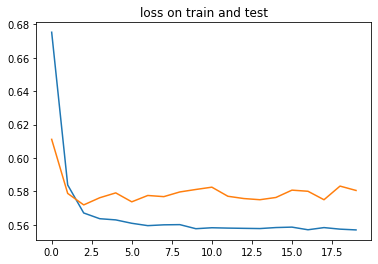

Last loss on train: 0.5570287000289006
Last loss on test: 0.5806242172655306


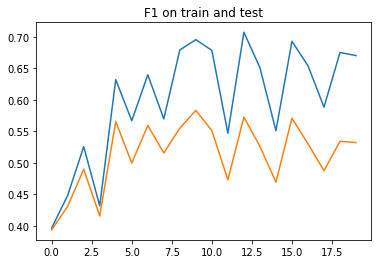

Last F1 on train: 0.6702119552456172
Last F1 on test: 0.5321531036966726


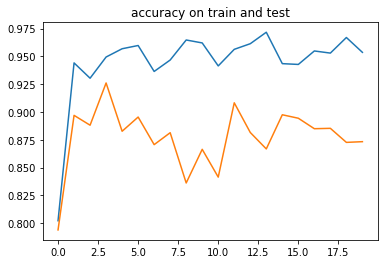

Last accuracy on train: 0.953601844279112
Last accuracy on test: 0.873345149975074


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.92863815652896


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

auf-B keinen-I fall-I .-O
keine-B ahnung-I ,-O schätzungsweise-O nirgendwohin-O .-O
ja-O ,-O aber-O ich-O hab-O das-O gefühl-O ,-O dass-O ihre-O freundin-O ein-O ...-O ein-O zombie-O ist-O ,-O schon-B möglich-I .-O
du-B machst-I witze-I ,-O oder-O ?-O
keine-B ahnung-I .-O
machst-B du-I witze-I ?-O
--O das-B passt-I .-O
klar-B doch-I .-O
ja-O ,-O nicht-B wahr-I ?-O
nein-O ,-O gar-B nicht-I .-O
keine-B ahnung-I .-O
--O ich-B bin-I dabei-I .-O
nein-O ,-O das-B geht-I nicht-I .-O
du-O weißt-O doch-O ,-O dass-O ich-O das-O nicht-O mit-O absicht-O gema-O ...-O ja-O ,-O schon-B klar-I .-O
madame-O kali-O ,-O nicht-B wahr-I ?-O
ja-O ,-O gut-O ,-O in-B ordnung-I ,-O das-O passt-O mir-O sehr-O gut-O ,-O das-O wird-O gehen-O .-O
ja-O ,-O ich-B glaube-I schon-I .-O
tja-O ,-O keine-B ahnung-I .-O
--O nicht-B wirklich-I .-O
na-B gut-I ,-O mein-O schatz-O .-O
--O ganz-B und-I gar-I nicht-I .-O
nicht-B wahr-I ?-O
ich-B glaub-I nicht-I .-O
also-B schön-I ,-O zeigen-O sie-O her-O .-O
ich-B glaube-I scho

# Experiment 4, testing bi-directional 2 cells

* GRU
* bi
* 2 cells
* 1 layer
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = BiGRU_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.005, 1, 1])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


46it [00:02, 19.81it/s]

Train loss: 0.7193648841645982


94it [00:04, 24.17it/s]

Train loss: 0.718341467777888


139it [00:06, 24.16it/s]

Train loss: 0.7177606609132555


184it [00:08, 23.90it/s]

Train loss: 0.7128096236122979


226it [00:09, 23.07it/s]


Train loss: 0.7067052984237671

Evaluating on train...


49it [00:01, 41.29it/s]

Val loss: 0.7177128619617886, Val f1: 0.39241319828563265, Val accuracy: 0.39259260164366827


94it [00:02, 41.26it/s]

Val loss: 0.7047898709774018, Val f1: 0.38502283957269456, Val accuracy: 0.38518519434663984


138it [00:03, 40.31it/s]

Val loss: 0.7023578021261427, Val f1: 0.3677430208082552, Val accuracy: 0.3679012439869068


187it [00:04, 38.97it/s]

Val loss: 0.707008586327235, Val f1: 0.37020584063397516, Val accuracy: 0.37037037975258297


226it [00:05, 39.91it/s]


Val loss: 0.7056091528468662, Val f1: 0.3657630035612318, Val accuracy: 0.3659259353743659

Evaluating on test...


22it [00:00, 38.86it/s]

Val loss: 0.7147864540417989, Val f1: 0.3331533749898275, Val accuracy: 0.3333333432674408


37it [00:00, 39.96it/s]

Val loss: 0.7175383547941844, Val f1: 0.33315344750881193, Val accuracy: 0.3333333432674408


50it [00:01, 40.25it/s]

Val loss: 0.7054067426257663, Val f1: 0.3331695563263363, Val accuracy: 0.3333333432674408


64it [00:01, 39.10it/s]

Val loss: 0.7067007631063461, Val f1: 0.33317003945509593, Val accuracy: 0.3333333432674408


76it [00:01, 39.29it/s]


Val loss: 0.7109360162417094, Val f1: 0.34205223004023233, Val accuracy: 0.3422222320238749

starting Epoch 1
Training...


48it [00:01, 25.06it/s]

Train loss: 0.7014597813288371


93it [00:03, 24.29it/s]

Train loss: 0.7067494127485487


138it [00:05, 25.79it/s]

Train loss: 0.7080538462709498


183it [00:07, 23.91it/s]

Train loss: 0.7056513759824965


226it [00:09, 24.22it/s]


Train loss: 0.7074361748165554

Evaluating on train...


50it [00:01, 43.31it/s]

Val loss: 0.7099783605999417, Val f1: 0.3776092072327932, Val accuracy: 0.3777777870496114


97it [00:02, 38.63it/s]

Val loss: 0.7062258965439266, Val f1: 0.3627998431523641, Val accuracy: 0.36296297245555453


143it [00:03, 40.80it/s]

Val loss: 0.7088985403378805, Val f1: 0.35785823663075766, Val accuracy: 0.35802470092420224


185it [00:04, 37.92it/s]

Val loss: 0.7069286164310243, Val f1: 0.355391598575645, Val accuracy: 0.3555555651585261


226it [00:05, 39.96it/s]


Val loss: 0.7053371601634555, Val f1: 0.36280024727185567, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 37.39it/s]

Val loss: 0.6885058244069417, Val f1: 0.3331957360108693, Val accuracy: 0.3333333432674408


37it [00:00, 38.53it/s]

Val loss: 0.6895586391290028, Val f1: 0.3554158757130305, Val accuracy: 0.3555555651585261


49it [00:01, 36.95it/s]

Val loss: 0.7004450745052762, Val f1: 0.3479953606923421, Val accuracy: 0.34814815786149766


66it [00:01, 38.64it/s]

Val loss: 0.7140700042247772, Val f1: 0.34427453180154166, Val accuracy: 0.3444444542129835


76it [00:02, 37.68it/s]


Val loss: 0.711983273824056, Val f1: 0.3598315684000651, Val accuracy: 0.36000000953674316

starting Epoch 2
Training...


50it [00:02, 24.62it/s]

Train loss: 0.7053993158870273


95it [00:03, 25.68it/s]

Train loss: 0.7098502265082465


140it [00:05, 25.22it/s]

Train loss: 0.7113151757805436


185it [00:07, 24.71it/s]

Train loss: 0.7096908277935452


226it [00:09, 24.40it/s]


Train loss: 0.7055103635787964

Evaluating on train...


50it [00:01, 41.85it/s]

Val loss: 0.6803811258739896, Val f1: 0.37764853570196366, Val accuracy: 0.3777777870496114


95it [00:02, 41.61it/s]

Val loss: 0.6917133688926697, Val f1: 0.35541271368662514, Val accuracy: 0.3555555651585261


140it [00:03, 40.78it/s]

Val loss: 0.6971982240676879, Val f1: 0.3479985493200797, Val accuracy: 0.34814815786149766


187it [00:04, 39.47it/s]

Val loss: 0.7012456725041072, Val f1: 0.3479932453897264, Val accuracy: 0.34814815786149766


226it [00:05, 40.96it/s]


Val loss: 0.704900529384613, Val f1: 0.3509501967165205, Val accuracy: 0.35111112078030904

Evaluating on test...


19it [00:00, 39.79it/s]

Val loss: 0.6937377254168192, Val f1: 0.37762570977210996, Val accuracy: 0.3777777870496114


38it [00:00, 39.84it/s]

Val loss: 0.6970122675100963, Val f1: 0.35540338257948556, Val accuracy: 0.3555555651585261


50it [00:01, 37.84it/s]

Val loss: 0.7026835547553169, Val f1: 0.3628040929635366, Val accuracy: 0.36296297245555453


68it [00:01, 39.34it/s]

Val loss: 0.7181816945473353, Val f1: 0.36648686478535336, Val accuracy: 0.3666666761040688


76it [00:01, 39.17it/s]


Val loss: 0.7103604571024577, Val f1: 0.36871916890144346, Val accuracy: 0.3688888982931773

starting Epoch 3
Training...


50it [00:02, 24.64it/s]

Train loss: 0.6913347641626993


92it [00:03, 25.32it/s]

Train loss: 0.700852757692337


140it [00:05, 25.04it/s]

Train loss: 0.7085282396387171


185it [00:07, 22.86it/s]

Train loss: 0.7074547578891118


226it [00:09, 23.79it/s]


Train loss: 0.7051828577783372

Evaluating on train...


49it [00:01, 41.18it/s]

Val loss: 0.7069676982031928, Val f1: 0.37729186283217536, Val accuracy: 0.3677297982904646


94it [00:02, 40.99it/s]

Val loss: 0.7059081686867608, Val f1: 0.38109374311235217, Val accuracy: 0.37145093083381653


142it [00:03, 37.11it/s]

Val loss: 0.7028385930591159, Val f1: 0.3832353324801834, Val accuracy: 0.37528526849216887


186it [00:04, 37.91it/s]

Val loss: 0.7015118165148629, Val f1: 0.3834197716580497, Val accuracy: 0.3757213552792867


226it [00:05, 40.04it/s]


Val loss: 0.7008627971013387, Val f1: 0.38374190198050606, Val accuracy: 0.3761064663198259

Evaluating on test...


21it [00:00, 38.52it/s]

Val loss: 0.6854694326718648, Val f1: 0.4420716245969137, Val accuracy: 0.4322108606497447


34it [00:00, 39.00it/s]

Val loss: 0.6996647894382477, Val f1: 0.39206253190835316, Val accuracy: 0.38554814259211223


51it [00:01, 39.59it/s]

Val loss: 0.7200402246581183, Val f1: 0.37487606075074936, Val accuracy: 0.3696238398551941


67it [00:01, 38.23it/s]

Val loss: 0.7100951691468557, Val f1: 0.39320395042498907, Val accuracy: 0.38994791557391484


76it [00:01, 38.63it/s]


Val loss: 0.7112101221084595, Val f1: 0.3842419250806173, Val accuracy: 0.38084603190422056

starting Epoch 4
Training...


47it [00:01, 22.02it/s]

Train loss: 0.6881883793407017


95it [00:03, 25.59it/s]

Train loss: 0.6944440179400974


137it [00:05, 24.18it/s]

Train loss: 0.6958380381266276


185it [00:07, 25.03it/s]

Train loss: 0.6976905180348291


226it [00:09, 24.25it/s]


Train loss: 0.6992857954237196

Evaluating on train...


49it [00:01, 42.17it/s]

Val loss: 0.7024420261383056, Val f1: 0.35749143229590524, Val accuracy: 0.35785913997226293


94it [00:02, 41.77it/s]

Val loss: 0.6996807879871793, Val f1: 0.3604480879174338, Val accuracy: 0.35786804788642457


141it [00:03, 39.74it/s]

Val loss: 0.7027933557828268, Val f1: 0.3677650498019324, Val accuracy: 0.3641260034508175


184it [00:05, 33.76it/s]

Val loss: 0.7013031976090537, Val f1: 0.3721816673874855, Val accuracy: 0.367958676483896


226it [00:06, 36.74it/s]


Val loss: 0.7002862996525234, Val f1: 0.37712679757012263, Val accuracy: 0.3722886694802178

Evaluating on test...


20it [00:00, 37.54it/s]

Val loss: 0.7110779762268067, Val f1: 0.358083575963974, Val accuracy: 0.3555151383082072


36it [00:00, 36.33it/s]

Val loss: 0.7111128826936086, Val f1: 0.3770977964003881, Val accuracy: 0.37256217300891875


53it [00:01, 38.78it/s]

Val loss: 0.701275192366706, Val f1: 0.36246206959088645, Val accuracy: 0.35947670804129706


66it [00:01, 38.85it/s]

Val loss: 0.7103289733330409, Val f1: 0.36478019108374915, Val accuracy: 0.360524013141791


76it [00:02, 37.65it/s]


Val loss: 0.7101352175076803, Val f1: 0.3624538985888163, Val accuracy: 0.3580417251586914

starting Epoch 5
Training...


48it [00:01, 24.63it/s]

Train loss: 0.7032984866036309


93it [00:03, 23.86it/s]

Train loss: 0.6961800714333852


138it [00:05, 23.90it/s]

Train loss: 0.7048788304682131


183it [00:07, 25.86it/s]

Train loss: 0.7023161712619993


226it [00:09, 24.32it/s]


Train loss: 0.7024361872673035

Evaluating on train...


50it [00:01, 42.00it/s]

Val loss: 0.7041940967241923, Val f1: 0.35693283279736837, Val accuracy: 0.353794264793396


95it [00:02, 41.31it/s]

Val loss: 0.6990075747172038, Val f1: 0.36077764795886147, Val accuracy: 0.3549810177750058


140it [00:03, 40.91it/s]

Val loss: 0.6975853103178519, Val f1: 0.3684286850470084, Val accuracy: 0.363269136790876


184it [00:04, 37.63it/s]

Val loss: 0.6974105781979031, Val f1: 0.3665566508968671, Val accuracy: 0.36170023414823743


226it [00:05, 39.96it/s]


Val loss: 0.700519376595815, Val f1: 0.3645766466193729, Val accuracy: 0.36026583512624105

Evaluating on test...


21it [00:00, 38.67it/s]

Val loss: 0.776884897549947, Val f1: 0.36082756916681924, Val accuracy: 0.3525619387626648


37it [00:00, 36.78it/s]

Val loss: 0.7361830115318299, Val f1: 0.35811089277267455, Val accuracy: 0.35071164766947427


49it [00:01, 36.79it/s]

Val loss: 0.73893866803911, Val f1: 0.35724268423186406, Val accuracy: 0.34967063797844783


65it [00:01, 38.41it/s]

Val loss: 0.7185095568497976, Val f1: 0.38615419119596484, Val accuracy: 0.380022173623244


76it [00:02, 37.93it/s]


Val loss: 0.7136230103174845, Val f1: 0.3795577323436737, Val accuracy: 0.3736396062374115

starting Epoch 6
Training...


49it [00:01, 25.06it/s]

Train loss: 0.7229104664590623


94it [00:03, 23.68it/s]

Train loss: 0.7101771109633975


139it [00:05, 24.97it/s]

Train loss: 0.7148188966291922


184it [00:07, 24.43it/s]

Train loss: 0.7074712385733922


226it [00:09, 24.20it/s]


Train loss: 0.702258968088362

Evaluating on train...


49it [00:01, 42.03it/s]

Val loss: 0.6821053253279792, Val f1: 0.3722073554992676, Val accuracy: 0.3729231039683024


94it [00:02, 40.10it/s]

Val loss: 0.6867107371489207, Val f1: 0.36486580471197766, Val accuracy: 0.36335428853829704


141it [00:03, 39.67it/s]

Val loss: 0.7002385625132808, Val f1: 0.36052459986121566, Val accuracy: 0.3578007713512138


186it [00:04, 39.81it/s]

Val loss: 0.6993793901469972, Val f1: 0.3669174424476094, Val accuracy: 0.3642013781600528


226it [00:05, 40.58it/s]


Val loss: 0.700673926671346, Val f1: 0.36896394597159493, Val accuracy: 0.36584485716289944

Evaluating on test...


22it [00:00, 37.41it/s]

Val loss: 0.7013317227363587, Val f1: 0.39030246138572694, Val accuracy: 0.38663175503412883


34it [00:00, 37.83it/s]

Val loss: 0.707133561372757, Val f1: 0.37362762093544005, Val accuracy: 0.3692207932472229


50it [00:01, 38.81it/s]

Val loss: 0.7100286139382257, Val f1: 0.3980319102605184, Val accuracy: 0.3925684326224857


67it [00:01, 38.23it/s]

Val loss: 0.7069248795509339, Val f1: 0.39653713901837667, Val accuracy: 0.391177691022555


76it [00:01, 38.38it/s]


Val loss: 0.7043712115287781, Val f1: 0.38885024428367615, Val accuracy: 0.3841930576165517

starting Epoch 7
Training...


48it [00:02, 25.43it/s]

Train loss: 0.7019417828983731


93it [00:03, 25.23it/s]

Train loss: 0.69397398630778


138it [00:05, 24.78it/s]

Train loss: 0.685836398601532


183it [00:07, 25.78it/s]

Train loss: 0.6822548160950342


226it [00:09, 24.42it/s]


Train loss: 0.678332896232605

Evaluating on train...


49it [00:01, 39.52it/s]

Val loss: 0.6449984166357252, Val f1: 0.43442469305462306, Val accuracy: 0.48038254247771367


96it [00:02, 39.70it/s]

Val loss: 0.649382989274131, Val f1: 0.4672012140353521, Val accuracy: 0.5282084789541033


140it [00:03, 38.93it/s]

Val loss: 0.6535091250031083, Val f1: 0.4670450036172514, Val accuracy: 0.527698822595455


187it [00:04, 38.86it/s]

Val loss: 0.6546405755811268, Val f1: 0.4784559362464481, Val accuracy: 0.5319973859522078


226it [00:05, 39.24it/s]


Val loss: 0.658847889635298, Val f1: 0.4780746601687537, Val accuracy: 0.5276971044805315

Evaluating on test...


21it [00:00, 38.44it/s]

Val loss: 0.6780379096666972, Val f1: 0.47433263262112935, Val accuracy: 0.5024391372998556


37it [00:00, 36.32it/s]

Val loss: 0.6666031221548716, Val f1: 0.47894098261992135, Val accuracy: 0.5556368956963221


50it [00:01, 38.19it/s]

Val loss: 0.6661966257625156, Val f1: 0.47302188277244567, Val accuracy: 0.5449910329447852


66it [00:01, 37.85it/s]

Val loss: 0.6642668455839157, Val f1: 0.4714523866772652, Val accuracy: 0.5443844839930534


76it [00:02, 37.79it/s]


Val loss: 0.669996882279714, Val f1: 0.4696901325384776, Val accuracy: 0.5333915547529856

starting Epoch 8
Training...


48it [00:01, 26.07it/s]

Train loss: 0.6430500759018792


93it [00:03, 25.53it/s]

Train loss: 0.6525745040840573


138it [00:05, 24.25it/s]

Train loss: 0.6498276397033974


183it [00:07, 25.70it/s]

Train loss: 0.6411311871475643


226it [00:09, 24.45it/s]


Train loss: 0.6335664701461792

Evaluating on train...


50it [00:01, 39.30it/s]

Val loss: 0.5921544114748637, Val f1: 0.3919262972142961, Val accuracy: 0.8538286063406203


98it [00:02, 40.15it/s]

Val loss: 0.5919640441735585, Val f1: 0.39198806054062313, Val accuracy: 0.8622968349191877


140it [00:03, 39.90it/s]

Val loss: 0.5934174175615664, Val f1: 0.3911311165050224, Val accuracy: 0.8548371615233245


186it [00:04, 39.21it/s]

Val loss: 0.5938020779026879, Val f1: 0.39285413093037075, Val accuracy: 0.8528036312924491


226it [00:05, 38.95it/s]


Val loss: 0.5938046328226725, Val f1: 0.3932140862941742, Val accuracy: 0.8498105781608157

Evaluating on test...


19it [00:00, 40.54it/s]

Val loss: 0.6029683033625285, Val f1: 0.38394355376561484, Val accuracy: 0.823982314268748


34it [00:00, 40.07it/s]

Val loss: 0.5968141218026479, Val f1: 0.39208195606867474, Val accuracy: 0.8562512437502543


52it [00:01, 39.05it/s]

Val loss: 0.6045046885808308, Val f1: 0.3912248962455326, Val accuracy: 0.830095378557841


65it [00:01, 39.54it/s]

Val loss: 0.6052424371242523, Val f1: 0.38569951603809993, Val accuracy: 0.7932909448941549


76it [00:01, 39.25it/s]


Val loss: 0.6062710309028625, Val f1: 0.38789395650227865, Val accuracy: 0.8090398502349854

starting Epoch 9
Training...


48it [00:01, 23.16it/s]

Train loss: 0.5829551815986633


93it [00:03, 23.70it/s]

Train loss: 0.584608589278327


138it [00:05, 24.12it/s]

Train loss: 0.5861681390691686


183it [00:07, 21.37it/s]

Train loss: 0.5833195527394612


226it [00:09, 23.67it/s]


Train loss: 0.5823336897956001

Evaluating on train...


53it [00:01, 41.04it/s]

Val loss: 0.5676353308889601, Val f1: 0.4874726937876807, Val accuracy: 0.9134862714343601


98it [00:02, 41.88it/s]

Val loss: 0.5707374917136299, Val f1: 0.48806051545672946, Val accuracy: 0.8949876818392012


138it [00:03, 40.33it/s]

Val loss: 0.5715130589626454, Val f1: 0.48886842440675804, Val accuracy: 0.8895969216470365


187it [00:04, 40.38it/s]

Val loss: 0.5700910958978865, Val f1: 0.48779116057687333, Val accuracy: 0.9027307727270656


226it [00:05, 40.48it/s]


Val loss: 0.5709557199478149, Val f1: 0.4903945113552941, Val accuracy: 0.9045365533563826

Evaluating on test...


20it [00:00, 40.20it/s]

Val loss: 0.6003459294637045, Val f1: 0.4567956030368805, Val accuracy: 0.8647822737693787


38it [00:00, 39.28it/s]

Val loss: 0.5976502259572347, Val f1: 0.45903509358565014, Val accuracy: 0.8612752119700114


51it [00:01, 39.39it/s]

Val loss: 0.5942497107717726, Val f1: 0.46841492255528766, Val accuracy: 0.8684097766876221


64it [00:01, 38.38it/s]

Val loss: 0.589857296148936, Val f1: 0.47191777229309084, Val accuracy: 0.8872553755839666


76it [00:01, 39.39it/s]


Val loss: 0.5889493290583293, Val f1: 0.4667777132987976, Val accuracy: 0.865922478834788

starting Epoch 10
Training...


48it [00:01, 24.01it/s]

Train loss: 0.5738350219196744


93it [00:03, 25.04it/s]

Train loss: 0.5706541776657105


138it [00:05, 24.97it/s]

Train loss: 0.5720839818318685


183it [00:07, 24.71it/s]

Train loss: 0.5714601165718503


226it [00:09, 24.43it/s]


Train loss: 0.5715985939237807

Evaluating on train...


50it [00:01, 42.94it/s]

Val loss: 0.5705323417981466, Val f1: 0.4467182179292043, Val accuracy: 0.9187584625350105


95it [00:02, 40.95it/s]

Val loss: 0.570564349492391, Val f1: 0.4518877645333608, Val accuracy: 0.9379704806539747


140it [00:03, 41.48it/s]

Val loss: 0.5700826856825086, Val f1: 0.45730863743358185, Val accuracy: 0.9404152834856951


185it [00:04, 40.92it/s]

Val loss: 0.5692324966192246, Val f1: 0.45655240466197333, Val accuracy: 0.9371395256784227


226it [00:05, 41.46it/s]


Val loss: 0.567915190855662, Val f1: 0.45684876097573174, Val accuracy: 0.9363886643780602

Evaluating on test...


22it [00:00, 40.02it/s]

Val loss: 0.5764228979746501, Val f1: 0.4479163229465485, Val accuracy: 0.9461047212282817


34it [00:00, 39.62it/s]

Val loss: 0.5784711221853892, Val f1: 0.4356159597635269, Val accuracy: 0.934259682893753


51it [00:01, 39.42it/s]

Val loss: 0.5820269028345744, Val f1: 0.43310259646839566, Val accuracy: 0.9076525105370415


68it [00:01, 39.32it/s]

Val loss: 0.584569760163625, Val f1: 0.43045987784862516, Val accuracy: 0.8952886000275612


76it [00:01, 39.27it/s]


Val loss: 0.5812812034289042, Val f1: 0.4309459388256073, Val accuracy: 0.9062659784158071

starting Epoch 11
Training...


49it [00:02, 26.14it/s]

Train loss: 0.563220394982232


94it [00:04, 22.51it/s]

Train loss: 0.5647180398305257


139it [00:06, 23.68it/s]

Train loss: 0.5648337390687731


184it [00:07, 25.19it/s]

Train loss: 0.5679327405161327


226it [00:09, 23.54it/s]


Train loss: 0.5682036672698126

Evaluating on train...


49it [00:01, 42.28it/s]

Val loss: 0.5657238589392768, Val f1: 0.5074129535092248, Val accuracy: 0.9506541702482435


94it [00:02, 42.60it/s]

Val loss: 0.5663077361053891, Val f1: 0.500032537844446, Val accuracy: 0.9516953213347329


139it [00:03, 41.22it/s]

Val loss: 0.5656713017710933, Val f1: 0.49941094672238384, Val accuracy: 0.9490900772589225


184it [00:04, 41.34it/s]

Val loss: 0.5650158110592101, Val f1: 0.49380405495564145, Val accuracy: 0.9428279063767857


226it [00:05, 41.74it/s]


Val loss: 0.5646227847205268, Val f1: 0.4939816228548686, Val accuracy: 0.9436787108580271

Evaluating on test...


21it [00:00, 38.43it/s]

Val loss: 0.5774741053581238, Val f1: 0.4659702181816101, Val accuracy: 0.9106396675109864


34it [00:00, 38.26it/s]

Val loss: 0.5761500259240468, Val f1: 0.47192560533682504, Val accuracy: 0.9060798515876134


52it [00:01, 38.96it/s]

Val loss: 0.5762956182161967, Val f1: 0.46999911334779526, Val accuracy: 0.9139619674947527


65it [00:01, 39.61it/s]

Val loss: 0.5786579271157583, Val f1: 0.4677445481220881, Val accuracy: 0.8989034071564674


76it [00:01, 38.97it/s]


Val loss: 0.5830256883303324, Val f1: 0.45958742141723635, Val accuracy: 0.8714441295464833

starting Epoch 12
Training...


48it [00:01, 24.14it/s]

Train loss: 0.56235212220086


93it [00:03, 22.97it/s]

Train loss: 0.5627482387754652


138it [00:05, 23.42it/s]

Train loss: 0.5648574255130909


183it [00:07, 25.36it/s]

Train loss: 0.5658008515834808


226it [00:09, 24.51it/s]


Train loss: 0.5650480341911316

Evaluating on train...


50it [00:01, 43.81it/s]

Val loss: 0.5635109927919176, Val f1: 0.5493041462368435, Val accuracy: 0.9113479514916738


95it [00:02, 41.81it/s]

Val loss: 0.563073890739017, Val f1: 0.5512995349036323, Val accuracy: 0.929588782787323


140it [00:03, 36.70it/s]

Val loss: 0.5631310511518408, Val f1: 0.5585338777965969, Val accuracy: 0.9287952063260255


184it [00:04, 41.70it/s]

Val loss: 0.5624029613203473, Val f1: 0.5569535233908229, Val accuracy: 0.9318398614724477


226it [00:05, 41.46it/s]


Val loss: 0.5621805434756809, Val f1: 0.5550108777152167, Val accuracy: 0.9346000860797035

Evaluating on test...


23it [00:00, 39.98it/s]

Val loss: 0.5620640039443969, Val f1: 0.5451579868793488, Val accuracy: 0.9712339242299398


37it [00:00, 39.81it/s]

Val loss: 0.575631340344747, Val f1: 0.5171974509954452, Val accuracy: 0.8944805532693862


49it [00:01, 38.41it/s]

Val loss: 0.5745561387803819, Val f1: 0.5185953517754872, Val accuracy: 0.9062680330541398


65it [00:01, 38.84it/s]

Val loss: 0.5753208567698797, Val f1: 0.5130667110284169, Val accuracy: 0.8781064758698146


76it [00:01, 39.24it/s]


Val loss: 0.5788270163536072, Val f1: 0.5084948174158732, Val accuracy: 0.8641316545009613

starting Epoch 13
Training...


48it [00:01, 25.43it/s]

Train loss: 0.5582815024587843


93it [00:03, 26.50it/s]

Train loss: 0.5605929089917077


138it [00:05, 23.33it/s]

Train loss: 0.5622507585419549


183it [00:07, 22.69it/s]

Train loss: 0.56186024679078


226it [00:09, 24.44it/s]


Train loss: 0.5630626646677653

Evaluating on train...


50it [00:01, 40.82it/s]

Val loss: 0.5594330337312486, Val f1: 0.48050877981715734, Val accuracy: 0.9623410642147064


95it [00:02, 40.30it/s]

Val loss: 0.5635908703009288, Val f1: 0.46889535950289835, Val accuracy: 0.9638813306887944


141it [00:03, 39.86it/s]

Val loss: 0.5625236877688655, Val f1: 0.4715700096554226, Val accuracy: 0.9613576752168161


185it [00:04, 40.28it/s]

Val loss: 0.5617900000678169, Val f1: 0.46988567776150175, Val accuracy: 0.9605773698952463


226it [00:05, 40.21it/s]


Val loss: 0.5616422769758437, Val f1: 0.46973909735679625, Val accuracy: 0.9634218569596609

Evaluating on test...


22it [00:00, 38.98it/s]

Val loss: 0.5708271741867066, Val f1: 0.4422028839588165, Val accuracy: 0.9666251738866171


36it [00:00, 37.31it/s]

Val loss: 0.5765945613384247, Val f1: 0.43494629164536797, Val accuracy: 0.9426548898220062


52it [00:01, 37.52it/s]

Val loss: 0.5761404580540127, Val f1: 0.43902720014254254, Val accuracy: 0.9448566979832119


65it [00:01, 38.59it/s]

Val loss: 0.5739284565051397, Val f1: 0.43619006623824436, Val accuracy: 0.926971294482549


76it [00:01, 38.43it/s]


Val loss: 0.5735798414548238, Val f1: 0.4364759723345439, Val accuracy: 0.9244008302688599

starting Epoch 14
Training...


48it [00:01, 26.04it/s]

Train loss: 0.5646688911649916


93it [00:03, 25.43it/s]

Train loss: 0.5615421897835202


138it [00:05, 24.27it/s]

Train loss: 0.5613934583134121


183it [00:07, 24.84it/s]

Train loss: 0.5608167714542813


226it [00:09, 24.56it/s]


Train loss: 0.5614338313208685

Evaluating on train...


49it [00:01, 43.05it/s]

Val loss: 0.5615423480669658, Val f1: 0.5751956350273556, Val accuracy: 0.9043249580595228


94it [00:02, 42.14it/s]

Val loss: 0.5601373930772146, Val f1: 0.5830873231093089, Val accuracy: 0.9299237171808878


141it [00:03, 39.33it/s]

Val loss: 0.5599699748886956, Val f1: 0.5760077176270662, Val accuracy: 0.9340668572319879


185it [00:04, 38.72it/s]

Val loss: 0.5596389763885075, Val f1: 0.5778255836831199, Val accuracy: 0.939316477212641


226it [00:05, 40.53it/s]


Val loss: 0.5591649219724867, Val f1: 0.5752396003405253, Val accuracy: 0.9369077887800005

Evaluating on test...


21it [00:00, 39.29it/s]

Val loss: 0.5868695259094239, Val f1: 0.5347262899080912, Val accuracy: 0.8840896964073182


34it [00:00, 39.72it/s]

Val loss: 0.5807686905066173, Val f1: 0.5219064772129058, Val accuracy: 0.9051286995410919


50it [00:01, 38.44it/s]

Val loss: 0.5820516400867038, Val f1: 0.5138610303401947, Val accuracy: 0.8971966379218631


66it [00:01, 38.03it/s]

Val loss: 0.5777033011118571, Val f1: 0.5088903297980626, Val accuracy: 0.9104523941874504


76it [00:01, 38.65it/s]


Val loss: 0.5763205122947693, Val f1: 0.5048564521471659, Val accuracy: 0.9067669220765432

starting Epoch 15
Training...


48it [00:01, 25.31it/s]

Train loss: 0.5574597186512418


93it [00:03, 24.65it/s]

Train loss: 0.5588042305575477


138it [00:05, 24.39it/s]

Train loss: 0.558559364742703


183it [00:07, 24.35it/s]

Train loss: 0.5593933827347226


226it [00:09, 24.57it/s]


Train loss: 0.5598448019557529

Evaluating on train...


51it [00:01, 39.88it/s]

Val loss: 0.5575266573164198, Val f1: 0.6525503436724345, Val accuracy: 0.9678168363041348


96it [00:02, 40.48it/s]

Val loss: 0.5575155867470636, Val f1: 0.6379271904627483, Val accuracy: 0.9530790623691346


139it [00:03, 38.45it/s]

Val loss: 0.5578773732538577, Val f1: 0.630169152771985, Val accuracy: 0.9474387248357137


185it [00:04, 38.66it/s]

Val loss: 0.5580027143160502, Val f1: 0.6269819186793433, Val accuracy: 0.9443078766266505


226it [00:06, 37.34it/s]


Val loss: 0.5581120578447978, Val f1: 0.6289763591024611, Val accuracy: 0.9517371386951871

Evaluating on test...


21it [00:00, 38.59it/s]

Val loss: 0.5744522372881572, Val f1: 0.5564836442470551, Val accuracy: 0.9140124519666036


37it [00:00, 38.07it/s]

Val loss: 0.5726767381032308, Val f1: 0.5627337137858073, Val accuracy: 0.9284371435642242


49it [00:01, 37.80it/s]

Val loss: 0.576108984152476, Val f1: 0.5633835560745664, Val accuracy: 0.9193162547217475


66it [00:01, 38.20it/s]

Val loss: 0.5774027744928996, Val f1: 0.5486816401282947, Val accuracy: 0.901044466594855


76it [00:02, 37.71it/s]


Val loss: 0.5745847098032634, Val f1: 0.5483833352724711, Val accuracy: 0.900723603963852

starting Epoch 16
Training...


48it [00:02, 25.02it/s]

Train loss: 0.5558212982283698


93it [00:03, 24.79it/s]

Train loss: 0.5565876099798415


138it [00:05, 25.41it/s]

Train loss: 0.5571724966720298


183it [00:07, 24.54it/s]

Train loss: 0.5594331522782644


226it [00:09, 24.34it/s]


Train loss: 0.5599616649415758

Evaluating on train...


50it [00:01, 41.88it/s]

Val loss: 0.5584000203344557, Val f1: 0.5867283033000098, Val accuracy: 0.9498341931237115


94it [00:02, 38.49it/s]

Val loss: 0.5597386148240832, Val f1: 0.5729761905140347, Val accuracy: 0.9196189655197992


141it [00:03, 39.44it/s]

Val loss: 0.5585486831488433, Val f1: 0.5726322754665657, Val accuracy: 0.9389507953767423


184it [00:04, 40.41it/s]

Val loss: 0.5584422280391057, Val f1: 0.5729059856798914, Val accuracy: 0.935685411757893


226it [00:05, 39.80it/s]


Val loss: 0.5583216794331869, Val f1: 0.5730875815285577, Val accuracy: 0.9375755058394538

Evaluating on test...


21it [00:00, 39.03it/s]

Val loss: 0.5806328733762105, Val f1: 0.5297834833463033, Val accuracy: 0.9281264185905457


34it [00:00, 39.19it/s]

Val loss: 0.572621864080429, Val f1: 0.49982720911502837, Val accuracy: 0.8813046554724375


50it [00:01, 37.00it/s]

Val loss: 0.5739663163820903, Val f1: 0.49715983668963115, Val accuracy: 0.8823734124501547


66it [00:01, 37.80it/s]

Val loss: 0.5753131558497747, Val f1: 0.5047393297155698, Val accuracy: 0.8936258186896642


76it [00:01, 38.31it/s]


Val loss: 0.5748637278874715, Val f1: 0.5017407302061717, Val accuracy: 0.891577252149582

starting Epoch 17
Training...


48it [00:02, 24.55it/s]

Train loss: 0.5580534749560886


93it [00:03, 24.79it/s]

Train loss: 0.5571087082227071


138it [00:05, 24.83it/s]

Train loss: 0.5584197017881606


183it [00:07, 24.97it/s]

Train loss: 0.5582735356357362


226it [00:09, 24.31it/s]


Train loss: 0.55850168466568

Evaluating on train...


49it [00:01, 41.41it/s]

Val loss: 0.5597024520238241, Val f1: 0.5577664322323269, Val accuracy: 0.9749393436643813


94it [00:02, 41.41it/s]

Val loss: 0.5595704230997297, Val f1: 0.5483843955728743, Val accuracy: 0.9346268670426474


139it [00:03, 39.94it/s]

Val loss: 0.5593253948070385, Val f1: 0.5497716791099972, Val accuracy: 0.9375110813864955


187it [00:04, 38.21it/s]

Val loss: 0.558520859811041, Val f1: 0.5456721509496371, Val accuracy: 0.9479008341828982


226it [00:05, 40.13it/s]


Val loss: 0.5583113572332594, Val f1: 0.5473767389191522, Val accuracy: 0.9490731373098161

Evaluating on test...


21it [00:00, 37.55it/s]

Val loss: 0.581424880027771, Val f1: 0.43575935761133827, Val accuracy: 0.7915943662325541


37it [00:00, 37.40it/s]

Val loss: 0.5776893436908722, Val f1: 0.45575340191523234, Val accuracy: 0.8465699076652526


49it [00:01, 37.42it/s]

Val loss: 0.5721117417017619, Val f1: 0.4582409514321221, Val accuracy: 0.8785317765341865


66it [00:01, 39.28it/s]

Val loss: 0.571463922659556, Val f1: 0.4654421642422676, Val accuracy: 0.8981332242488861


76it [00:01, 38.24it/s]


Val loss: 0.5720008222262064, Val f1: 0.46940209190050763, Val accuracy: 0.8998084870974222

starting Epoch 18
Training...


48it [00:01, 24.28it/s]

Train loss: 0.558017286989424


93it [00:03, 25.03it/s]

Train loss: 0.5582289695739746


138it [00:05, 25.21it/s]

Train loss: 0.5577646317305388


183it [00:07, 25.69it/s]

Train loss: 0.5584583534134759


226it [00:09, 24.46it/s]


Train loss: 0.5581190013885498

Evaluating on train...


50it [00:01, 40.75it/s]

Val loss: 0.556991187731425, Val f1: 0.5989997651841905, Val accuracy: 0.988934048016866


95it [00:02, 41.58it/s]

Val loss: 0.5577626208464305, Val f1: 0.6002875179052353, Val accuracy: 0.9783091472254859


142it [00:03, 40.14it/s]

Val loss: 0.5571185690385324, Val f1: 0.604714689652125, Val accuracy: 0.9828981704182095


188it [00:04, 39.81it/s]

Val loss: 0.5573297510544459, Val f1: 0.5924352867735757, Val accuracy: 0.9612663921382693


226it [00:05, 40.13it/s]


Val loss: 0.5573462507459852, Val f1: 0.590977818303638, Val accuracy: 0.9559580049249861

Evaluating on test...


22it [00:00, 39.07it/s]

Val loss: 0.5806605339050293, Val f1: 0.47269384066263836, Val accuracy: 0.9203021009763082


34it [00:00, 36.99it/s]

Val loss: 0.5733421345551809, Val f1: 0.482110674182574, Val accuracy: 0.9197800109783808


51it [00:01, 38.07it/s]

Val loss: 0.5739827315012614, Val f1: 0.48453563186857435, Val accuracy: 0.9199671394295162


67it [00:01, 38.74it/s]

Val loss: 0.5764127016067505, Val f1: 0.4913325111071269, Val accuracy: 0.9183694218595823


76it [00:01, 38.57it/s]


Val loss: 0.57504607518514, Val f1: 0.49521826187769574, Val accuracy: 0.9259826719760895

starting Epoch 19
Training...


48it [00:01, 24.94it/s]

Train loss: 0.5583096543947855


93it [00:03, 25.29it/s]

Train loss: 0.5588709579573737


138it [00:05, 25.20it/s]

Train loss: 0.5574693428145514


183it [00:07, 24.81it/s]

Train loss: 0.5576475934849845


226it [00:09, 24.47it/s]


Train loss: 0.5571932988696628

Evaluating on train...


52it [00:01, 41.07it/s]

Val loss: 0.5581969181696574, Val f1: 0.5901697311136458, Val accuracy: 0.9708373659186893


97it [00:02, 40.73it/s]

Val loss: 0.5576459719075098, Val f1: 0.5844506598181195, Val accuracy: 0.9731495089001125


142it [00:03, 40.31it/s]

Val loss: 0.5565394891632928, Val f1: 0.5818825734986199, Val accuracy: 0.976797491091269


184it [00:04, 40.30it/s]

Val loss: 0.5570156239800983, Val f1: 0.5730412277910445, Val accuracy: 0.9714555602934626


226it [00:05, 40.59it/s]


Val loss: 0.5567485539118449, Val f1: 0.5736131313112047, Val accuracy: 0.973298378917906

Evaluating on test...


19it [00:00, 40.72it/s]

Val loss: 0.5723340312639872, Val f1: 0.4739617983500163, Val accuracy: 0.951362943649292


38it [00:00, 39.55it/s]

Val loss: 0.5742428322633107, Val f1: 0.4785468061765035, Val accuracy: 0.9441836496194204


51it [00:01, 39.61it/s]

Val loss: 0.5756643467479282, Val f1: 0.48365433149867587, Val accuracy: 0.9427874922752381


64it [00:01, 39.09it/s]

Val loss: 0.5737118264039357, Val f1: 0.4836106523871422, Val accuracy: 0.9237580786148707


76it [00:01, 39.40it/s]

Val loss: 0.5731717149416605, Val f1: 0.4820434665679932, Val accuracy: 0.9309680843353272


## Graphics

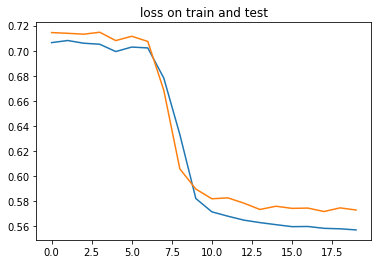

Last loss on train: 0.5572157533822861
Last loss on test: 0.5730689936562589


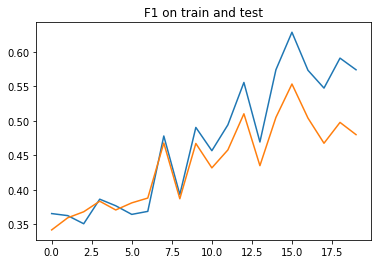

Last F1 on train: 0.5741024898216788
Last F1 on test: 0.48005426557440506


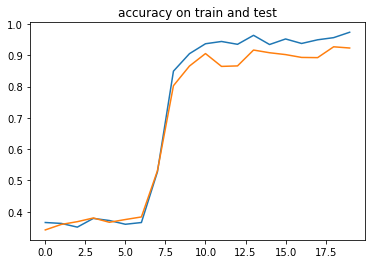

Last accuracy on train: 0.9734127061293188
Last accuracy on test: 0.9230399696450484


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.8883122275275067


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

na-B schön-I ,-O aber-O als-O jemand-O ,-O dem-O etwas-O an-O dir-O liegt-O ,-O sag-O ich-O dir-O :-O --O du-O hast-O ernste-O probleme-O mit-O männern-O .-O
das-B stimmt-I ,-O ja-O .-O
--O es-O ist-O der-O pickel-O ,-O nicht-B wahr-I ?-O
--O stimmt-B 's-I ?-O
schon-B gut-I .-O
ist-B schon-I gut-I ,-O ok.-O ich-O war-O darauf-O vorbereitet-O .-O
--O keine-B ahnung-I .-O
also-O werden-O wir-O sie-O daran-O erinnern-O ,-O nicht-B wahr-I ?-O
ich-O brauch-O keine-O ,-O stimmt-B 's-I ?-O
keine-B ahnung-I .-O
klar-B doch-I .-O
sie-B haben-I recht-I ,-O es-O ist-O nichts-O besonderes-O .-O
ist-B gut-I .-O
ist-B schon-I gut-I .-O
ach-B ja-I ?-O
--O das-O ist-O sein-O name-O ,-O nicht-B wahr-I ?-O
phoebe-O ...-O --O ja-O ,-O ich-B bin-I draußen-I .-O
--O hör-B auf-I !-O
--O das-B stimmt-I nicht-I .-O
hör-B auf-I !-O
ja-O ,-O ich-B verstehe-I .-O
also-B gut-I .-O
damit-O ist-O das-O mädchen-O erwürgt-O worden-O stimmt-B 's-I ,-O martin-O ?-O
na-B und-I ?-O
--O ist-B ja-I schon-I gut-I .-O
--O ac

# Experiment 5, testing embeddings

* GRU
* bi
* 2 cells
* 1 layer
* 1 sentence limitation
* 5 tokens limitation
* embeddings

## Training

In [ ]:
model = BiGRU_2Cells_Embs(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, weights=weights, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.005, 1, 1])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


48it [00:02, 24.79it/s]

Train loss: 0.7081462131606208


93it [00:04, 18.72it/s]

Train loss: 0.7055232425530752


139it [00:06, 21.09it/s]

Train loss: 0.7091798800009268


182it [00:08, 19.55it/s]

Train loss: 0.7056677377886242


226it [00:11, 20.18it/s]


Train loss: 0.7063093649016486

Evaluating on train...


49it [00:01, 40.17it/s]

Val loss: 0.7020052168104384, Val f1: 0.3479916897084978, Val accuracy: 0.34814815786149766


94it [00:02, 39.98it/s]

Val loss: 0.6921751201152802, Val f1: 0.3554102467166053, Val accuracy: 0.3555555651585261


138it [00:03, 39.28it/s]

Val loss: 0.7022884179044653, Val f1: 0.36774290667639836, Val accuracy: 0.3679012439869068


186it [00:04, 39.05it/s]

Val loss: 0.7041469216346741, Val f1: 0.37391326642698713, Val accuracy: 0.3740740834010972


226it [00:05, 38.28it/s]


Val loss: 0.7046722266409132, Val f1: 0.37465373264418705, Val accuracy: 0.37481482413080003

Evaluating on test...


20it [00:00, 38.23it/s]

Val loss: 0.7093098203341166, Val f1: 0.3331628342469533, Val accuracy: 0.3333333432674408


36it [00:00, 37.40it/s]

Val loss: 0.6967940708001454, Val f1: 0.3553965538740158, Val accuracy: 0.3555555651585261


52it [00:01, 37.78it/s]

Val loss: 0.700133130285475, Val f1: 0.36280316842926874, Val accuracy: 0.36296297245555453


64it [00:01, 37.66it/s]

Val loss: 0.7094097167253495, Val f1: 0.3664954816301664, Val accuracy: 0.3666666761040688


76it [00:02, 37.85it/s]


Val loss: 0.7141476964950562, Val f1: 0.3598235448201497, Val accuracy: 0.36000000953674316

starting Epoch 1
Training...


47it [00:01, 22.27it/s]

Train loss: 0.7115873601701524


95it [00:03, 25.13it/s]

Train loss: 0.7092083500491249


137it [00:05, 23.96it/s]

Train loss: 0.7060653894035904


185it [00:07, 24.66it/s]

Train loss: 0.7048728807104958


226it [00:09, 24.05it/s]


Train loss: 0.7050173751513164

Evaluating on train...


52it [00:01, 43.16it/s]

Val loss: 0.7242792354689704, Val f1: 0.33314750856823394, Val accuracy: 0.3333333432674408


97it [00:02, 38.93it/s]

Val loss: 0.7144416411717732, Val f1: 0.34056745602024924, Val accuracy: 0.34074075056446923


142it [00:03, 38.14it/s]

Val loss: 0.7095974847122475, Val f1: 0.3430432895819346, Val accuracy: 0.3432098863301454


185it [00:04, 38.18it/s]

Val loss: 0.7058324555555979, Val f1: 0.36650399731265176, Val accuracy: 0.3666666761040688


226it [00:05, 39.58it/s]


Val loss: 0.704684382809533, Val f1: 0.36280195593833925, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 38.37it/s]

Val loss: 0.7087876796722412, Val f1: 0.33316882054011027, Val accuracy: 0.3333333432674408


35it [00:00, 40.33it/s]

Val loss: 0.7003777106602986, Val f1: 0.37762219409147896, Val accuracy: 0.3777777870496114


50it [00:01, 40.07it/s]

Val loss: 0.7107028285662333, Val f1: 0.3627931336561839, Val accuracy: 0.36296297245555453


67it [00:01, 39.06it/s]

Val loss: 0.7077831129233042, Val f1: 0.355390069882075, Val accuracy: 0.3555555651585261


76it [00:01, 39.66it/s]


Val loss: 0.7134549554189046, Val f1: 0.35093879024187724, Val accuracy: 0.35111112078030904

starting Epoch 2
Training...


48it [00:01, 25.34it/s]

Train loss: 0.7075241009394327


93it [00:03, 25.38it/s]

Train loss: 0.7167670031388601


138it [00:05, 22.17it/s]

Train loss: 0.7130205035209656


183it [00:07, 25.02it/s]

Train loss: 0.7063005831506517


226it [00:09, 23.08it/s]


Train loss: 0.7068927743699815

Evaluating on train...


49it [00:01, 33.87it/s]

Val loss: 0.7117576400438944, Val f1: 0.3776069939136505, Val accuracy: 0.3777777870496114


95it [00:02, 39.22it/s]

Val loss: 0.7231294605467055, Val f1: 0.3553716321786245, Val accuracy: 0.3555555651585261


141it [00:04, 38.05it/s]

Val loss: 0.7143736954088564, Val f1: 0.3529139035277896, Val accuracy: 0.35308642939284995


185it [00:05, 38.07it/s]

Val loss: 0.7117406507333119, Val f1: 0.355386197898123, Val accuracy: 0.3555555651585261


226it [00:06, 36.21it/s]


Val loss: 0.7057952282163832, Val f1: 0.3568754051791297, Val accuracy: 0.3570370466179318

Evaluating on test...


20it [00:00, 38.22it/s]

Val loss: 0.7357233603795369, Val f1: 0.3775799791018168, Val accuracy: 0.3777777870496114


36it [00:00, 36.60it/s]

Val loss: 0.705266531308492, Val f1: 0.3553965171178182, Val accuracy: 0.3555555651585261


52it [00:01, 38.43it/s]

Val loss: 0.7100744724273682, Val f1: 0.36279540657997134, Val accuracy: 0.36296297245555453


64it [00:01, 37.34it/s]

Val loss: 0.7130694121122361, Val f1: 0.35538298934698104, Val accuracy: 0.3555555651585261


76it [00:02, 37.44it/s]


Val loss: 0.7133824626604716, Val f1: 0.35093924045562747, Val accuracy: 0.35111112078030904

starting Epoch 3
Training...


47it [00:01, 24.26it/s]

Train loss: 0.6866226514180501


95it [00:03, 25.45it/s]

Train loss: 0.6886698815557691


140it [00:05, 22.88it/s]

Train loss: 0.6964597971351059


182it [00:07, 25.00it/s]

Train loss: 0.6997533563110564


226it [00:09, 24.56it/s]


Train loss: 0.7038191339704726

Evaluating on train...


49it [00:01, 42.16it/s]

Val loss: 0.7055272036128574, Val f1: 0.37761281265152824, Val accuracy: 0.3777777870496114


94it [00:02, 40.81it/s]

Val loss: 0.7036693917380439, Val f1: 0.37020957039462193, Val accuracy: 0.37037037975258297


139it [00:03, 40.41it/s]

Val loss: 0.7075015995237562, Val f1: 0.37267380445091813, Val accuracy: 0.3728395155182591


185it [00:04, 39.80it/s]

Val loss: 0.7044306758377287, Val f1: 0.3850239604711533, Val accuracy: 0.38518519434663984


226it [00:05, 40.66it/s]


Val loss: 0.7046301338407729, Val f1: 0.37465381238195633, Val accuracy: 0.37481482413080003

Evaluating on test...


20it [00:00, 41.20it/s]

Val loss: 0.7367709318796793, Val f1: 0.3331369658311208, Val accuracy: 0.3333333432674408


34it [00:00, 39.52it/s]

Val loss: 0.7265468637148539, Val f1: 0.33314915796120964, Val accuracy: 0.3333333432674408


51it [00:01, 39.56it/s]

Val loss: 0.7171728809674581, Val f1: 0.33316123286883037, Val accuracy: 0.3333333432674408


64it [00:01, 39.03it/s]

Val loss: 0.718041921655337, Val f1: 0.333160230020682, Val accuracy: 0.3333333432674408


76it [00:01, 39.84it/s]


Val loss: 0.7105710291862488, Val f1: 0.34205724954605105, Val accuracy: 0.3422222320238749

starting Epoch 4
Training...


48it [00:02, 23.27it/s]

Train loss: 0.706910596953498


93it [00:03, 23.67it/s]

Train loss: 0.7130694230397542


138it [00:05, 24.19it/s]

Train loss: 0.7123360881098995


183it [00:07, 25.04it/s]

Train loss: 0.7129627009232838


226it [00:09, 24.60it/s]


Train loss: 0.707344216770596

Evaluating on train...


50it [00:01, 42.30it/s]

Val loss: 0.7137171241972181, Val f1: 0.34797670841217043, Val accuracy: 0.34814815786149766


95it [00:02, 42.14it/s]

Val loss: 0.7165473163127899, Val f1: 0.34797285033596886, Val accuracy: 0.34814815786149766


140it [00:03, 40.10it/s]

Val loss: 0.7142255354810644, Val f1: 0.35785208013322617, Val accuracy: 0.35802470092420224


187it [00:04, 39.52it/s]

Val loss: 0.7125130643447241, Val f1: 0.3590892338090473, Val accuracy: 0.35925926880704034


226it [00:05, 41.27it/s]


Val loss: 0.7063336123360527, Val f1: 0.36576268513997395, Val accuracy: 0.3659259353743659

Evaluating on test...


23it [00:00, 39.87it/s]

Val loss: 0.7063546617825825, Val f1: 0.3331748763720194, Val accuracy: 0.3333333432674408


35it [00:00, 39.19it/s]

Val loss: 0.6974192837874095, Val f1: 0.3998481829961141, Val accuracy: 0.4000000089406967


52it [00:01, 37.84it/s]

Val loss: 0.7015055086877611, Val f1: 0.37762277324994403, Val accuracy: 0.3777777870496114


65it [00:01, 38.51it/s]

Val loss: 0.7091565320889155, Val f1: 0.3665023475885391, Val accuracy: 0.3666666761040688


76it [00:01, 39.01it/s]


Val loss: 0.7163637566566468, Val f1: 0.3687130582332611, Val accuracy: 0.3688888982931773

starting Epoch 5
Training...


48it [00:02, 25.03it/s]

Train loss: 0.7064723120795355


93it [00:04, 19.63it/s]

Train loss: 0.7047853423489465


137it [00:06, 19.36it/s]

Train loss: 0.7093087311144228


184it [00:08, 22.82it/s]

Train loss: 0.7113174912002351


226it [00:10, 20.64it/s]


Train loss: 0.7053572577900357

Evaluating on train...


48it [00:01, 26.36it/s]

Val loss: 0.69513920545578, Val f1: 0.37763089736302696, Val accuracy: 0.3777777870496114


97it [00:03, 36.14it/s]

Val loss: 0.706202859348721, Val f1: 0.3776157428820928, Val accuracy: 0.3777777870496114


140it [00:04, 38.42it/s]

Val loss: 0.7022369932245325, Val f1: 0.3776209517761513, Val accuracy: 0.3777777870496114


186it [00:05, 40.43it/s]

Val loss: 0.7065964000092613, Val f1: 0.3665041731463538, Val accuracy: 0.3666666761040688


226it [00:06, 33.85it/s]


Val loss: 0.7059876214133368, Val f1: 0.3628014756573571, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 41.27it/s]

Val loss: 0.7224044640858968, Val f1: 0.3331543425718943, Val accuracy: 0.3333333432674408


35it [00:00, 41.11it/s]

Val loss: 0.7264569878578186, Val f1: 0.33314626415570575, Val accuracy: 0.3333333432674408


49it [00:01, 39.75it/s]

Val loss: 0.7197478347354465, Val f1: 0.36278318299187556, Val accuracy: 0.36296297245555453


66it [00:01, 38.92it/s]

Val loss: 0.720792626341184, Val f1: 0.3553757260243098, Val accuracy: 0.3555555651585261


76it [00:01, 40.05it/s]


Val loss: 0.711739813486735, Val f1: 0.35094189286231997, Val accuracy: 0.35111112078030904

starting Epoch 6
Training...


48it [00:02, 20.32it/s]

Train loss: 0.7063093874189589


93it [00:04, 20.63it/s]

Train loss: 0.706169593334198


138it [00:06, 21.76it/s]

Train loss: 0.7075156931523924


183it [00:08, 22.85it/s]

Train loss: 0.7044453048043781


226it [00:10, 22.14it/s]


Train loss: 0.7051367833879258

Evaluating on train...


49it [00:01, 41.77it/s]

Val loss: 0.7007495019170973, Val f1: 0.3479899267355601, Val accuracy: 0.34814815786149766


92it [00:02, 31.69it/s]

Val loss: 0.6991914199458228, Val f1: 0.35540118051899805, Val accuracy: 0.3555555651585261


139it [00:04, 24.11it/s]

Val loss: 0.7029765513208177, Val f1: 0.3479891432656182, Val accuracy: 0.34814815786149766


186it [00:06, 28.99it/s]

Val loss: 0.7014524741305246, Val f1: 0.35910214185714723, Val accuracy: 0.35925926880704034


226it [00:07, 31.30it/s]


Val loss: 0.7036796930101182, Val f1: 0.3598402937253316, Val accuracy: 0.36000000953674316

Evaluating on test...


20it [00:00, 38.23it/s]

Val loss: 0.7210296511650085, Val f1: 0.333156023422877, Val accuracy: 0.3333333432674408


37it [00:00, 39.55it/s]

Val loss: 0.7074234346548717, Val f1: 0.3553929656744003, Val accuracy: 0.3555555651585261


49it [00:01, 38.51it/s]

Val loss: 0.7101267457008362, Val f1: 0.3479826112588247, Val accuracy: 0.34814815786149766


61it [00:01, 30.99it/s]

Val loss: 0.7124623388051987, Val f1: 0.3470531950394313, Val accuracy: 0.3472222318251928


76it [00:02, 32.77it/s]


Val loss: 0.7107877039909363, Val f1: 0.3442781984806061, Val accuracy: 0.3444444541136424

starting Epoch 7
Training...


46it [00:02, 21.04it/s]

Train loss: 0.7058805677625868


94it [00:04, 20.67it/s]

Train loss: 0.7023719271024068


139it [00:06, 23.57it/s]

Train loss: 0.7039541509416368


184it [00:08, 25.00it/s]

Train loss: 0.7009957439369625


226it [00:10, 21.41it/s]


Train loss: 0.7055696890089247

Evaluating on train...


49it [00:01, 32.96it/s]

Val loss: 0.7080248011483087, Val f1: 0.34798297352261015, Val accuracy: 0.34814815786149766


95it [00:03, 24.64it/s]

Val loss: 0.7085410667790307, Val f1: 0.34057449201742807, Val accuracy: 0.34074075056446923


140it [00:05, 24.82it/s]

Val loss: 0.7038488511685972, Val f1: 0.3529261103382817, Val accuracy: 0.35308642939284995


182it [00:06, 24.30it/s]

Val loss: 0.7046233991781871, Val f1: 0.35909801175196965, Val accuracy: 0.35925926880704034


226it [00:08, 26.38it/s]


Val loss: 0.7034229609701369, Val f1: 0.3657661751906077, Val accuracy: 0.3659259353743659

Evaluating on test...


20it [00:00, 36.11it/s]

Val loss: 0.7090110977490743, Val f1: 0.3331704338391622, Val accuracy: 0.3333333432674408


36it [00:01, 35.40it/s]

Val loss: 0.7107563197612763, Val f1: 0.3553890933593114, Val accuracy: 0.3555555651585261


52it [00:01, 36.10it/s]

Val loss: 0.7147438353962369, Val f1: 0.34797678722275627, Val accuracy: 0.34814815786149766


64it [00:01, 36.21it/s]

Val loss: 0.7154844999313354, Val f1: 0.355382876098156, Val accuracy: 0.3555555651585261


76it [00:02, 36.64it/s]


Val loss: 0.7111788217226664, Val f1: 0.3509445861975352, Val accuracy: 0.35111112078030904

starting Epoch 8
Training...


47it [00:01, 25.28it/s]

Train loss: 0.708219936158922


92it [00:03, 23.47it/s]

Train loss: 0.7080891880724165


140it [00:05, 24.49it/s]

Train loss: 0.702604517671797


185it [00:07, 24.99it/s]

Train loss: 0.7078466263082293


226it [00:09, 24.09it/s]


Train loss: 0.7051786306169298

Evaluating on train...


50it [00:01, 41.65it/s]

Val loss: 0.7029061886999343, Val f1: 0.34798922075165645, Val accuracy: 0.34814815786149766


94it [00:02, 39.50it/s]

Val loss: 0.7000867949591743, Val f1: 0.35539998047881655, Val accuracy: 0.3555555651585261


141it [00:03, 38.66it/s]

Val loss: 0.7079901032977634, Val f1: 0.36279766780358774, Val accuracy: 0.36296297245555453


187it [00:04, 39.02it/s]

Val loss: 0.7070195625225703, Val f1: 0.3553913520442115, Val accuracy: 0.3555555651585261


226it [00:05, 39.24it/s]


Val loss: 0.7077940320968628, Val f1: 0.35687225845124987, Val accuracy: 0.3570370466179318

Evaluating on test...


20it [00:00, 37.27it/s]

Val loss: 0.7173014680544535, Val f1: 0.33316026131312054, Val accuracy: 0.3333333432674408


36it [00:00, 37.59it/s]

Val loss: 0.7167083183924358, Val f1: 0.3331629544496536, Val accuracy: 0.3333333432674408


52it [00:01, 25.55it/s]

Val loss: 0.7110962907473246, Val f1: 0.34797917339536877, Val accuracy: 0.34814815786149766


64it [00:02, 31.21it/s]

Val loss: 0.7048351973295212, Val f1: 0.3665041089057922, Val accuracy: 0.3666666761040688


76it [00:02, 30.04it/s]


Val loss: 0.7065373142560323, Val f1: 0.36872442921002707, Val accuracy: 0.3688888982931773

starting Epoch 9
Training...


48it [00:02, 23.69it/s]

Train loss: 0.7086599893040127


93it [00:03, 24.54it/s]

Train loss: 0.7082231336169773


138it [00:05, 24.70it/s]

Train loss: 0.7085699805506953


183it [00:07, 21.61it/s]

Train loss: 0.7056453221374088


226it [00:09, 24.06it/s]


Train loss: 0.7079014001952277

Evaluating on train...


51it [00:01, 39.84it/s]

Val loss: 0.6898941371175978, Val f1: 0.40726105570793153, Val accuracy: 0.40740741623772514


96it [00:02, 40.86it/s]

Val loss: 0.70354838569959, Val f1: 0.3776180542177624, Val accuracy: 0.3777777870496114


139it [00:03, 38.54it/s]

Val loss: 0.710289348937847, Val f1: 0.37267108890745376, Val accuracy: 0.3728395155182591


187it [00:04, 37.49it/s]

Val loss: 0.7050855504141913, Val f1: 0.3702082677019967, Val accuracy: 0.37037037975258297


226it [00:05, 39.19it/s]


Val loss: 0.7066864122284783, Val f1: 0.3657628194491069, Val accuracy: 0.3659259353743659

Evaluating on test...


20it [00:00, 37.19it/s]

Val loss: 0.7098972002665201, Val f1: 0.3331713914871216, Val accuracy: 0.3333333432674408


36it [00:00, 36.59it/s]

Val loss: 0.7039455095926921, Val f1: 0.3776196191708247, Val accuracy: 0.3777777870496114


52it [00:01, 37.34it/s]

Val loss: 0.7157543884383307, Val f1: 0.3627900368637509, Val accuracy: 0.36296297245555453


64it [00:01, 36.14it/s]

Val loss: 0.7184576759735744, Val f1: 0.358156356215477, Val accuracy: 0.3583333427707354


76it [00:02, 36.96it/s]


Val loss: 0.7126881472269694, Val f1: 0.3531634740034739, Val accuracy: 0.3533333428700765

starting Epoch 10
Training...


48it [00:01, 25.20it/s]

Train loss: 0.6840965946515402


93it [00:03, 22.32it/s]

Train loss: 0.6937128649817572


138it [00:05, 23.90it/s]

Train loss: 0.6991365428324099


183it [00:07, 25.86it/s]

Train loss: 0.7060963190264172


226it [00:09, 24.08it/s]


Train loss: 0.7049411090215048

Evaluating on train...


49it [00:01, 42.36it/s]

Val loss: 0.7041765358712938, Val f1: 0.39242920478185017, Val accuracy: 0.39259260164366827


94it [00:02, 39.80it/s]

Val loss: 0.7048373440901439, Val f1: 0.39428039093812306, Val accuracy: 0.39444445338514117


139it [00:03, 40.30it/s]

Val loss: 0.7106173471168236, Val f1: 0.38378062888428016, Val accuracy: 0.38395062640861227


185it [00:04, 36.80it/s]

Val loss: 0.7134928454955419, Val f1: 0.378529605600569, Val accuracy: 0.3787037129203478


226it [00:05, 39.33it/s]


Val loss: 0.7062334738837348, Val f1: 0.3872424304485321, Val accuracy: 0.38740741650263466

Evaluating on test...


20it [00:00, 35.03it/s]

Val loss: 0.6885966658592224, Val f1: 0.37763805588086446, Val accuracy: 0.3777777870496114


36it [00:00, 36.91it/s]

Val loss: 0.705278730392456, Val f1: 0.3553954094648361, Val accuracy: 0.3555555651585261


52it [00:01, 37.07it/s]

Val loss: 0.706055298116472, Val f1: 0.3628006365564134, Val accuracy: 0.36296297245555453


64it [00:01, 36.58it/s]

Val loss: 0.7094726095596949, Val f1: 0.36650075564781825, Val accuracy: 0.3666666761040688


76it [00:02, 36.63it/s]


Val loss: 0.7109411756197611, Val f1: 0.3687203419208527, Val accuracy: 0.3688888982931773

starting Epoch 11
Training...


47it [00:02, 15.24it/s]

Train loss: 0.7139577163590325


94it [00:04, 25.47it/s]

Train loss: 0.7170353511969249


139it [00:05, 24.18it/s]

Train loss: 0.7120036972893609


184it [00:07, 24.74it/s]

Train loss: 0.7097426113155153


226it [00:09, 23.62it/s]


Train loss: 0.7073999177085029

Evaluating on train...


49it [00:01, 41.32it/s]

Val loss: 0.7232056233617995, Val f1: 0.3331510285536448, Val accuracy: 0.3333333432674408


94it [00:02, 40.02it/s]

Val loss: 0.7139156487252977, Val f1: 0.36279133160909016, Val accuracy: 0.36296297245555453


142it [00:03, 37.25it/s]

Val loss: 0.7115260035903366, Val f1: 0.36279400211793406, Val accuracy: 0.36296297245555453


187it [00:04, 36.94it/s]

Val loss: 0.706567891438802, Val f1: 0.3590962219569418, Val accuracy: 0.35925926880704034


226it [00:05, 38.53it/s]


Val loss: 0.7070120350519816, Val f1: 0.35687404367658826, Val accuracy: 0.3570370466179318

Evaluating on test...


21it [00:00, 38.35it/s]

Val loss: 0.719968303044637, Val f1: 0.3331576526165009, Val accuracy: 0.3333333432674408


37it [00:00, 36.28it/s]

Val loss: 0.7146026790142059, Val f1: 0.37760426501433053, Val accuracy: 0.3777777870496114


49it [00:01, 36.70it/s]

Val loss: 0.7107743541399638, Val f1: 0.37760905490981206, Val accuracy: 0.3777777870496114


65it [00:01, 36.42it/s]

Val loss: 0.7099079102277756, Val f1: 0.3776094228029251, Val accuracy: 0.3777777870496114


76it [00:02, 36.86it/s]


Val loss: 0.7128952654202779, Val f1: 0.36871689558029175, Val accuracy: 0.3688888982931773

starting Epoch 12
Training...


48it [00:02, 24.87it/s]

Train loss: 0.7053348528014289


93it [00:03, 24.72it/s]

Train loss: 0.7064828455448151


138it [00:05, 24.11it/s]

Train loss: 0.7115222489392315


183it [00:07, 23.74it/s]

Train loss: 0.706845439473788


226it [00:09, 24.14it/s]


Train loss: 0.7038903302616544

Evaluating on train...


53it [00:01, 41.60it/s]

Val loss: 0.7007928199238247, Val f1: 0.36280909842915005, Val accuracy: 0.36296297245555453


98it [00:02, 41.21it/s]

Val loss: 0.7086655133300357, Val f1: 0.35539131859938305, Val accuracy: 0.3555555651585261


140it [00:03, 38.48it/s]

Val loss: 0.7062566545274522, Val f1: 0.36773921847343444, Val accuracy: 0.3679012439869068


184it [00:04, 40.14it/s]

Val loss: 0.7065967020061281, Val f1: 0.36650338106685215, Val accuracy: 0.3666666761040688


226it [00:05, 39.85it/s]


Val loss: 0.7071877715322706, Val f1: 0.37168770617908903, Val accuracy: 0.37185186121198865

Evaluating on test...


20it [00:00, 39.11it/s]

Val loss: 0.7230444312095642, Val f1: 0.3331487198670705, Val accuracy: 0.3333333432674408


36it [00:00, 37.36it/s]

Val loss: 0.7324688712755839, Val f1: 0.33313945730527245, Val accuracy: 0.3333333432674408


52it [00:01, 37.82it/s]

Val loss: 0.716899135377672, Val f1: 0.34797264668676586, Val accuracy: 0.34814815786149766


64it [00:01, 38.56it/s]

Val loss: 0.7185343583424886, Val f1: 0.34426632622877756, Val accuracy: 0.3444444542129835


76it [00:02, 37.95it/s]


Val loss: 0.7136564366022746, Val f1: 0.34205105980237327, Val accuracy: 0.3422222320238749

starting Epoch 13
Training...


47it [00:01, 24.85it/s]

Train loss: 0.7195245756043328


92it [00:03, 23.53it/s]

Train loss: 0.7111180795563592


137it [00:05, 25.10it/s]

Train loss: 0.7076840820135893


182it [00:07, 22.82it/s]

Train loss: 0.7055955817302068


226it [00:09, 24.04it/s]


Train loss: 0.705766126844618

Evaluating on train...


50it [00:01, 41.20it/s]

Val loss: 0.710430195596483, Val f1: 0.3479816264576382, Val accuracy: 0.34814815786149766


97it [00:02, 40.40it/s]

Val loss: 0.7109086447291904, Val f1: 0.3479816754659017, Val accuracy: 0.34814815786149766


141it [00:03, 38.58it/s]

Val loss: 0.709424991077847, Val f1: 0.34304516756976094, Val accuracy: 0.3432098863301454


186it [00:04, 40.20it/s]

Val loss: 0.7024637007051044, Val f1: 0.3553988320959939, Val accuracy: 0.3555555651585261


226it [00:05, 39.73it/s]


Val loss: 0.7071061907874213, Val f1: 0.3568741500377655, Val accuracy: 0.3570370466179318

Evaluating on test...


23it [00:00, 39.64it/s]

Val loss: 0.7097264687220256, Val f1: 0.4664971172809601, Val accuracy: 0.4666666746139526


36it [00:00, 38.88it/s]

Val loss: 0.7141080717245738, Val f1: 0.4220505674680074, Val accuracy: 0.422222230831782


53it [00:01, 39.30it/s]

Val loss: 0.7074518044789632, Val f1: 0.42205657561620075, Val accuracy: 0.422222230831782


66it [00:01, 38.68it/s]

Val loss: 0.7068781812985738, Val f1: 0.4109445124864578, Val accuracy: 0.4111111198862394


76it [00:01, 38.73it/s]


Val loss: 0.7094071165720621, Val f1: 0.39538718819618224, Val accuracy: 0.39555556456247964

starting Epoch 14
Training...


48it [00:02, 24.56it/s]

Train loss: 0.7271114256646898


93it [00:03, 24.74it/s]

Train loss: 0.7105085147751702


138it [00:05, 23.96it/s]

Train loss: 0.7041232418130945


183it [00:07, 24.39it/s]

Train loss: 0.7053015427456961


226it [00:09, 24.08it/s]


Train loss: 0.7056138621436225

Evaluating on train...


50it [00:01, 43.45it/s]

Val loss: 0.7081782738367717, Val f1: 0.34798296888669333, Val accuracy: 0.34814815786149766


95it [00:02, 41.01it/s]

Val loss: 0.6987482918633355, Val f1: 0.35540225439601475, Val accuracy: 0.3555555651585261


139it [00:03, 39.33it/s]

Val loss: 0.7043441127847743, Val f1: 0.3479884911466528, Val accuracy: 0.34814815786149766


186it [00:04, 40.07it/s]

Val loss: 0.7072833826144537, Val f1: 0.3516878048578898, Val accuracy: 0.3518518615100119


226it [00:05, 40.53it/s]


Val loss: 0.7027848633130391, Val f1: 0.35984154171413846, Val accuracy: 0.36000000953674316

Evaluating on test...


20it [00:00, 36.73it/s]

Val loss: 0.7016918261845907, Val f1: 0.3776215056578318, Val accuracy: 0.3777777870496114


36it [00:00, 37.87it/s]

Val loss: 0.7145476241906484, Val f1: 0.37760362128416697, Val accuracy: 0.3777777870496114


52it [00:01, 37.76it/s]

Val loss: 0.7107270320256551, Val f1: 0.3924235357178582, Val accuracy: 0.39259260164366827


64it [00:01, 37.77it/s]

Val loss: 0.7141900300979614, Val f1: 0.37760588675737383, Val accuracy: 0.3777777870496114


76it [00:01, 38.01it/s]


Val loss: 0.7060856858889262, Val f1: 0.3865045924981435, Val accuracy: 0.3866666758060455

starting Epoch 15
Training...


48it [00:01, 26.02it/s]

Train loss: 0.7163864427142673


93it [00:03, 25.32it/s]

Train loss: 0.7147741701867846


138it [00:05, 24.62it/s]

Train loss: 0.7110192135528282


183it [00:07, 23.41it/s]

Train loss: 0.7051557345522774


226it [00:09, 24.49it/s]


Train loss: 0.7038206866052416

Evaluating on train...


50it [00:01, 41.18it/s]

Val loss: 0.7128488302230835, Val f1: 0.4072298010190328, Val accuracy: 0.40740741623772514


95it [00:02, 40.19it/s]

Val loss: 0.7062296311060587, Val f1: 0.3776127305295732, Val accuracy: 0.3777777870496114


139it [00:03, 39.20it/s]

Val loss: 0.7040524654918247, Val f1: 0.37761539463643673, Val accuracy: 0.3777777870496114


186it [00:04, 39.21it/s]

Val loss: 0.703611664308442, Val f1: 0.37020960168706046, Val accuracy: 0.37037037975258297


226it [00:05, 39.94it/s]


Val loss: 0.7035920998785231, Val f1: 0.3687286800808377, Val accuracy: 0.3688888982931773

Evaluating on test...


20it [00:00, 38.43it/s]

Val loss: 0.7320061286290487, Val f1: 0.33313130736351015, Val accuracy: 0.3333333432674408


37it [00:00, 37.56it/s]

Val loss: 0.70446697473526, Val f1: 0.3776134063800176, Val accuracy: 0.3777777870496114


49it [00:01, 38.20it/s]

Val loss: 0.7129404889212714, Val f1: 0.36279014150301614, Val accuracy: 0.36296297245555453


65it [00:01, 37.54it/s]

Val loss: 0.7094818462928136, Val f1: 0.37760905822118124, Val accuracy: 0.3777777870496114


76it [00:01, 38.34it/s]


Val loss: 0.7108909447987874, Val f1: 0.3687182374795278, Val accuracy: 0.3688888982931773

starting Epoch 16
Training...


50it [00:02, 25.92it/s]

Train loss: 0.6976510802904765


92it [00:03, 24.86it/s]

Train loss: 0.694825494951672


140it [00:05, 24.10it/s]

Train loss: 0.6978834125730726


182it [00:07, 24.94it/s]

Train loss: 0.7033487505382962


226it [00:09, 24.50it/s]


Train loss: 0.7064087708791097

Evaluating on train...


50it [00:01, 41.75it/s]

Val loss: 0.6902103384335836, Val f1: 0.3628183311886258, Val accuracy: 0.36296297245555453


95it [00:02, 41.34it/s]

Val loss: 0.6885203321774801, Val f1: 0.36282240317927467, Val accuracy: 0.36296297245555453


140it [00:03, 40.49it/s]

Val loss: 0.6970112535688612, Val f1: 0.3628118300879443, Val accuracy: 0.36296297245555453


188it [00:04, 39.49it/s]

Val loss: 0.7046811034282049, Val f1: 0.36280277536975014, Val accuracy: 0.36296297245555453


226it [00:05, 40.31it/s]


Val loss: 0.7052204993036059, Val f1: 0.35983948243988884, Val accuracy: 0.36000000953674316

Evaluating on test...


20it [00:00, 38.17it/s]

Val loss: 0.709125284353892, Val f1: 0.37761383652687075, Val accuracy: 0.3777777870496114


37it [00:00, 38.70it/s]

Val loss: 0.7203911542892456, Val f1: 0.3553783615430196, Val accuracy: 0.3555555651585261


49it [00:01, 37.80it/s]

Val loss: 0.7097191320525276, Val f1: 0.3479839695824517, Val accuracy: 0.34814815786149766


65it [00:01, 37.41it/s]

Val loss: 0.712115411957105, Val f1: 0.3442766000827154, Val accuracy: 0.3444444542129835


76it [00:02, 37.70it/s]


Val loss: 0.710555837949117, Val f1: 0.34205697933832807, Val accuracy: 0.3422222320238749

starting Epoch 17
Training...


48it [00:02, 25.42it/s]

Train loss: 0.695695616139306


93it [00:03, 24.33it/s]

Train loss: 0.7045844356218974


138it [00:05, 24.57it/s]

Train loss: 0.7079537572684111


182it [00:07, 26.03it/s]

Train loss: 0.7075107978449927


226it [00:09, 23.58it/s]


Train loss: 0.7075952076911927

Evaluating on train...


53it [00:01, 42.03it/s]

Val loss: 0.6878192954593234, Val f1: 0.37763525578710766, Val accuracy: 0.3777777870496114


98it [00:02, 41.75it/s]

Val loss: 0.7044732497798072, Val f1: 0.37020885911252766, Val accuracy: 0.37037037975258297


143it [00:03, 40.15it/s]

Val loss: 0.7017829276897289, Val f1: 0.3677438877246998, Val accuracy: 0.3679012439869068


185it [00:04, 38.95it/s]

Val loss: 0.7063362105025186, Val f1: 0.3628012380666203, Val accuracy: 0.36296297245555453


226it [00:05, 40.35it/s]


Val loss: 0.7050161414676243, Val f1: 0.3657658023304409, Val accuracy: 0.3659259353743659

Evaluating on test...


18it [00:00, 40.77it/s]

Val loss: 0.7045262257258097, Val f1: 0.37762006322542824, Val accuracy: 0.3777777870496114


37it [00:00, 40.61it/s]

Val loss: 0.7120724201202393, Val f1: 0.3776100059350332, Val accuracy: 0.3777777870496114


51it [00:01, 39.16it/s]

Val loss: 0.7088842511177063, Val f1: 0.36279989083607994, Val accuracy: 0.36296297245555453


68it [00:01, 40.00it/s]

Val loss: 0.7060959041118622, Val f1: 0.3553951452175776, Val accuracy: 0.3555555651585261


76it [00:01, 39.82it/s]


Val loss: 0.7125544214248657, Val f1: 0.3598300516605377, Val accuracy: 0.36000000953674316

starting Epoch 18
Training...


49it [00:02, 26.07it/s]

Train loss: 0.7232173562049866


94it [00:03, 24.84it/s]

Train loss: 0.7180564701557159


139it [00:05, 24.00it/s]

Train loss: 0.7132019652260675


184it [00:07, 23.44it/s]

Train loss: 0.7095084905624389


226it [00:09, 24.34it/s]


Train loss: 0.7065390027893914

Evaluating on train...


53it [00:01, 32.18it/s]

Val loss: 0.6920592652426826, Val f1: 0.4072602132956187, Val accuracy: 0.40740741623772514


95it [00:02, 38.44it/s]

Val loss: 0.698586857981152, Val f1: 0.38503145972887676, Val accuracy: 0.38518519434663984


141it [00:03, 37.90it/s]

Val loss: 0.7003538264168634, Val f1: 0.3677465564674801, Val accuracy: 0.3679012439869068


186it [00:05, 40.70it/s]

Val loss: 0.7042160769303639, Val f1: 0.3665066627992524, Val accuracy: 0.3666666761040688


226it [00:06, 37.33it/s]


Val loss: 0.7075677143202888, Val f1: 0.36576133357154, Val accuracy: 0.3659259353743659

Evaluating on test...


21it [00:00, 38.82it/s]

Val loss: 0.7203507224718729, Val f1: 0.37760017116864525, Val accuracy: 0.3777777870496114


37it [00:00, 38.48it/s]

Val loss: 0.7158244351545969, Val f1: 0.3776046593983968, Val accuracy: 0.3777777870496114


49it [00:01, 36.97it/s]

Val loss: 0.7082266463173761, Val f1: 0.36279797156651816, Val accuracy: 0.36296297245555453


65it [00:01, 34.63it/s]

Val loss: 0.7172123074531556, Val f1: 0.35537936637798945, Val accuracy: 0.3555555651585261


76it [00:02, 36.90it/s]


Val loss: 0.7166272481282552, Val f1: 0.3509371324380239, Val accuracy: 0.35111112078030904

starting Epoch 19
Training...


48it [00:01, 25.55it/s]

Train loss: 0.7148964762687683


93it [00:03, 24.10it/s]

Train loss: 0.7073302970992195


138it [00:05, 24.38it/s]

Train loss: 0.7147272436707108


183it [00:07, 22.38it/s]

Train loss: 0.7070438166459402


226it [00:09, 24.30it/s]


Train loss: 0.7066272979312472

Evaluating on train...


53it [00:01, 41.48it/s]

Val loss: 0.7140848795572917, Val f1: 0.3331583367453681, Val accuracy: 0.3333333432674408


98it [00:02, 40.59it/s]

Val loss: 0.7066301988230811, Val f1: 0.34057743218210007, Val accuracy: 0.34074075056446923


141it [00:03, 39.34it/s]

Val loss: 0.707724247596882, Val f1: 0.36279737220870123, Val accuracy: 0.36296297245555453


185it [00:04, 39.32it/s]

Val loss: 0.7061821099784639, Val f1: 0.35909574611319434, Val accuracy: 0.35925926880704034


226it [00:05, 39.89it/s]


Val loss: 0.7050582853953044, Val f1: 0.3598374487294091, Val accuracy: 0.36000000953674316

Evaluating on test...


21it [00:00, 38.32it/s]

Val loss: 0.7118487079938253, Val f1: 0.33316523432731626, Val accuracy: 0.3333333432674408


37it [00:00, 37.22it/s]

Val loss: 0.712368392944336, Val f1: 0.33315981229146324, Val accuracy: 0.3333333432674408


49it [00:01, 37.41it/s]

Val loss: 0.7127928071551852, Val f1: 0.33316193885273404, Val accuracy: 0.3333333432674408


65it [00:01, 36.65it/s]

Val loss: 0.7172041316827138, Val f1: 0.3442674939831098, Val accuracy: 0.3444444542129835


76it [00:02, 36.86it/s]

Val loss: 0.7118575708071391, Val f1: 0.3509388995170593, Val accuracy: 0.35111112078030904


## Graphics

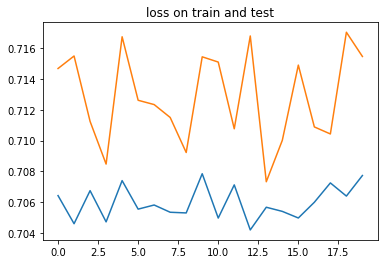

Last loss on train: 0.7077332626929326
Last loss on test: 0.7154718472769386


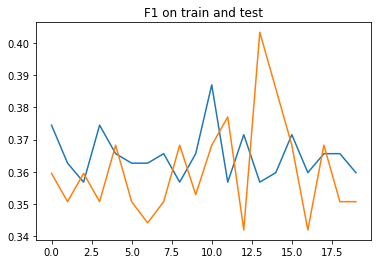

Last F1 on train: 0.35971900688863434
Last F1 on test: 0.3506988185016732


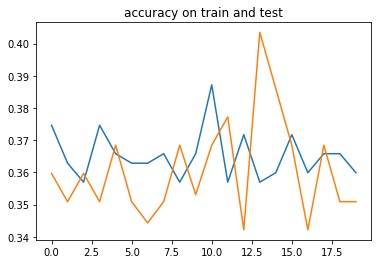

Last accuracy on train: 0.3598820154382064
Last accuracy on test: 0.3508772026551397


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.987440315549097


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

Доля предложений с ДФ среди правильных 0.0
Количество предложений с ДФ среди правильных 0


# Experiment 6, testing embeddings with weights (0.001734, 1, 0.72)

* GRU
* bi
* 2 cells
* 1 layer
* 1 sentence limitation
* 5 tokens limitation
* embeddings

## Training

In [ ]:
model = BiGRU_2Cells_Embs(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, weights=weights, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72]))

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


48it [00:02, 19.23it/s]

Train loss: 0.8528906636767917


92it [00:04, 20.34it/s]

Train loss: 0.8569619284735785


137it [00:06, 20.66it/s]

Train loss: 0.8513608729397809


185it [00:09, 22.53it/s]

Train loss: 0.8585562623209424


226it [00:10, 20.70it/s]


Train loss: 0.850681873427497

Evaluating on train...


50it [00:01, 41.69it/s]

Val loss: 0.8606144534216986, Val f1: 0.34797420899073284, Val accuracy: 0.34814815786149766


95it [00:02, 42.55it/s]

Val loss: 0.8508128040366703, Val f1: 0.3627956625488069, Val accuracy: 0.36296297245555453


140it [00:03, 41.15it/s]

Val loss: 0.8447447419166565, Val f1: 0.35786191070521317, Val accuracy: 0.35802470092420224


180it [00:04, 25.69it/s]

Val loss: 0.8451482312546836, Val f1: 0.35539273536867566, Val accuracy: 0.3555555651585261


226it [00:06, 34.33it/s]


Val loss: 0.8429740481906467, Val f1: 0.3568776067097982, Val accuracy: 0.3570370466179318

Evaluating on test...


20it [00:00, 37.42it/s]

Val loss: 0.8157878081003825, Val f1: 0.37763878107070925, Val accuracy: 0.3777777870496114


36it [00:00, 37.46it/s]

Val loss: 0.8583262821038564, Val f1: 0.35538304249445596, Val accuracy: 0.3555555651585261


52it [00:01, 37.57it/s]

Val loss: 0.8404637363221911, Val f1: 0.3924334188302358, Val accuracy: 0.39259260164366827


64it [00:01, 37.45it/s]

Val loss: 0.8494119008382162, Val f1: 0.3887181729078293, Val accuracy: 0.3888888979951541


76it [00:02, 37.40it/s]


Val loss: 0.8495738879839579, Val f1: 0.38649620532989504, Val accuracy: 0.3866666758060455

starting Epoch 1
Training...


48it [00:02, 23.64it/s]

Train loss: 0.8598496052953932


93it [00:04, 21.33it/s]

Train loss: 0.8411968535847134


136it [00:06, 13.61it/s]

Train loss: 0.8409844694314179


184it [00:08, 21.15it/s]

Train loss: 0.8420813139941957


226it [00:10, 20.55it/s]


Train loss: 0.8450610605875651

Evaluating on train...


52it [00:01, 34.83it/s]

Val loss: 0.8523124893506367, Val f1: 0.3479821291234758, Val accuracy: 0.34814815786149766


93it [00:03, 26.17it/s]

Val loss: 0.8356681393252479, Val f1: 0.34799328645070393, Val accuracy: 0.34814815786149766


138it [00:05, 24.38it/s]

Val loss: 0.8457716186841329, Val f1: 0.35786014088877927, Val accuracy: 0.35802470092420224


184it [00:06, 25.11it/s]

Val loss: 0.8451745222012202, Val f1: 0.3553922782341639, Val accuracy: 0.3555555651585261


226it [00:08, 26.33it/s]


Val loss: 0.8454734664493136, Val f1: 0.3509495545758141, Val accuracy: 0.35111112078030904

Evaluating on test...


18it [00:00, 23.29it/s]

Val loss: 0.8961498022079468, Val f1: 0.33313557306925456, Val accuracy: 0.3333333432674408


33it [00:01, 21.85it/s]

Val loss: 0.8590352475643158, Val f1: 0.33316657443841297, Val accuracy: 0.3333333432674408


47it [00:02, 15.88it/s]

Val loss: 0.8744218998485142, Val f1: 0.3331501007080078, Val accuracy: 0.3333333432674408


64it [00:03, 23.06it/s]

Val loss: 0.8652612815300623, Val f1: 0.34426922500133517, Val accuracy: 0.3444444542129835


76it [00:03, 22.32it/s]


Val loss: 0.8571517713864645, Val f1: 0.35094157814979554, Val accuracy: 0.35111112078030904

starting Epoch 2
Training...


47it [00:02, 19.96it/s]

Train loss: 0.8575919111569722


92it [00:04, 17.13it/s]

Train loss: 0.861439229382409


136it [00:06, 21.28it/s]

Train loss: 0.8492251859770881


181it [00:09, 20.20it/s]

Train loss: 0.8461801562044355


226it [00:11, 20.19it/s]


Train loss: 0.8465874764654372

Evaluating on train...


50it [00:01, 44.20it/s]

Val loss: 0.8828834692637125, Val f1: 0.34795752233929106, Val accuracy: 0.34814815786149766


95it [00:02, 41.62it/s]

Val loss: 0.852052781979243, Val f1: 0.3553863618108961, Val accuracy: 0.3555555651585261


140it [00:03, 40.91it/s]

Val loss: 0.8507904591383757, Val f1: 0.347983079707181, Val accuracy: 0.34814815786149766


185it [00:04, 40.79it/s]

Val loss: 0.8487296793195936, Val f1: 0.35539138366778694, Val accuracy: 0.3555555651585261


226it [00:05, 39.24it/s]


Val loss: 0.8495100106133355, Val f1: 0.356872081624137, Val accuracy: 0.3570370466179318

Evaluating on test...


18it [00:00, 30.46it/s]

Val loss: 0.8210387349128723, Val f1: 0.4220668296019236, Val accuracy: 0.422222230831782


34it [00:01, 22.34it/s]

Val loss: 0.8507181545098622, Val f1: 0.39982797106107076, Val accuracy: 0.4000000089406967


49it [00:02, 21.97it/s]

Val loss: 0.8393788523144192, Val f1: 0.3776148080825806, Val accuracy: 0.3777777870496114


64it [00:02, 24.10it/s]

Val loss: 0.8512286891539892, Val f1: 0.36649580697218576, Val accuracy: 0.3666666761040688


76it [00:03, 23.77it/s]


Val loss: 0.8471356797218322, Val f1: 0.37761103828748066, Val accuracy: 0.3777777870496114

starting Epoch 3
Training...


49it [00:02, 21.02it/s]

Train loss: 0.826781517929501


93it [00:04, 20.54it/s]

Train loss: 0.8371905313597785


137it [00:06, 21.45it/s]

Train loss: 0.8428219353711164


182it [00:08, 21.13it/s]

Train loss: 0.8410196118884616


226it [00:11, 20.28it/s]


Train loss: 0.8389815947744581

Evaluating on train...


49it [00:01, 40.96it/s]

Val loss: 0.8615036553806729, Val f1: 0.34797649913363987, Val accuracy: 0.34814815786149766


94it [00:02, 40.18it/s]

Val loss: 0.8371937473615011, Val f1: 0.36280453834268783, Val accuracy: 0.36296297245555453


139it [00:03, 40.72it/s]

Val loss: 0.8398731297916836, Val f1: 0.367741522303334, Val accuracy: 0.3679012439869068


187it [00:04, 41.70it/s]

Val loss: 0.848916220996115, Val f1: 0.3590943511989382, Val accuracy: 0.35925926880704034


226it [00:05, 40.99it/s]


Val loss: 0.847326996591356, Val f1: 0.36279879649480185, Val accuracy: 0.36296297245555453

Evaluating on test...


22it [00:00, 39.65it/s]

Val loss: 0.8563022017478943, Val f1: 0.33317089080810547, Val accuracy: 0.3333333432674408


35it [00:00, 40.06it/s]

Val loss: 0.842465873559316, Val f1: 0.3776192178328832, Val accuracy: 0.3777777870496114


49it [00:01, 40.51it/s]

Val loss: 0.8532581448554992, Val f1: 0.36279637548658583, Val accuracy: 0.36296297245555453


64it [00:01, 40.25it/s]

Val loss: 0.8497531622648239, Val f1: 0.3776105875770251, Val accuracy: 0.3777777870496114


76it [00:01, 39.58it/s]


Val loss: 0.8612360668182373, Val f1: 0.3687148360411326, Val accuracy: 0.3688888982931773

starting Epoch 4
Training...


48it [00:02, 24.55it/s]

Train loss: 0.8251062856780158


93it [00:03, 24.61it/s]

Train loss: 0.8359183218744066


138it [00:05, 23.57it/s]

Train loss: 0.8394854404308177


183it [00:07, 24.43it/s]

Train loss: 0.8393316904703776


226it [00:09, 24.43it/s]


Train loss: 0.8414616714583503

Evaluating on train...


50it [00:01, 42.33it/s]

Val loss: 0.8658966342608134, Val f1: 0.377591739098231, Val accuracy: 0.3777777870496114


95it [00:02, 42.29it/s]

Val loss: 0.8395077758365207, Val f1: 0.3924286120467716, Val accuracy: 0.39259260164366827


139it [00:03, 39.38it/s]

Val loss: 0.8422575279518411, Val f1: 0.3776154262048227, Val accuracy: 0.3777777870496114


185it [00:04, 39.92it/s]

Val loss: 0.8396186100112067, Val f1: 0.37761696643299525, Val accuracy: 0.3777777870496114


226it [00:05, 40.68it/s]


Val loss: 0.8421474279297723, Val f1: 0.3776144870122274, Val accuracy: 0.3777777870496114

Evaluating on test...


22it [00:00, 36.78it/s]

Val loss: 0.8268392086029053, Val f1: 0.3331927498181661, Val accuracy: 0.3333333432674408


34it [00:00, 37.72it/s]

Val loss: 0.8160325706005096, Val f1: 0.33319876392682396, Val accuracy: 0.3333333432674408


51it [00:01, 39.59it/s]

Val loss: 0.8679918037520514, Val f1: 0.3479641040166219, Val accuracy: 0.34814815786149766


67it [00:01, 38.67it/s]

Val loss: 0.8728680709997813, Val f1: 0.3442606563369433, Val accuracy: 0.3444444542129835


76it [00:01, 38.38it/s]


Val loss: 0.8577818727493286, Val f1: 0.3509393461545308, Val accuracy: 0.35111112078030904

starting Epoch 5
Training...


48it [00:02, 23.38it/s]

Train loss: 0.8553151024712456


93it [00:03, 25.52it/s]

Train loss: 0.8540077282322778


138it [00:05, 24.12it/s]

Train loss: 0.8511543697781033


183it [00:07, 23.10it/s]

Train loss: 0.8448860439989302


226it [00:09, 24.49it/s]


Train loss: 0.8436048441463047

Evaluating on train...


50it [00:01, 43.73it/s]

Val loss: 0.860571202966902, Val f1: 0.3627941442860497, Val accuracy: 0.36296297245555453


95it [00:02, 41.43it/s]

Val loss: 0.8520975980493758, Val f1: 0.3553922752539317, Val accuracy: 0.3555555651585261


135it [00:03, 39.52it/s]

Val loss: 0.8556019513695329, Val f1: 0.3578572184951217, Val accuracy: 0.35802470092420224


184it [00:05, 35.16it/s]

Val loss: 0.8487012181017134, Val f1: 0.3516890158255895, Val accuracy: 0.3518518615100119


226it [00:06, 36.71it/s]


Val loss: 0.8490465373463101, Val f1: 0.34798525214195253, Val accuracy: 0.34814815786149766

Evaluating on test...


20it [00:00, 38.13it/s]

Val loss: 0.8553277929623921, Val f1: 0.33316614627838137, Val accuracy: 0.3333333432674408


36it [00:00, 36.14it/s]

Val loss: 0.8574982861677806, Val f1: 0.3331637352705002, Val accuracy: 0.3333333432674408


52it [00:01, 36.97it/s]

Val loss: 0.8450133641560872, Val f1: 0.3627984960873922, Val accuracy: 0.36296297245555453


64it [00:01, 38.24it/s]

Val loss: 0.8546754012505213, Val f1: 0.3553852453827858, Val accuracy: 0.3555555651585261


76it [00:02, 37.49it/s]


Val loss: 0.8546630088488261, Val f1: 0.3509410579999288, Val accuracy: 0.35111112078030904

starting Epoch 6
Training...


48it [00:01, 25.00it/s]

Train loss: 0.8467794126934476


93it [00:03, 24.79it/s]

Train loss: 0.8470594743887584


138it [00:05, 24.51it/s]

Train loss: 0.840180653112906


183it [00:07, 25.01it/s]

Train loss: 0.8464004122548633


226it [00:09, 24.36it/s]


Train loss: 0.8470451712608338

Evaluating on train...


50it [00:01, 42.45it/s]

Val loss: 0.8350825362735325, Val f1: 0.3479926698737674, Val accuracy: 0.34814815786149766


95it [00:02, 42.65it/s]

Val loss: 0.8445448921786414, Val f1: 0.34798441761069826, Val accuracy: 0.34814815786149766


140it [00:03, 41.70it/s]

Val loss: 0.8460961368348864, Val f1: 0.35292055430235686, Val accuracy: 0.35308642939284995


184it [00:04, 40.22it/s]

Val loss: 0.8502376970317629, Val f1: 0.35168393121825325, Val accuracy: 0.3518518615100119


226it [00:05, 41.10it/s]


Val loss: 0.8464595087369283, Val f1: 0.3627980564700233, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 37.59it/s]

Val loss: 0.8661763230959575, Val f1: 0.37760218580563865, Val accuracy: 0.3777777870496114


38it [00:00, 39.34it/s]

Val loss: 0.8516678035259246, Val f1: 0.3776064227024714, Val accuracy: 0.3777777870496114


50it [00:01, 39.15it/s]

Val loss: 0.8522177828682793, Val f1: 0.3924177428086599, Val accuracy: 0.39259260164366827


66it [00:01, 38.73it/s]

Val loss: 0.8525544891754786, Val f1: 0.37760627418756487, Val accuracy: 0.3777777870496114


76it [00:01, 38.40it/s]


Val loss: 0.8494121932983398, Val f1: 0.3687208342552185, Val accuracy: 0.3688888982931773

starting Epoch 7
Training...


48it [00:01, 25.85it/s]

Train loss: 0.8760719683435229


94it [00:03, 25.29it/s]

Train loss: 0.8611063473754459


139it [00:05, 24.26it/s]

Train loss: 0.848200218765824


184it [00:07, 23.81it/s]

Train loss: 0.8488098929325739


226it [00:09, 24.50it/s]


Train loss: 0.8454643011093139

Evaluating on train...


50it [00:01, 43.35it/s]

Val loss: 0.8424343797895644, Val f1: 0.3628048512670729, Val accuracy: 0.36296297245555453


95it [00:02, 41.73it/s]

Val loss: 0.8509115603235032, Val f1: 0.35539061062865784, Val accuracy: 0.3555555651585261


140it [00:03, 40.28it/s]

Val loss: 0.8549426317214965, Val f1: 0.3479825055157697, Val accuracy: 0.34814815786149766


185it [00:04, 37.93it/s]

Val loss: 0.8469996988773346, Val f1: 0.3479872797926267, Val accuracy: 0.34814815786149766


226it [00:05, 40.63it/s]


Val loss: 0.8462223365571764, Val f1: 0.3539126151137882, Val accuracy: 0.3540740836991204

Evaluating on test...


21it [00:00, 38.52it/s]

Val loss: 0.8713806668917338, Val f1: 0.3331533153851827, Val accuracy: 0.3333333432674408


34it [00:00, 38.63it/s]

Val loss: 0.8398703396320343, Val f1: 0.39983773132165273, Val accuracy: 0.4000000089406967


51it [00:01, 39.13it/s]

Val loss: 0.8436222434043884, Val f1: 0.3924300260014004, Val accuracy: 0.39259260164366827


68it [00:01, 39.25it/s]

Val loss: 0.8481255133946737, Val f1: 0.4109427511692047, Val accuracy: 0.4111111198862394


76it [00:01, 38.70it/s]


Val loss: 0.8504449558258057, Val f1: 0.40427653948465986, Val accuracy: 0.40444445331891377

starting Epoch 8
Training...


48it [00:01, 25.25it/s]

Train loss: 0.8513191925154792


93it [00:03, 22.72it/s]

Train loss: 0.8564655807283189


138it [00:05, 24.38it/s]

Train loss: 0.8525376209506282


183it [00:07, 23.04it/s]

Train loss: 0.8426876091294818


226it [00:09, 24.47it/s]


Train loss: 0.8418010229534573

Evaluating on train...


50it [00:01, 41.78it/s]

Val loss: 0.8399529258410136, Val f1: 0.37762036787139047, Val accuracy: 0.3777777870496114


95it [00:02, 41.53it/s]

Val loss: 0.8541317145029704, Val f1: 0.3553893188635508, Val accuracy: 0.3555555651585261


140it [00:03, 40.67it/s]

Val loss: 0.8532366810021577, Val f1: 0.36279454120883237, Val accuracy: 0.36296297245555453


187it [00:04, 38.13it/s]

Val loss: 0.8509134236309264, Val f1: 0.3627960241503186, Val accuracy: 0.36296297245555453


226it [00:05, 40.44it/s]


Val loss: 0.841073919667138, Val f1: 0.3716892699400584, Val accuracy: 0.37185186121198865

Evaluating on test...


22it [00:00, 39.82it/s]

Val loss: 0.8183178146680196, Val f1: 0.42207579215367635, Val accuracy: 0.422222230831782


37it [00:00, 39.18it/s]

Val loss: 0.8441679835319519, Val f1: 0.3776172250509262, Val accuracy: 0.3777777870496114


50it [00:01, 39.17it/s]

Val loss: 0.8507196505864462, Val f1: 0.3627983291943868, Val accuracy: 0.36296297245555453


66it [00:01, 38.01it/s]

Val loss: 0.8570124387741089, Val f1: 0.35538258602221806, Val accuracy: 0.3555555651585261


76it [00:01, 39.09it/s]


Val loss: 0.8568421308199564, Val f1: 0.35093979159990946, Val accuracy: 0.35111112078030904

starting Epoch 9
Training...


48it [00:01, 24.85it/s]

Train loss: 0.8590044498443603


93it [00:03, 24.99it/s]

Train loss: 0.8610813630951776


138it [00:05, 24.52it/s]

Train loss: 0.8578163592903703


183it [00:07, 24.54it/s]

Train loss: 0.8518720285760032


226it [00:09, 24.34it/s]


Train loss: 0.8416958543989393

Evaluating on train...


50it [00:01, 43.02it/s]

Val loss: 0.8400944656795926, Val f1: 0.36279781262079874, Val accuracy: 0.36296297245555453


95it [00:02, 41.60it/s]

Val loss: 0.8418783538871342, Val f1: 0.35539275805155435, Val accuracy: 0.3555555651585261


140it [00:03, 40.42it/s]

Val loss: 0.8489885144763523, Val f1: 0.3578588759457624, Val accuracy: 0.35802470092420224


186it [00:04, 35.75it/s]

Val loss: 0.8527574628591538, Val f1: 0.3590917918417189, Val accuracy: 0.35925926880704034


226it [00:05, 37.77it/s]


Val loss: 0.8462380430433485, Val f1: 0.36576194802920026, Val accuracy: 0.3659259353743659

Evaluating on test...


20it [00:00, 38.86it/s]

Val loss: 0.8650395154953003, Val f1: 0.3331639309724172, Val accuracy: 0.3333333432674408


37it [00:00, 38.20it/s]

Val loss: 0.8577201863129934, Val f1: 0.35538469851016996, Val accuracy: 0.3555555651585261


50it [00:01, 38.83it/s]

Val loss: 0.851139693790012, Val f1: 0.36279818879233466, Val accuracy: 0.36296297245555453


66it [00:01, 36.83it/s]

Val loss: 0.855873120824496, Val f1: 0.35538770953814186, Val accuracy: 0.3555555651585261


76it [00:01, 38.08it/s]


Val loss: 0.8634959204991659, Val f1: 0.35982359925905866, Val accuracy: 0.36000000953674316

starting Epoch 10
Training...


49it [00:02, 24.61it/s]

Train loss: 0.8377353257603115


94it [00:03, 26.04it/s]

Train loss: 0.8431574271784888


139it [00:05, 21.67it/s]

Train loss: 0.8374541353296351


184it [00:07, 24.73it/s]

Train loss: 0.8397382497787476


226it [00:09, 24.27it/s]


Train loss: 0.8453012084960938

Evaluating on train...


49it [00:01, 42.74it/s]

Val loss: 0.830677882830302, Val f1: 0.37762966619597543, Val accuracy: 0.3777777870496114


94it [00:02, 42.93it/s]

Val loss: 0.8329603122340308, Val f1: 0.377625286910269, Val accuracy: 0.3777777870496114


139it [00:03, 40.22it/s]

Val loss: 0.8279862434775741, Val f1: 0.3825667694762901, Val accuracy: 0.3827160585809637


184it [00:04, 40.99it/s]

Val loss: 0.8403449200921589, Val f1: 0.38872639487187066, Val accuracy: 0.3888888979951541


226it [00:05, 41.35it/s]


Val loss: 0.8442649507522583, Val f1: 0.377613574663798, Val accuracy: 0.3777777870496114

Evaluating on test...


20it [00:00, 39.10it/s]

Val loss: 0.8660483439763387, Val f1: 0.3331622620423635, Val accuracy: 0.3333333432674408


36it [00:00, 38.50it/s]

Val loss: 0.8548697094122569, Val f1: 0.33317276537418367, Val accuracy: 0.3333333432674408


52it [00:01, 38.62it/s]

Val loss: 0.8519396305084228, Val f1: 0.3331736101044549, Val accuracy: 0.3333333432674408


64it [00:01, 38.75it/s]

Val loss: 0.8500302910804749, Val f1: 0.344283834596475, Val accuracy: 0.3444444542129835


76it [00:01, 39.11it/s]


Val loss: 0.8616829117139181, Val f1: 0.34205029567082723, Val accuracy: 0.3422222320238749

starting Epoch 11
Training...


48it [00:01, 24.83it/s]

Train loss: 0.837628087732527


93it [00:03, 24.03it/s]

Train loss: 0.8382212413681878


138it [00:05, 25.83it/s]

Train loss: 0.8401004058343393


183it [00:07, 25.56it/s]

Train loss: 0.8427979658047359


226it [00:09, 24.47it/s]


Train loss: 0.845247282187144

Evaluating on train...


49it [00:01, 42.40it/s]

Val loss: 0.8237153940730625, Val f1: 0.348003097375234, Val accuracy: 0.34814815786149766


94it [00:02, 40.56it/s]

Val loss: 0.8376303109857771, Val f1: 0.3554002162483003, Val accuracy: 0.3555555651585261


141it [00:03, 38.15it/s]

Val loss: 0.8480779219556738, Val f1: 0.35415861143006216, Val accuracy: 0.35432099722049853


186it [00:04, 38.74it/s]

Val loss: 0.850394308898184, Val f1: 0.3600193661120203, Val accuracy: 0.36018519467777677


226it [00:05, 39.83it/s]


Val loss: 0.8477366876602173, Val f1: 0.360577990743849, Val accuracy: 0.3607407502333323

Evaluating on test...


21it [00:00, 38.89it/s]

Val loss: 0.8528945485750834, Val f1: 0.4220322032769521, Val accuracy: 0.422222230831782


37it [00:00, 38.03it/s]

Val loss: 0.8498895466327667, Val f1: 0.39982401629288994, Val accuracy: 0.4000000089406967


50it [00:01, 39.04it/s]

Val loss: 0.8476430866453383, Val f1: 0.37760666542583043, Val accuracy: 0.3777777870496114


66it [00:01, 37.92it/s]

Val loss: 0.8468875110149383, Val f1: 0.3887191573778788, Val accuracy: 0.3888888979951541


76it [00:01, 38.86it/s]


Val loss: 0.8558461753527323, Val f1: 0.3864921569824219, Val accuracy: 0.3866666758060455

starting Epoch 12
Training...


48it [00:02, 24.32it/s]

Train loss: 0.8346107072300382


93it [00:03, 25.30it/s]

Train loss: 0.8360333495669895


139it [00:05, 24.69it/s]

Train loss: 0.8567382507854038


184it [00:07, 24.89it/s]

Train loss: 0.8541355497307248


226it [00:09, 24.25it/s]


Train loss: 0.8442515238126119

Evaluating on train...


49it [00:01, 43.14it/s]

Val loss: 0.8458021309640672, Val f1: 0.3776137590408325, Val accuracy: 0.3777777870496114


94it [00:02, 42.77it/s]

Val loss: 0.8482316858238644, Val f1: 0.370206751426061, Val accuracy: 0.37037037975258297


142it [00:03, 38.05it/s]

Val loss: 0.8490759624375237, Val f1: 0.372674725011543, Val accuracy: 0.3728395155182591


184it [00:04, 39.58it/s]

Val loss: 0.8460309078296026, Val f1: 0.36650552170144185, Val accuracy: 0.3666666761040688


226it [00:05, 40.77it/s]


Val loss: 0.8443221497535706, Val f1: 0.3716911643081241, Val accuracy: 0.37185186121198865

Evaluating on test...


20it [00:00, 38.30it/s]

Val loss: 0.8777724822362264, Val f1: 0.3331509431203206, Val accuracy: 0.3333333432674408


37it [00:00, 38.04it/s]

Val loss: 0.8690649231274923, Val f1: 0.37759372194608054, Val accuracy: 0.3777777870496114


49it [00:01, 37.75it/s]

Val loss: 0.8500892043113708, Val f1: 0.37760932313071355, Val accuracy: 0.3777777870496114


66it [00:01, 38.21it/s]

Val loss: 0.8515753875176112, Val f1: 0.3776106576124827, Val accuracy: 0.3777777870496114


76it [00:01, 38.17it/s]


Val loss: 0.8459339213371276, Val f1: 0.39538925131162006, Val accuracy: 0.39555556456247964

starting Epoch 13
Training...


48it [00:02, 22.53it/s]

Train loss: 0.8602060755093892


93it [00:03, 24.34it/s]

Train loss: 0.8434715178277757


138it [00:05, 25.19it/s]

Train loss: 0.8489858887813709


183it [00:07, 24.81it/s]

Train loss: 0.8514431350760989


226it [00:09, 24.58it/s]


Train loss: 0.8494721637831794

Evaluating on train...


50it [00:01, 41.66it/s]

Val loss: 0.845888286166721, Val f1: 0.33317829569180807, Val accuracy: 0.3333333432674408


95it [00:02, 41.44it/s]

Val loss: 0.852916763888465, Val f1: 0.3331701374716229, Val accuracy: 0.3333333432674408


140it [00:03, 40.15it/s]

Val loss: 0.8505055100829513, Val f1: 0.3479861866544794, Val accuracy: 0.34814815786149766


184it [00:04, 40.48it/s]

Val loss: 0.8480719142489963, Val f1: 0.35539318472146986, Val accuracy: 0.3555555651585261


226it [00:05, 40.77it/s]


Val loss: 0.8453255189789666, Val f1: 0.3539138827059004, Val accuracy: 0.3540740836991204

Evaluating on test...


20it [00:00, 34.51it/s]

Val loss: 0.8960756818453471, Val f1: 0.33313498298327127, Val accuracy: 0.3333333432674408


36it [00:00, 37.56it/s]

Val loss: 0.8789419114589692, Val f1: 0.35537048478921257, Val accuracy: 0.3555555651585261


48it [00:01, 37.60it/s]

Val loss: 0.845551523897383, Val f1: 0.3628007319238451, Val accuracy: 0.36296297245555453


65it [00:01, 38.08it/s]

Val loss: 0.8465769708156585, Val f1: 0.3776129364967346, Val accuracy: 0.3777777870496114


76it [00:02, 37.54it/s]


Val loss: 0.8548647952079773, Val f1: 0.3776068631807963, Val accuracy: 0.3777777870496114

starting Epoch 14
Training...


50it [00:02, 25.76it/s]

Train loss: 0.8240116278330485


92it [00:03, 21.99it/s]

Train loss: 0.8501482049624125


140it [00:05, 25.60it/s]

Train loss: 0.8561373498704699


182it [00:07, 24.36it/s]

Train loss: 0.8486425810390048


226it [00:09, 24.43it/s]


Train loss: 0.8482897406154208

Evaluating on train...


50it [00:01, 42.15it/s]

Val loss: 0.8358092016643948, Val f1: 0.36280670430925155, Val accuracy: 0.36296297245555453


95it [00:02, 40.37it/s]

Val loss: 0.8387116140789456, Val f1: 0.36280409097671507, Val accuracy: 0.36296297245555453


140it [00:03, 41.00it/s]

Val loss: 0.834036746289995, Val f1: 0.36280938585599265, Val accuracy: 0.36296297245555453


185it [00:04, 40.43it/s]

Val loss: 0.8417147560252084, Val f1: 0.35539606346024405, Val accuracy: 0.3555555651585261


226it [00:05, 41.10it/s]


Val loss: 0.8442379652129279, Val f1: 0.35687621156374616, Val accuracy: 0.3570370466179318

Evaluating on test...


19it [00:00, 40.05it/s]

Val loss: 0.8536130825678507, Val f1: 0.333166366815567, Val accuracy: 0.3333333432674408


34it [00:00, 40.18it/s]

Val loss: 0.8820189873377482, Val f1: 0.3553559293349584, Val accuracy: 0.3555555651585261


49it [00:01, 39.39it/s]

Val loss: 0.8664498183462355, Val f1: 0.3627782742182414, Val accuracy: 0.36296297245555453


66it [00:01, 39.60it/s]

Val loss: 0.8530281414588292, Val f1: 0.3553849334518115, Val accuracy: 0.3555555651585261


76it [00:01, 39.75it/s]


Val loss: 0.8487828699747721, Val f1: 0.36872046868006386, Val accuracy: 0.3688888982931773

starting Epoch 15
Training...


49it [00:02, 26.38it/s]

Train loss: 0.8320381959279378


94it [00:03, 24.22it/s]

Train loss: 0.8428432100349003


139it [00:06, 15.63it/s]

Train loss: 0.8400049836547286


184it [00:08, 24.51it/s]

Train loss: 0.8442205392652088


226it [00:09, 23.34it/s]


Train loss: 0.8444921146498786

Evaluating on train...


50it [00:01, 42.82it/s]

Val loss: 0.8588283485836453, Val f1: 0.36279181043306985, Val accuracy: 0.36296297245555453


95it [00:02, 42.10it/s]

Val loss: 0.8300903995831808, Val f1: 0.3628150403499603, Val accuracy: 0.36296297245555453


142it [00:03, 39.19it/s]

Val loss: 0.8334027118153042, Val f1: 0.35293678994531985, Val accuracy: 0.35308642939284995


187it [00:04, 39.55it/s]

Val loss: 0.8385688698954052, Val f1: 0.3516980230808258, Val accuracy: 0.3518518615100119


226it [00:05, 40.18it/s]


Val loss: 0.841780030462477, Val f1: 0.3539159647623698, Val accuracy: 0.3540740836991204

Evaluating on test...


20it [00:00, 37.74it/s]

Val loss: 0.8419639746348063, Val f1: 0.37761349280675255, Val accuracy: 0.3777777870496114


33it [00:00, 38.93it/s]

Val loss: 0.8439713795979817, Val f1: 0.42205023964246113, Val accuracy: 0.422222230831782


51it [00:01, 39.59it/s]

Val loss: 0.8507965551482306, Val f1: 0.42204728921254475, Val accuracy: 0.422222230831782


65it [00:01, 40.11it/s]

Val loss: 0.8450610379378001, Val f1: 0.42204833527406055, Val accuracy: 0.422222230831782


76it [00:01, 39.11it/s]


Val loss: 0.8479135076204936, Val f1: 0.40427143772443136, Val accuracy: 0.40444445331891377

starting Epoch 16
Training...


48it [00:02, 23.85it/s]

Train loss: 0.8029658397038778


93it [00:04, 23.73it/s]

Train loss: 0.8196484751171536


138it [00:06, 23.82it/s]

Train loss: 0.82477611568239


183it [00:07, 26.02it/s]

Train loss: 0.8339184049102996


226it [00:09, 23.58it/s]


Train loss: 0.8433544797367519

Evaluating on train...


50it [00:01, 42.97it/s]

Val loss: 0.860967132780287, Val f1: 0.36649256414837306, Val accuracy: 0.3666666759385003


95it [00:02, 41.74it/s]

Val loss: 0.8583867384327782, Val f1: 0.3572351945771111, Val accuracy: 0.357407416899999


140it [00:03, 39.35it/s]

Val loss: 0.8538507333508244, Val f1: 0.35909031629562377, Val accuracy: 0.3592592687518508


186it [00:04, 38.45it/s]

Val loss: 0.8533334215482076, Val f1: 0.3563133200009664, Val accuracy: 0.3564814910292625


226it [00:05, 41.12it/s]


Val loss: 0.8446029143863254, Val f1: 0.36650455090734696, Val accuracy: 0.36666667607095504

Evaluating on test...


19it [00:00, 39.30it/s]

Val loss: 0.8504984140396118, Val f1: 0.33316482504208883, Val accuracy: 0.3333333432674408


34it [00:00, 39.49it/s]

Val loss: 0.8733659366766612, Val f1: 0.3331542521715164, Val accuracy: 0.3333333432674408


51it [00:01, 39.20it/s]

Val loss: 0.8430826160642836, Val f1: 0.33317532936731975, Val accuracy: 0.3333333432674408


64it [00:01, 38.51it/s]

Val loss: 0.8638497948646545, Val f1: 0.33316109925508497, Val accuracy: 0.3333333432674408


76it [00:01, 39.22it/s]


Val loss: 0.8588197588920593, Val f1: 0.35093981385231016, Val accuracy: 0.35111112078030904

starting Epoch 17
Training...


49it [00:02, 24.72it/s]

Train loss: 0.8203646659851074


94it [00:03, 26.53it/s]

Train loss: 0.8414592451519436


139it [00:05, 23.93it/s]

Train loss: 0.8525604340765212


181it [00:07, 24.74it/s]

Train loss: 0.8394710974560844


226it [00:09, 24.31it/s]


Train loss: 0.8449800078074138

Evaluating on train...


49it [00:01, 42.65it/s]

Val loss: 0.8465885612699721, Val f1: 0.3331709086894989, Val accuracy: 0.3333333432674408


94it [00:02, 42.55it/s]

Val loss: 0.8590546740425957, Val f1: 0.34056837260723116, Val accuracy: 0.34074075056446923


139it [00:03, 40.25it/s]

Val loss: 0.8493666684186018, Val f1: 0.3529217344743234, Val accuracy: 0.35308642939284995


188it [00:04, 39.97it/s]

Val loss: 0.8523502737283707, Val f1: 0.3479820493194792, Val accuracy: 0.34814815786149766


226it [00:05, 40.32it/s]


Val loss: 0.8461229062080383, Val f1: 0.3479859467347463, Val accuracy: 0.34814815786149766

Evaluating on test...


20it [00:00, 37.91it/s]

Val loss: 0.8476142923037211, Val f1: 0.3331764419873556, Val accuracy: 0.3333333432674408


36it [00:00, 37.98it/s]

Val loss: 0.8528417448202769, Val f1: 0.333170344432195, Val accuracy: 0.3333333432674408


52it [00:01, 38.63it/s]

Val loss: 0.8639139228396946, Val f1: 0.3479754991001553, Val accuracy: 0.34814815786149766


65it [00:01, 39.30it/s]

Val loss: 0.8443407922983169, Val f1: 0.35539615402619046, Val accuracy: 0.3555555651585261


76it [00:01, 38.13it/s]


Val loss: 0.8519158657391867, Val f1: 0.35983203450838724, Val accuracy: 0.36000000953674316

starting Epoch 18
Training...


50it [00:02, 24.76it/s]

Train loss: 0.8485991954803467


95it [00:03, 24.86it/s]

Train loss: 0.8678664644559224


140it [00:05, 24.25it/s]

Train loss: 0.8566622469160292


185it [00:07, 24.31it/s]

Train loss: 0.8500251144170761


226it [00:09, 24.27it/s]


Train loss: 0.8461394646432665

Evaluating on train...


50it [00:01, 43.04it/s]

Val loss: 0.8837904532750448, Val f1: 0.3331465456220839, Val accuracy: 0.3333333432674408


95it [00:02, 42.24it/s]

Val loss: 0.8639098644256592, Val f1: 0.35538019471698334, Val accuracy: 0.3555555651585261


139it [00:03, 40.36it/s]

Val loss: 0.8493571029769049, Val f1: 0.35785856975449454, Val accuracy: 0.35802470092420224


185it [00:04, 39.84it/s]

Val loss: 0.8513240026103126, Val f1: 0.3553884095615811, Val accuracy: 0.3555555651585261


226it [00:05, 40.36it/s]


Val loss: 0.8465952073203192, Val f1: 0.35687333636813695, Val accuracy: 0.3570370466179318

Evaluating on test...


21it [00:00, 39.81it/s]

Val loss: 0.8956530253092448, Val f1: 0.3331339677174886, Val accuracy: 0.3333333432674408


34it [00:00, 38.88it/s]

Val loss: 0.8966863950093588, Val f1: 0.3331302801767985, Val accuracy: 0.3333333432674408


50it [00:01, 37.44it/s]

Val loss: 0.8796661165025499, Val f1: 0.33314433826340567, Val accuracy: 0.3333333432674408


66it [00:01, 38.17it/s]

Val loss: 0.8753128548463186, Val f1: 0.33315176218748094, Val accuracy: 0.3333333432674408


76it [00:01, 38.46it/s]


Val loss: 0.8575089391072591, Val f1: 0.34205270767211915, Val accuracy: 0.3422222320238749

starting Epoch 19
Training...


48it [00:01, 25.74it/s]

Train loss: 0.8534487340185377


93it [00:03, 25.21it/s]

Train loss: 0.8516766508420308


138it [00:05, 24.06it/s]

Train loss: 0.8497297905109547


183it [00:07, 24.03it/s]

Train loss: 0.8398055348131391


226it [00:09, 24.09it/s]


Train loss: 0.8448014238145616

Evaluating on train...


49it [00:01, 43.28it/s]

Val loss: 0.8376219405068291, Val f1: 0.3924345877435472, Val accuracy: 0.39259260164366827


94it [00:02, 40.72it/s]

Val loss: 0.834652386771308, Val f1: 0.3702182216776742, Val accuracy: 0.37037037975258297


142it [00:03, 38.36it/s]

Val loss: 0.8390442574465716, Val f1: 0.37762038994718483, Val accuracy: 0.3777777870496114


185it [00:04, 38.44it/s]

Val loss: 0.8428378492593765, Val f1: 0.3702102129658063, Val accuracy: 0.37037037975258297


226it [00:05, 40.31it/s]


Val loss: 0.8441554556952583, Val f1: 0.3657653628455268, Val accuracy: 0.3659259353743659

Evaluating on test...


19it [00:00, 40.64it/s]

Val loss: 0.8433340549468994, Val f1: 0.3331673304239909, Val accuracy: 0.3333333432674408


37it [00:00, 38.97it/s]

Val loss: 0.8517672558625539, Val f1: 0.3553801288207372, Val accuracy: 0.3555555651585261


49it [00:01, 37.17it/s]

Val loss: 0.8483123977979025, Val f1: 0.34798067609469097, Val accuracy: 0.34814815786149766


66it [00:01, 37.71it/s]

Val loss: 0.8465910722812017, Val f1: 0.344279778500398, Val accuracy: 0.3444444542129835


76it [00:01, 38.58it/s]

Val loss: 0.8536383930842082, Val f1: 0.34205292145411176, Val accuracy: 0.3422222320238749


## Graphics

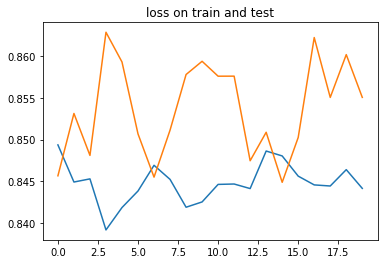

Last loss on train: 0.8441407983809446
Last loss on test: 0.8550600284024289


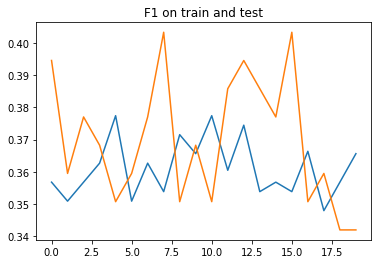

Last F1 on train: 0.36562100158328503
Last F1 on test: 0.34193511660161774


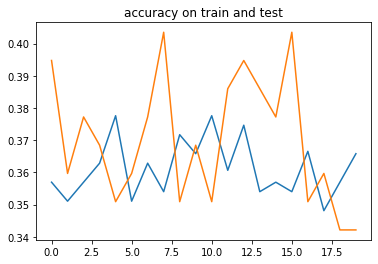

Last accuracy on train: 0.36578172036504325
Last accuracy on test: 0.3421052729612903


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.987440315549097


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

Доля предложений с ДФ среди правильных 0.0
Количество предложений с ДФ среди правильных 0


# Experiment 7, testing weights (0.001734, 1, 0.72)

* GRU
* bi
* 2 cells
* 1 layer
* 1 sentence limitation
* 5 tokens limitation

## Training

In [12]:
model = BiGRU_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [13]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


50it [00:02, 26.28it/s]

Train loss: 0.7044294661945767


95it [00:03, 24.87it/s]

Train loss: 0.6726784553792742


140it [00:05, 27.04it/s]

Train loss: 0.653336872877898


185it [00:07, 27.19it/s]

Train loss: 0.6408078504933251


226it [00:08, 25.16it/s]


Train loss: 0.6321171169810825

Evaluating on train...


53it [00:01, 40.83it/s]

Val loss: 0.5921106457710266, Val f1: 0.36340606742435033, Val accuracy: 0.9387423078219096


93it [00:02, 41.60it/s]

Val loss: 0.5880047420660655, Val f1: 0.3642914007107417, Val accuracy: 0.9480574816465378


143it [00:03, 42.34it/s]

Val loss: 0.5858370034782975, Val f1: 0.3629867995226825, Val accuracy: 0.9473228611327984


183it [00:04, 38.96it/s]

Val loss: 0.5866606828239229, Val f1: 0.3627333611249924, Val accuracy: 0.9466183524992731


226it [00:05, 41.08it/s]


Val loss: 0.5882303688261245, Val f1: 0.3629009913073646, Val accuracy: 0.9393003306123946

Evaluating on test...


19it [00:00, 39.65it/s]

Val loss: 0.609242872397105, Val f1: 0.3642111301422119, Val accuracy: 0.9321060379346212


34it [00:00, 40.38it/s]

Val loss: 0.6010068416595459, Val f1: 0.3585255891084671, Val accuracy: 0.9228791197141012


52it [00:01, 39.03it/s]

Val loss: 0.6000276737742953, Val f1: 0.3597736808988783, Val accuracy: 0.9247653947936164


64it [00:01, 38.85it/s]

Val loss: 0.5951108733812968, Val f1: 0.3622326989968618, Val accuracy: 0.9384630372126898


76it [00:01, 39.62it/s]


Val loss: 0.5992627652486165, Val f1: 0.3610347839196523, Val accuracy: 0.9360445300738017

starting Epoch 1
Training...


48it [00:02, 23.15it/s]

Train loss: 0.5863524701860215


93it [00:03, 23.55it/s]

Train loss: 0.5800247934129503


138it [00:05, 26.37it/s]

Train loss: 0.5809313473878084


183it [00:07, 26.24it/s]

Train loss: 0.5805774440368017


226it [00:08, 25.26it/s]


Train loss: 0.5780756666925219

Evaluating on train...


49it [00:01, 43.36it/s]

Val loss: 0.5612250235345628, Val f1: 0.4238154047065311, Val accuracy: 0.9772825135125054


94it [00:02, 40.61it/s]

Val loss: 0.5641931070221795, Val f1: 0.4258771856625875, Val accuracy: 0.9559284779760573


138it [00:03, 25.41it/s]

Val loss: 0.5646122133290327, Val f1: 0.42452765570746526, Val accuracy: 0.9607290674138952


186it [00:05, 34.34it/s]

Val loss: 0.5652794943915473, Val f1: 0.42684778852595223, Val accuracy: 0.9554469701316621


226it [00:06, 34.94it/s]


Val loss: 0.564361806180742, Val f1: 0.42796495450867544, Val accuracy: 0.9543662093745338

Evaluating on test...


23it [00:00, 39.61it/s]

Val loss: 0.5857634544372559, Val f1: 0.4053068737188975, Val accuracy: 0.9000491460164388


35it [00:00, 38.58it/s]

Val loss: 0.57830078403155, Val f1: 0.41536464989185334, Val accuracy: 0.9380964855353038


52it [00:01, 38.88it/s]

Val loss: 0.5782326287693448, Val f1: 0.4174569288889567, Val accuracy: 0.9489503502845764


64it [00:01, 38.37it/s]

Val loss: 0.577242378393809, Val f1: 0.4147922267516454, Val accuracy: 0.9444231753547986


76it [00:01, 38.75it/s]


Val loss: 0.5790079736709595, Val f1: 0.41336658438046775, Val accuracy: 0.9447608172893525

starting Epoch 2
Training...


48it [00:02, 23.96it/s]

Train loss: 0.5694547096888224


93it [00:03, 25.53it/s]

Train loss: 0.5665319793754153


138it [00:05, 27.04it/s]

Train loss: 0.5674710437103554


183it [00:07, 25.87it/s]

Train loss: 0.5669513463973999


226it [00:09, 25.02it/s]


Train loss: 0.5666803206337823

Evaluating on train...


50it [00:01, 42.64it/s]

Val loss: 0.5653033441967434, Val f1: 0.4068006204234229, Val accuracy: 0.9761195056968265


95it [00:02, 42.26it/s]

Val loss: 0.567622740401162, Val f1: 0.4023328380452262, Val accuracy: 0.9696044892072677


140it [00:03, 40.65it/s]

Val loss: 0.5673493270520811, Val f1: 0.40241161386171975, Val accuracy: 0.9713599458888725


185it [00:04, 39.86it/s]

Val loss: 0.5674031760957506, Val f1: 0.4017637506127357, Val accuracy: 0.9707990985777643


226it [00:05, 40.63it/s]


Val loss: 0.5671688318252563, Val f1: 0.40078119291199577, Val accuracy: 0.962888576719496

Evaluating on test...


22it [00:00, 39.34it/s]

Val loss: 0.5784456690152486, Val f1: 0.3792123337586721, Val accuracy: 0.8886856436729431


34it [00:00, 39.12it/s]

Val loss: 0.582301531235377, Val f1: 0.38415097296237943, Val accuracy: 0.8961240241924922


51it [00:01, 39.23it/s]

Val loss: 0.57750846279992, Val f1: 0.3898308833440145, Val accuracy: 0.9115825527244144


67it [00:01, 37.53it/s]

Val loss: 0.576901709040006, Val f1: 0.39115208784739175, Val accuracy: 0.9267687395215034


76it [00:01, 38.45it/s]


Val loss: 0.5776687987645467, Val f1: 0.3903355542818705, Val accuracy: 0.9157454351584117

starting Epoch 3
Training...


48it [00:01, 25.22it/s]

Train loss: 0.5638951381047567


93it [00:03, 26.07it/s]

Train loss: 0.5658126082685259


135it [00:05, 25.19it/s]

Train loss: 0.5640886717372471


183it [00:07, 25.70it/s]

Train loss: 0.5649110519223743


226it [00:09, 24.76it/s]


Train loss: 0.5651043889257643

Evaluating on train...


50it [00:01, 40.11it/s]

Val loss: 0.5678916401333279, Val f1: 0.48237595293256974, Val accuracy: 0.9741746836238437


95it [00:02, 41.44it/s]

Val loss: 0.5661234279473623, Val f1: 0.4770955284436544, Val accuracy: 0.9635939810011122


140it [00:03, 40.42it/s]

Val loss: 0.5656983119470101, Val f1: 0.482232345033575, Val accuracy: 0.9624528310917042


184it [00:04, 40.55it/s]

Val loss: 0.564907471007771, Val f1: 0.4842761551340421, Val accuracy: 0.9682926919725207


226it [00:05, 40.62it/s]


Val loss: 0.5654011975394355, Val f1: 0.48144133965174357, Val accuracy: 0.9611558277077145

Evaluating on test...


22it [00:00, 39.77it/s]

Val loss: 0.5753045280774435, Val f1: 0.44065603812535603, Val accuracy: 0.9441025137901307


37it [00:00, 41.08it/s]

Val loss: 0.578841358423233, Val f1: 0.440899990995725, Val accuracy: 0.9297543317079544


51it [00:01, 39.20it/s]

Val loss: 0.5822398781776428, Val f1: 0.439957281615999, Val accuracy: 0.9351270616054534


68it [00:01, 39.62it/s]

Val loss: 0.5837515483299891, Val f1: 0.43933897217114765, Val accuracy: 0.9219100341200829


76it [00:01, 39.87it/s]


Val loss: 0.5877196582158407, Val f1: 0.4423511056105296, Val accuracy: 0.9171841569741567

starting Epoch 4
Training...


48it [00:02, 25.75it/s]

Train loss: 0.5696299499935574


93it [00:03, 25.39it/s]

Train loss: 0.5667979213926527


138it [00:05, 24.99it/s]

Train loss: 0.565523835906276


183it [00:07, 23.97it/s]

Train loss: 0.5652577224704954


226it [00:09, 23.75it/s]


Train loss: 0.5653049476941426

Evaluating on train...


49it [00:01, 40.51it/s]

Val loss: 0.5582376639048259, Val f1: 0.537802047861947, Val accuracy: 0.945733646551768


94it [00:02, 39.98it/s]

Val loss: 0.5587564746538798, Val f1: 0.5589855555031035, Val accuracy: 0.9675323241286807


142it [00:03, 38.86it/s]

Val loss: 0.5601677872516491, Val f1: 0.5542512628767226, Val accuracy: 0.9715616235026607


187it [00:04, 37.38it/s]

Val loss: 0.560951605770323, Val f1: 0.555270884765519, Val accuracy: 0.9686595069037544


226it [00:05, 39.38it/s]


Val loss: 0.5600251862737867, Val f1: 0.5545634354485406, Val accuracy: 0.9710134124755859

Evaluating on test...


20it [00:00, 37.21it/s]

Val loss: 0.5787081321080526, Val f1: 0.49547701080640155, Val accuracy: 0.9572198470433553


36it [00:00, 37.42it/s]

Val loss: 0.5813817322254181, Val f1: 0.5055218537648519, Val accuracy: 0.9320577561855317


53it [00:01, 38.12it/s]

Val loss: 0.5803687347306146, Val f1: 0.4980368627442254, Val accuracy: 0.9409129659334818


66it [00:01, 38.12it/s]

Val loss: 0.5843724608421326, Val f1: 0.502446695168813, Val accuracy: 0.9364241858323415


76it [00:02, 37.49it/s]


Val loss: 0.5895434832572937, Val f1: 0.49896458903948465, Val accuracy: 0.9265129176775614

starting Epoch 5
Training...


49it [00:02, 23.88it/s]

Train loss: 0.55983780225118


94it [00:04, 25.34it/s]

Train loss: 0.562902773088879


139it [00:06, 23.76it/s]

Train loss: 0.5635461197959052


184it [00:07, 25.83it/s]

Train loss: 0.5628616823090448


226it [00:09, 23.74it/s]


Train loss: 0.5631847778956095

Evaluating on train...


50it [00:01, 43.52it/s]

Val loss: 0.5568065259191725, Val f1: 0.5209243271085952, Val accuracy: 0.9943605767356025


95it [00:02, 41.87it/s]

Val loss: 0.5589266094896529, Val f1: 0.5079250441657173, Val accuracy: 0.9749773273865382


141it [00:03, 39.05it/s]

Val loss: 0.559147565011625, Val f1: 0.5021326850961756, Val accuracy: 0.9698732550497409


184it [00:04, 37.91it/s]

Val loss: 0.5598942263258828, Val f1: 0.5056967326336437, Val accuracy: 0.9722918836606873


226it [00:05, 41.11it/s]


Val loss: 0.5596523088879055, Val f1: 0.5051372598277198, Val accuracy: 0.9731076867050594

Evaluating on test...


20it [00:00, 40.41it/s]

Val loss: 0.5843300779660543, Val f1: 0.4531716724236806, Val accuracy: 0.9411274393399557


35it [00:00, 42.18it/s]

Val loss: 0.5792189915974935, Val f1: 0.44918058812618256, Val accuracy: 0.9261412272850672


50it [00:01, 41.14it/s]

Val loss: 0.5797768672307332, Val f1: 0.4502457982963986, Val accuracy: 0.9119517048199971


65it [00:01, 39.90it/s]

Val loss: 0.5818815896908442, Val f1: 0.4534517322977384, Val accuracy: 0.9077661067247391


76it [00:01, 40.86it/s]


Val loss: 0.5806884034474691, Val f1: 0.4576016712188721, Val accuracy: 0.9182114442189534

starting Epoch 6
Training...


48it [00:02, 24.68it/s]

Train loss: 0.5585509657859802


93it [00:03, 24.79it/s]

Train loss: 0.5599798017077976


138it [00:05, 25.86it/s]

Train loss: 0.5596250238241973


183it [00:07, 26.72it/s]

Train loss: 0.5605016416973538


226it [00:09, 24.71it/s]


Train loss: 0.56064355691274

Evaluating on train...


49it [00:01, 37.32it/s]

Val loss: 0.5590706282191806, Val f1: 0.5123026536570655, Val accuracy: 0.9899987273746067


94it [00:02, 40.92it/s]

Val loss: 0.5610555993186103, Val f1: 0.5084520389636358, Val accuracy: 0.9787543601459927


139it [00:03, 41.48it/s]

Val loss: 0.5596373253398471, Val f1: 0.501159918308258, Val accuracy: 0.9790464692645603


184it [00:04, 40.36it/s]

Val loss: 0.5601053131951226, Val f1: 0.4962971122728454, Val accuracy: 0.9768102765083313


226it [00:05, 39.63it/s]


Val loss: 0.5593073685963948, Val f1: 0.49678751362694634, Val accuracy: 0.9748213276598189

Evaluating on test...


19it [00:00, 38.85it/s]

Val loss: 0.5893303553263346, Val f1: 0.45811945796012876, Val accuracy: 0.9252825935681661


38it [00:00, 40.53it/s]

Val loss: 0.578792401154836, Val f1: 0.4554433147112528, Val accuracy: 0.9519851346810658


52it [00:01, 39.97it/s]

Val loss: 0.5801990946133931, Val f1: 0.44181669420666164, Val accuracy: 0.9069360309176975


67it [00:01, 39.96it/s]

Val loss: 0.5807079921166102, Val f1: 0.4472841928402583, Val accuracy: 0.909976630906264


76it [00:01, 40.02it/s]


Val loss: 0.5835437941551208, Val f1: 0.44595068017641704, Val accuracy: 0.8929927853743235

starting Epoch 7
Training...


50it [00:02, 26.46it/s]

Train loss: 0.562209943930308


95it [00:03, 25.48it/s]

Train loss: 0.5607862611611684


140it [00:05, 26.46it/s]

Train loss: 0.5607190251350402


182it [00:07, 26.06it/s]

Train loss: 0.5614267723427878


226it [00:09, 24.84it/s]


Train loss: 0.5608662186728584

Evaluating on train...


50it [00:01, 42.17it/s]

Val loss: 0.5574796173307631, Val f1: 0.5028885556591882, Val accuracy: 0.9662757515907288


97it [00:02, 38.36it/s]

Val loss: 0.5585725817415449, Val f1: 0.5040120399660535, Val accuracy: 0.9701435996426476


140it [00:03, 39.14it/s]

Val loss: 0.5582297404607137, Val f1: 0.49548147011686255, Val accuracy: 0.9487907727559407


188it [00:04, 40.31it/s]

Val loss: 0.5576946506897609, Val f1: 0.49196860045194624, Val accuracy: 0.9533924339546098


226it [00:05, 40.31it/s]


Val loss: 0.5579359822803074, Val f1: 0.49411233809259203, Val accuracy: 0.9577359942595164

Evaluating on test...


20it [00:00, 40.19it/s]

Val loss: 0.5840291976928711, Val f1: 0.43612098693847656, Val accuracy: 0.9552089889844259


37it [00:00, 37.69it/s]

Val loss: 0.589834084113439, Val f1: 0.44008022248744966, Val accuracy: 0.9162304868300756


49it [00:01, 37.90it/s]

Val loss: 0.5837494889895122, Val f1: 0.44012026455667286, Val accuracy: 0.920569493373235


66it [00:01, 37.45it/s]

Val loss: 0.5805384914080302, Val f1: 0.439970492819945, Val accuracy: 0.9288898651798566


76it [00:01, 38.08it/s]


Val loss: 0.5823090767860413, Val f1: 0.4376651136080424, Val accuracy: 0.9054288387298584

starting Epoch 8
Training...


47it [00:01, 24.25it/s]

Train loss: 0.5610386265648736


92it [00:03, 23.71it/s]

Train loss: 0.5595058719317119


140it [00:05, 24.27it/s]

Train loss: 0.5585608146808766


185it [00:07, 23.95it/s]

Train loss: 0.5595926433801651


226it [00:09, 24.45it/s]


Train loss: 0.5589333597819011

Evaluating on train...


49it [00:01, 43.86it/s]

Val loss: 0.5614845209651523, Val f1: 0.42619414594438343, Val accuracy: 0.9442240357398987


94it [00:02, 41.71it/s]

Val loss: 0.5597836136817932, Val f1: 0.4353149046500524, Val accuracy: 0.9630488495031992


139it [00:03, 41.16it/s]

Val loss: 0.5603296505080329, Val f1: 0.4305701737050657, Val accuracy: 0.9582276121333794


184it [00:04, 40.34it/s]

Val loss: 0.5612195971939299, Val f1: 0.4297845333814621, Val accuracy: 0.9543806986676322


226it [00:05, 41.36it/s]


Val loss: 0.5614587277836269, Val f1: 0.4303205162949032, Val accuracy: 0.9513055054346721

Evaluating on test...


21it [00:00, 39.43it/s]

Val loss: 0.5754088878631591, Val f1: 0.4047402838865916, Val accuracy: 0.9750143845876058


35it [00:00, 40.55it/s]

Val loss: 0.574784247080485, Val f1: 0.3980201860268911, Val accuracy: 0.9330081065495809


50it [00:01, 40.09it/s]

Val loss: 0.576556756761339, Val f1: 0.3979394243823157, Val accuracy: 0.9304406709141202


64it [00:01, 39.19it/s]

Val loss: 0.5774447758992513, Val f1: 0.39827269812424976, Val accuracy: 0.935355453689893


76it [00:01, 39.63it/s]


Val loss: 0.5778532608350118, Val f1: 0.4002215301990509, Val accuracy: 0.9404337453842163

starting Epoch 9
Training...


48it [00:01, 25.47it/s]

Train loss: 0.5556060658560859


93it [00:03, 25.67it/s]

Train loss: 0.5584606965382893


138it [00:05, 20.44it/s]

Train loss: 0.5580829346621478


183it [00:07, 21.48it/s]

Train loss: 0.5582928839657042


226it [00:09, 24.52it/s]


Train loss: 0.5581324087248908

Evaluating on train...


49it [00:01, 41.55it/s]

Val loss: 0.56399022075865, Val f1: 0.45766908923784894, Val accuracy: 0.9836047728856404


94it [00:02, 41.71it/s]

Val loss: 0.5615119636058807, Val f1: 0.4505569640133116, Val accuracy: 0.9826072812080383


139it [00:03, 41.03it/s]

Val loss: 0.5606483004711292, Val f1: 0.4511443617167296, Val accuracy: 0.9773415009180705


186it [00:04, 39.21it/s]

Val loss: 0.5601564410660002, Val f1: 0.451935918463601, Val accuracy: 0.9784720331430435


226it [00:05, 40.42it/s]


Val loss: 0.5611589119169447, Val f1: 0.4542494192388323, Val accuracy: 0.9771747848722669

Evaluating on test...


22it [00:00, 39.72it/s]

Val loss: 0.5832235177357992, Val f1: 0.4029298901557922, Val accuracy: 0.9528319199879964


35it [00:00, 37.56it/s]

Val loss: 0.5848267714182536, Val f1: 0.4001459966103236, Val accuracy: 0.9461517830689748


51it [00:01, 37.88it/s]

Val loss: 0.5841767059432136, Val f1: 0.40844361914528743, Val accuracy: 0.9515670286284552


67it [00:02, 26.91it/s]

Val loss: 0.5809507658084233, Val f1: 0.41005424757798514, Val accuracy: 0.9574850112199783


76it [00:02, 33.43it/s]


Val loss: 0.5791005420684815, Val f1: 0.41024276971817014, Val accuracy: 0.9589693164825439

starting Epoch 10
Training...


48it [00:01, 24.51it/s]

Train loss: 0.5559061951107449


93it [00:03, 25.37it/s]

Train loss: 0.5557504389021132


138it [00:05, 24.72it/s]

Train loss: 0.5574492697362546


183it [00:07, 25.38it/s]

Train loss: 0.558691026435958


226it [00:09, 24.19it/s]


Train loss: 0.5594357273313735

Evaluating on train...


50it [00:01, 41.50it/s]

Val loss: 0.5549717015690274, Val f1: 0.5333855668703715, Val accuracy: 0.9688538644048903


95it [00:02, 41.68it/s]

Val loss: 0.5549231972959306, Val f1: 0.5280997630622651, Val accuracy: 0.9761786686049567


140it [00:03, 41.29it/s]

Val loss: 0.5560545440073367, Val f1: 0.5154146960488072, Val accuracy: 0.9621627114437244


187it [00:04, 36.18it/s]

Val loss: 0.5576983839273453, Val f1: 0.5153967721594704, Val accuracy: 0.959676108095381


226it [00:05, 39.61it/s]


Val loss: 0.5579957850774129, Val f1: 0.5144898472891913, Val accuracy: 0.9572689309385087

Evaluating on test...


20it [00:00, 37.87it/s]

Val loss: 0.5856102148691813, Val f1: 0.45255746444066364, Val accuracy: 0.9429688890775044


36it [00:00, 35.08it/s]

Val loss: 0.5738886614640554, Val f1: 0.4468228211005529, Val accuracy: 0.9446426967779795


52it [00:01, 34.86it/s]

Val loss: 0.5732517494095697, Val f1: 0.44375032385190327, Val accuracy: 0.922577699025472


64it [00:01, 36.06it/s]

Val loss: 0.5744113028049469, Val f1: 0.4420045187075933, Val accuracy: 0.9189430589477221


76it [00:02, 35.98it/s]


Val loss: 0.5813201530774434, Val f1: 0.44295661131540937, Val accuracy: 0.9117536127567292

starting Epoch 11
Training...


47it [00:02, 21.51it/s]

Train loss: 0.5554613643222385


95it [00:04, 25.31it/s]

Train loss: 0.5612364888191224


138it [00:06, 18.08it/s]

Train loss: 0.5602416290177239


183it [00:07, 24.21it/s]

Train loss: 0.56063724524445


226it [00:09, 23.41it/s]


Train loss: 0.5609841235478719

Evaluating on train...


50it [00:01, 42.08it/s]

Val loss: 0.5575593709945679, Val f1: 0.4530218693945143, Val accuracy: 0.9823806338840061


94it [00:02, 38.98it/s]

Val loss: 0.5582780440648397, Val f1: 0.4555180380741755, Val accuracy: 0.9793070928917991


139it [00:03, 36.65it/s]

Val loss: 0.5597138409261351, Val f1: 0.4572868179391932, Val accuracy: 0.9732290479871962


185it [00:04, 39.17it/s]

Val loss: 0.5594367063707776, Val f1: 0.4584584664967325, Val accuracy: 0.97848073442777


226it [00:05, 38.48it/s]


Val loss: 0.5596965003013611, Val f1: 0.4557907099193997, Val accuracy: 0.9693490461508433

Evaluating on test...


20it [00:00, 33.46it/s]

Val loss: 0.5823078672091166, Val f1: 0.4121102531750997, Val accuracy: 0.9643806934356689


36it [00:01, 35.62it/s]

Val loss: 0.5870156705379486, Val f1: 0.40995413263638814, Val accuracy: 0.9397493034601212


48it [00:01, 34.97it/s]

Val loss: 0.5844192226727803, Val f1: 0.41346295475959777, Val accuracy: 0.9476370460457272


64it [00:01, 33.81it/s]

Val loss: 0.5799126207828522, Val f1: 0.4108172590533892, Val accuracy: 0.9452103331685067


76it [00:02, 34.67it/s]


Val loss: 0.5787080812454224, Val f1: 0.4108008150259654, Val accuracy: 0.9406879429022471

starting Epoch 12
Training...


47it [00:01, 23.50it/s]

Train loss: 0.5560162504514058


92it [00:03, 23.87it/s]

Train loss: 0.5577793644534217


140it [00:05, 23.45it/s]

Train loss: 0.559896132239589


182it [00:07, 25.26it/s]

Train loss: 0.5594084355566237


226it [00:09, 24.11it/s]


Train loss: 0.5589660578303867

Evaluating on train...


49it [00:01, 42.04it/s]

Val loss: 0.5549158679114448, Val f1: 0.5542950789133708, Val accuracy: 0.9679096506701576


94it [00:02, 41.65it/s]

Val loss: 0.5582009149922265, Val f1: 0.5529842780696022, Val accuracy: 0.9769454151391983


139it [00:03, 41.52it/s]

Val loss: 0.5579249461491903, Val f1: 0.5559210194481744, Val accuracy: 0.9778883128254502


187it [00:04, 36.19it/s]

Val loss: 0.557081699040201, Val f1: 0.5597555427087678, Val accuracy: 0.9790393635630608


226it [00:05, 40.32it/s]


Val loss: 0.557115490966373, Val f1: 0.5550084339247809, Val accuracy: 0.9699576752715641

Evaluating on test...


19it [00:00, 38.80it/s]

Val loss: 0.5851161877314249, Val f1: 0.4535060584545135, Val accuracy: 0.8935005068778992


36it [00:00, 38.38it/s]

Val loss: 0.5872153262297313, Val f1: 0.45066150426864626, Val accuracy: 0.8702446401119233


52it [00:01, 38.76it/s]

Val loss: 0.5881669375631544, Val f1: 0.4525024089548323, Val accuracy: 0.8740139206250509


64it [00:01, 37.93it/s]

Val loss: 0.5838849703470866, Val f1: 0.45197386741638185, Val accuracy: 0.8803283269206683


76it [00:01, 38.31it/s]


Val loss: 0.5849534161885579, Val f1: 0.45115904649098715, Val accuracy: 0.8838661253452301

starting Epoch 13
Training...


48it [00:01, 25.68it/s]

Train loss: 0.5577289912435743


93it [00:03, 25.46it/s]

Train loss: 0.5603828522894118


138it [00:05, 25.83it/s]

Train loss: 0.5593047005158883


183it [00:07, 24.51it/s]

Train loss: 0.5585487826002968


226it [00:09, 24.45it/s]


Train loss: 0.5579478679762946

Evaluating on train...


50it [00:01, 41.95it/s]

Val loss: 0.5591399868329366, Val f1: 0.5301415138774448, Val accuracy: 0.9592198709646861


95it [00:02, 39.91it/s]

Val loss: 0.5578668004936642, Val f1: 0.5284131596485774, Val accuracy: 0.9684177650345697


139it [00:03, 39.33it/s]

Val loss: 0.5574363134525441, Val f1: 0.5314356768572772, Val accuracy: 0.9667281481954787


186it [00:04, 39.18it/s]

Val loss: 0.5572941442330678, Val f1: 0.5356489759352472, Val accuracy: 0.9655449671877755


226it [00:05, 40.01it/s]


Val loss: 0.5571647636095682, Val f1: 0.540044084125095, Val accuracy: 0.9684020013279385

Evaluating on test...


20it [00:00, 38.22it/s]

Val loss: 0.5797200083732605, Val f1: 0.45016687711079917, Val accuracy: 0.9503618915875752


36it [00:00, 37.26it/s]

Val loss: 0.5859187742074331, Val f1: 0.44330807626247404, Val accuracy: 0.8846180190642675


52it [00:01, 37.48it/s]

Val loss: 0.5877805021074083, Val f1: 0.44454470806651647, Val accuracy: 0.8740540544191996


65it [00:01, 37.84it/s]

Val loss: 0.5846298495928447, Val f1: 0.45064585506916044, Val accuracy: 0.8987612773974737


76it [00:02, 37.68it/s]


Val loss: 0.5878651364644368, Val f1: 0.4500090400377909, Val accuracy: 0.9025524099667867

starting Epoch 14
Training...


48it [00:01, 24.98it/s]

Train loss: 0.5561553279558817


93it [00:03, 22.26it/s]

Train loss: 0.5548977216084798


138it [00:05, 25.71it/s]

Train loss: 0.5570557258747242


183it [00:07, 24.41it/s]

Train loss: 0.5569691151380539


226it [00:09, 24.36it/s]


Train loss: 0.5572219872474671

Evaluating on train...


49it [00:01, 41.12it/s]

Val loss: 0.5544844441943698, Val f1: 0.5792669541305966, Val accuracy: 0.9520800650119782


96it [00:02, 37.52it/s]

Val loss: 0.553997892803616, Val f1: 0.5786887288093567, Val accuracy: 0.9533361335595448


140it [00:03, 36.42it/s]

Val loss: 0.5568218871399209, Val f1: 0.5779234036251351, Val accuracy: 0.9531709092634696


184it [00:04, 37.56it/s]

Val loss: 0.5564368310901854, Val f1: 0.5797197105156051, Val accuracy: 0.9602780467934079


226it [00:05, 37.84it/s]


Val loss: 0.556700910197364, Val f1: 0.5796244961685605, Val accuracy: 0.9605345027976566

Evaluating on test...


21it [00:00, 38.81it/s]

Val loss: 0.5730935017267863, Val f1: 0.48159719705581666, Val accuracy: 0.9196091731389363


34it [00:00, 38.14it/s]

Val loss: 0.5906255702177684, Val f1: 0.4796057989199956, Val accuracy: 0.9009758134682974


50it [00:01, 36.77it/s]

Val loss: 0.5877166483137343, Val f1: 0.4754287560780843, Val accuracy: 0.8996753878063626


66it [00:01, 36.41it/s]

Val loss: 0.5874080250660578, Val f1: 0.4707619920372963, Val accuracy: 0.9073613991340002


76it [00:02, 37.35it/s]


Val loss: 0.5848881936073304, Val f1: 0.4707853611310323, Val accuracy: 0.9172688897450765

starting Epoch 15
Training...


50it [00:02, 23.24it/s]

Train loss: 0.5588392469618055


92it [00:03, 25.42it/s]

Train loss: 0.5573745330174764


137it [00:05, 23.26it/s]

Train loss: 0.5582349684503344


185it [00:07, 25.09it/s]

Train loss: 0.5577342957258224


226it [00:09, 24.26it/s]


Train loss: 0.557817415661282

Evaluating on train...


50it [00:01, 41.98it/s]

Val loss: 0.5594290322727627, Val f1: 0.5920606705877516, Val accuracy: 0.9455941690338983


95it [00:02, 40.53it/s]

Val loss: 0.5576664169629415, Val f1: 0.5990785936514537, Val accuracy: 0.9631676250033908


139it [00:03, 34.42it/s]

Val loss: 0.5562528332074483, Val f1: 0.5949931818026083, Val accuracy: 0.9603385649345539


187it [00:05, 36.77it/s]

Val loss: 0.5564852247635523, Val f1: 0.591948801279068, Val accuracy: 0.9677321207192209


226it [00:06, 36.82it/s]


Val loss: 0.5572394061088563, Val f1: 0.5899592310852475, Val accuracy: 0.9675632181432512

Evaluating on test...


20it [00:00, 35.52it/s]

Val loss: 0.6086841384569804, Val f1: 0.46829718550046284, Val accuracy: 0.8881176908810934


36it [00:01, 34.97it/s]

Val loss: 0.60539311170578, Val f1: 0.46824815769990286, Val accuracy: 0.8659940888484319


52it [00:01, 36.85it/s]

Val loss: 0.5938537928793165, Val f1: 0.4738421036137475, Val accuracy: 0.9034882340166304


64it [00:01, 36.07it/s]

Val loss: 0.5951428830623626, Val f1: 0.46673993170261385, Val accuracy: 0.9047298416495323


76it [00:02, 35.91it/s]


Val loss: 0.5947334750493367, Val f1: 0.47121687610944113, Val accuracy: 0.9068870572249095

starting Epoch 16
Training...


48it [00:01, 24.79it/s]

Train loss: 0.5552192237642076


93it [00:03, 24.88it/s]

Train loss: 0.5587057835525937


138it [00:05, 23.37it/s]

Train loss: 0.5601071022174976


183it [00:07, 26.11it/s]

Train loss: 0.5600873374276691


226it [00:09, 24.55it/s]


Train loss: 0.5593689023123847

Evaluating on train...


50it [00:01, 43.64it/s]

Val loss: 0.5556534727414449, Val f1: 0.5576755689250098, Val accuracy: 0.9676336030165354


95it [00:02, 41.16it/s]

Val loss: 0.5588111175431145, Val f1: 0.5438375449842877, Val accuracy: 0.9478084130419625


142it [00:03, 40.28it/s]

Val loss: 0.5571621700569436, Val f1: 0.5490404133443479, Val accuracy: 0.9598827083905538


186it [00:04, 38.99it/s]

Val loss: 0.5567890183793174, Val f1: 0.5413070387310452, Val accuracy: 0.9612409118149016


226it [00:05, 40.04it/s]


Val loss: 0.5573871509234111, Val f1: 0.5471835376156701, Val accuracy: 0.9662179962793986

Evaluating on test...


21it [00:00, 38.13it/s]

Val loss: 0.5987394094467163, Val f1: 0.45295018553733823, Val accuracy: 0.8062309424082438


34it [00:00, 38.71it/s]

Val loss: 0.5901093204816182, Val f1: 0.4443446745475133, Val accuracy: 0.8546965748071671


50it [00:01, 38.59it/s]

Val loss: 0.5864971293343438, Val f1: 0.4531662344932556, Val accuracy: 0.8754884594016605


66it [00:01, 38.06it/s]

Val loss: 0.58883738219738, Val f1: 0.4586672047773997, Val accuracy: 0.8867400512099266


76it [00:01, 38.32it/s]


Val loss: 0.5904534411430359, Val f1: 0.45923688451449074, Val accuracy: 0.8849501991271973

starting Epoch 17
Training...


48it [00:01, 25.51it/s]

Train loss: 0.5565896762741936


93it [00:03, 27.01it/s]

Train loss: 0.5563878979947832


138it [00:05, 24.09it/s]

Train loss: 0.556849722509031


183it [00:07, 24.45it/s]

Train loss: 0.5578693658113479


226it [00:09, 23.75it/s]


Train loss: 0.5588394035233392

Evaluating on train...


50it [00:01, 42.37it/s]

Val loss: 0.5537899878289965, Val f1: 0.5597046746148003, Val accuracy: 0.95449880361557


95it [00:02, 40.63it/s]

Val loss: 0.5568507711092631, Val f1: 0.5649995336929957, Val accuracy: 0.9601191398170259


140it [00:03, 38.32it/s]

Val loss: 0.5560095760557386, Val f1: 0.5767877179163473, Val accuracy: 0.9718479533990224


183it [00:04, 39.67it/s]

Val loss: 0.5560644312037362, Val f1: 0.5849957820441988, Val accuracy: 0.9734562219844924


226it [00:05, 38.81it/s]


Val loss: 0.5570599036746555, Val f1: 0.5885207198725806, Val accuracy: 0.971719719171524

Evaluating on test...


20it [00:00, 37.55it/s]

Val loss: 0.5850494821866353, Val f1: 0.46864704887072245, Val accuracy: 0.933541480700175


37it [00:00, 38.29it/s]

Val loss: 0.5913007994492848, Val f1: 0.4600561360518138, Val accuracy: 0.8813988109429677


49it [00:01, 37.44it/s]

Val loss: 0.591502641306983, Val f1: 0.47036027709643047, Val accuracy: 0.9012593322330051


65it [00:01, 36.52it/s]

Val loss: 0.5969758729139963, Val f1: 0.4680184965332349, Val accuracy: 0.8954021473725636


76it [00:02, 37.18it/s]


Val loss: 0.5946227828661601, Val f1: 0.47006374518076577, Val accuracy: 0.8939494617780049

starting Epoch 18
Training...


48it [00:01, 25.33it/s]

Train loss: 0.555487593015035


93it [00:03, 24.29it/s]

Train loss: 0.556180077791214


138it [00:05, 24.81it/s]

Train loss: 0.556431383115274


183it [00:07, 23.45it/s]

Train loss: 0.5578319801224603


226it [00:09, 24.36it/s]


Train loss: 0.5578893733024597

Evaluating on train...


49it [00:01, 41.10it/s]

Val loss: 0.5549030184745789, Val f1: 0.5397125641504924, Val accuracy: 0.9683253559801314


94it [00:02, 41.01it/s]

Val loss: 0.5549088954925537, Val f1: 0.5432309246725506, Val accuracy: 0.9802157703373168


139it [00:03, 38.71it/s]

Val loss: 0.555123840437995, Val f1: 0.5469230614326618, Val accuracy: 0.975877313260679


188it [00:04, 39.69it/s]

Val loss: 0.5556794924868478, Val f1: 0.5453500398331218, Val accuracy: 0.9765812734762828


226it [00:05, 40.01it/s]


Val loss: 0.556189615726471, Val f1: 0.5462173061900669, Val accuracy: 0.9734951033857133

Evaluating on test...


20it [00:00, 38.12it/s]

Val loss: 0.5936489860216777, Val f1: 0.48148369590441387, Val accuracy: 0.9442336320877075


36it [00:00, 37.80it/s]

Val loss: 0.5895549774169921, Val f1: 0.45994435052076976, Val accuracy: 0.913643941283226


52it [00:01, 38.46it/s]

Val loss: 0.5836110644870334, Val f1: 0.4554058147801293, Val accuracy: 0.918407361374961


65it [00:01, 38.92it/s]

Val loss: 0.5817488551139831, Val f1: 0.4521685649951299, Val accuracy: 0.9285576924681663


76it [00:01, 38.52it/s]


Val loss: 0.582316206296285, Val f1: 0.45300350268681844, Val accuracy: 0.9221276998519897

starting Epoch 19
Training...


50it [00:02, 25.53it/s]

Train loss: 0.5587999926673042


95it [00:03, 24.07it/s]

Train loss: 0.5581182188457913


137it [00:05, 24.77it/s]

Train loss: 0.5573459024782534


185it [00:07, 24.35it/s]

Train loss: 0.5578841676314672


226it [00:09, 24.46it/s]


Train loss: 0.5580152000321282

Evaluating on train...


50it [00:01, 42.68it/s]

Val loss: 0.556639920340644, Val f1: 0.541604941421085, Val accuracy: 0.9960968812306722


95it [00:02, 41.90it/s]

Val loss: 0.5573465082380507, Val f1: 0.535413200325436, Val accuracy: 0.978872588939137


141it [00:03, 40.72it/s]

Val loss: 0.5574753743630868, Val f1: 0.5366874557954294, Val accuracy: 0.9688998679320018


185it [00:04, 38.30it/s]

Val loss: 0.5569572773244645, Val f1: 0.5338362309667799, Val accuracy: 0.9682946756482125


226it [00:05, 40.26it/s]


Val loss: 0.55670569896698, Val f1: 0.5314245869053734, Val accuracy: 0.9706310429837969

Evaluating on test...


19it [00:00, 41.22it/s]

Val loss: 0.5975878357887268, Val f1: 0.4265165726343791, Val accuracy: 0.9201548099517822


34it [00:00, 41.65it/s]

Val loss: 0.5926581740379333, Val f1: 0.44580897788206736, Val accuracy: 0.9092896382013956


52it [00:01, 38.30it/s]

Val loss: 0.5857387052641975, Val f1: 0.4470547695954641, Val accuracy: 0.9250301798184712


64it [00:01, 36.46it/s]

Val loss: 0.5847938199838002, Val f1: 0.4450292686621348, Val accuracy: 0.9301518142223358


76it [00:01, 38.85it/s]

Val loss: 0.5824247415860494, Val f1: 0.4435527880986532, Val accuracy: 0.9294809659322103


## Graphics

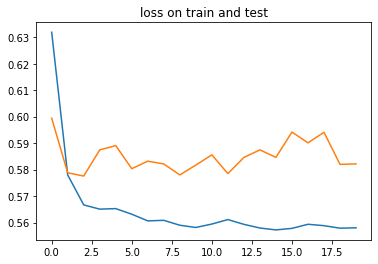

Last loss on train: 0.5580068992829956
Last loss on test: 0.5821586800248999


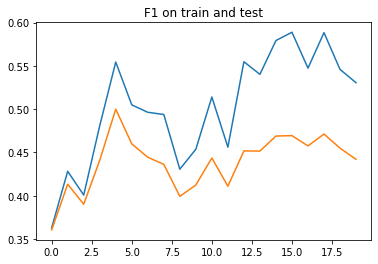

Last F1 on train: 0.5305454431645638
Last F1 on test: 0.4420782108055918


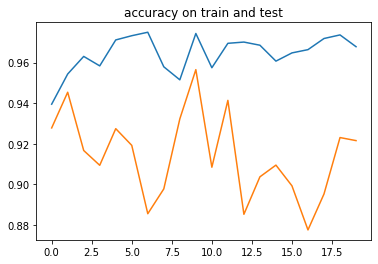

Last accuracy on train: 0.9678058833938784
Last accuracy on test: 0.9215885436064318


In [14]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [15]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.8282644799667843


In [16]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

--O scheiß-B drauf-I .-O
du-O weißt-O doch-O ,-O dass-O ich-O das-O nicht-O mit-O absicht-O gema-O ...-O ja-O ,-O schon-B klar-I .-O
ach-B ja-I ?-O
ich-B weiß-I .-O
keine-B ahnung-I .-O
na-B gut-I ,-O kommt-O ,-O 2-O gegen-O einen-O .-O
phoebe-O ...-O --O ja-O ,-O ich-B bin-I draußen-I .-O
lhr-O kennt-O doch-O meinen-O vater-O ,-O stimmt-B 's-I ?-O
ich-B glaube-I schon-I .-O
--O hör-B auf-I .-O
madame-O kali-O ,-O nicht-B wahr-I ?-O
--O ach-B was-I .-O
na-B klar-I !-O
--O keine-B ahnung-I .-O
nicht-B wahr-I ?-O
--O ich-B auf-I jeden-I fall-I .-O
gar-B nicht-I .-O
oh-O ,-O ich-B bin-I draußen-I .-O
ja-O ,-O warum-B nicht-I ?-O
also-B gut-I .-O
--O machen-B sie-I witze-I ?-O
auf-B keinen-I fall-I .-O
--O das-B geht-I nicht-I .-O
glaub-B ich-I nicht-I .-O
nein-O ,-O das-B geht-I nicht-I ,-O das-O ist-O zu-O viel-O speichel-O .-O
--O aber-B natürlich-I .-O
aber-B so-I ist-I es-I eben-I .-O
ich-B weiß-I !-O
--O so-B sei-I es-I !-O
ist-B gut-I .-O
stimmt-B 's-I ,-O herr-O doktor-O ?-O
hör-B 